In [9]:
# --- 1. 安装依赖 ---
!pip install xarray netCDF4 matplotlib geopandas rasterio rioxarray --quiet

# --- 2. 挂载Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 3. 导入库 ---
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 2m_temperature

Variable: t2m
Time dimension: valid_time
Years: [2019 2020 2021 2022 2023]

Dataset info:
  Variables: ['t2m']
  Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
  Shape: (7304, 29, 41)
  Spatial resolution: 0.2500° lat x 0.2500° lon
  Grid size: 29 x 41

Original data range: 251.91 to 316.65
Converting from Kelvin to Celsius...
Converted range: -21.24°C to 43.50°C


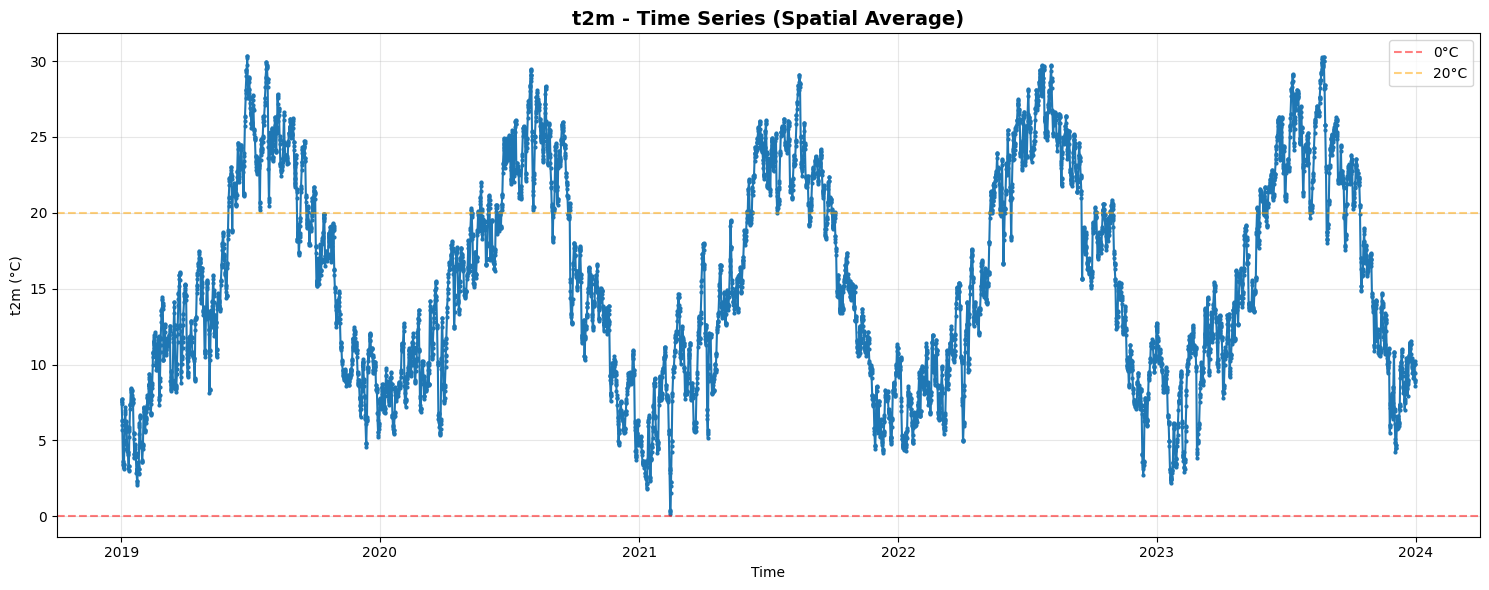

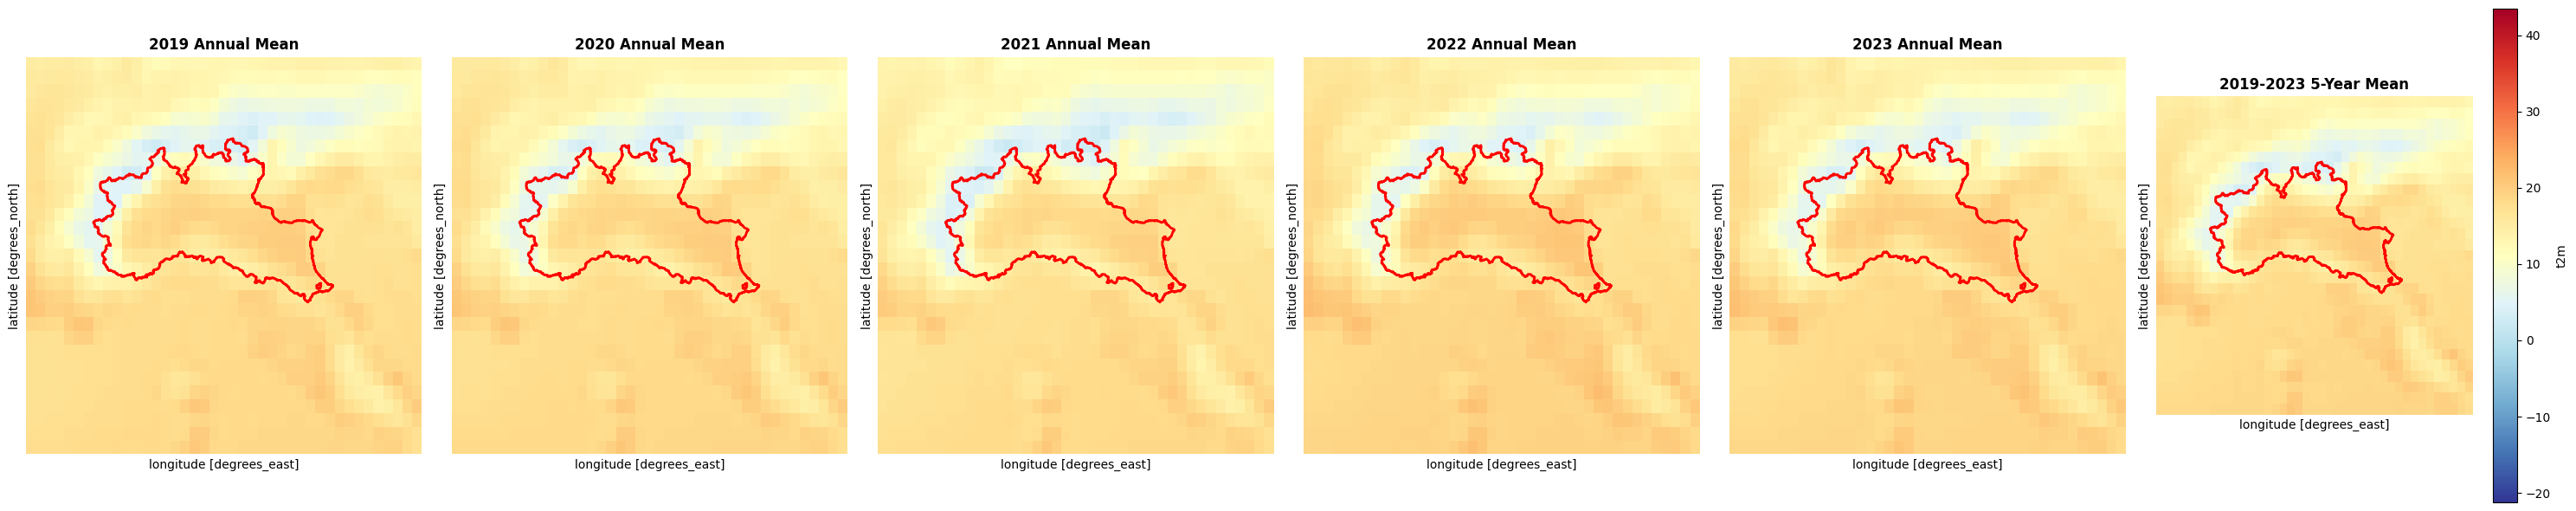


Statistics:
  Time series mean: 15.64°C
  Time series std: 6.89°C
  Spatial mean: 15.64°C
  Spatial std: 3.91°C
Temperature visualization completed!


In [ ]:
"""
Temperature Data Visualization Script
Convert ERA5 temperature data from Kelvin to Celsius and visualize
"""

import os
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set paths
temperature_file = "/content/drive/MyDrive/Variables/2m_temperature/data_stream-oper_stepType-instant.nc"
aoi_file = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"

# Data loading
if not os.path.exists(temperature_file):
    raise FileNotFoundError(f"Temperature file not found: {temperature_file}")
if not os.path.exists(aoi_file):
    raise FileNotFoundError(f"AOI file not found: {aoi_file}")

ds = xr.open_dataset(temperature_file)
aoi = gpd.read_file(aoi_file)

# Auto-identify temperature variable
var = [v for v in ds.data_vars if 'temp' in v.lower() or 't2m' in v.lower() or 'temperature' in v.lower()][0]
print(f"Variable: {var}")

# Auto-identify time dimension
time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
if time_coords:
    time_dim = time_coords[0]
    print(f"Time dimension: {time_dim}")
else:
    raise ValueError("No time dimension found")

# Ensure time has year attribute
if not hasattr(ds[time_dim].dt, 'year'):
    ds[time_dim] = xr.decode_cf(ds)[time_dim]

years = np.unique(ds[time_dim + '.year'].values)
print(f"Years: {years}")

# Print basic information
print(f"\nDataset info:")
print(f"  Variables: {list(ds.data_vars)}")
print(f"  Coordinates: {list(ds.coords)}")
print(f"  Shape: {ds[var].shape}")

# Calculate spatial resolution
if 'latitude' in ds.coords and 'longitude' in ds.coords:
    lat_diff = abs(ds.latitude.values[1] - ds.latitude.values[0])
    lon_diff = abs(ds.longitude.values[1] - ds.longitude.values[0])
    print(f"  Spatial resolution: {lat_diff:.4f}° lat x {lon_diff:.4f}° lon")
    print(f"  Grid size: {len(ds.latitude)} x {len(ds.longitude)}")
else:
    print(f"  Dimensions: {ds[var].dims}")

# Temperature unit conversion
original_data = ds[var]
print(f"\nOriginal data range: {original_data.min().values:.2f} to {original_data.max().values:.2f}")

if original_data.min().values > 200:
    print("Converting from Kelvin to Celsius...")
    ds[var] = ds[var] - 273.15
    print(f"Converted range: {ds[var].min().values:.2f}°C to {ds[var].max().values:.2f}°C")
else:
    print("Data already in Celsius")

# Time series plot
fig, ax = plt.subplots(figsize=(15, 6))

if 'latitude' in ds[var].dims and 'longitude' in ds[var].dims:
    ts_mean = ds[var].mean(dim=['latitude', 'longitude'])
else:
    ts_mean = ds[var].mean(dim=[dim for dim in ds[var].dims if dim != time_dim])

ts_mean.plot(ax=ax, marker='o', markersize=2)
ax.set_title(f'{var} - Time Series (Spatial Average)', fontsize=14, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var} (°C)')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='0°C')
ax.axhline(y=20, color='orange', linestyle='--', alpha=0.5, label='20°C')
ax.legend()
plt.tight_layout()
plt.show()

# Spatial distribution maps
n_years = len(years)
fig, axes = plt.subplots(1, n_years + 1, figsize=(5*(n_years+1), 6))

vmin = ds[var].min().values
vmax = ds[var].max().values

for i, year in enumerate(years):
    ax = axes[i]
    yearly_mean = ds[var].sel({time_dim: str(year)}).mean(dim=time_dim)

    im = yearly_mean.plot(ax=ax, cmap='RdYlBu_r', add_colorbar=False, vmin=vmin, vmax=vmax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{year} Annual Mean', fontsize=12, fontweight='bold')
    aoi.boundary.plot(ax=ax, color='red', linewidth=2)

# 5-year mean
ax = axes[-1]
mean_5yr = ds[var].mean(dim=time_dim)
im = mean_5yr.plot(ax=ax, cmap='RdYlBu_r', add_colorbar=True, vmin=vmin, vmax=vmax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f'{years[0]}-{years[-1]} 5-Year Mean', fontsize=12, fontweight='bold')
aoi.boundary.plot(ax=ax, color='red', linewidth=2)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nStatistics:")
print(f"  Time series mean: {ts_mean.mean().values:.2f}°C")
print(f"  Time series std: {ts_mean.std().values:.2f}°C")
print(f"  Spatial mean: {mean_5yr.mean().values:.2f}°C")
print(f"  Spatial std: {mean_5yr.std().values:.2f}°C")

print("Temperature visualization completed!")

In [ ]:
import xarray as xr
import numpy as np
import rasterio

def check_temperature_data_resolution():
    """Check temperature data resolution and compare with other variables"""

    print("🌡️ Checking temperature data resolution...")

    # File paths
    temp_file = "/content/drive/MyDrive/Variables/2m_temperature/data_stream-oper_stepType-instant.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"

    # Load data
    ds = xr.open_dataset(temp_file)

    # Get S5P reference specifications
    with rasterio.open(s5p_reference) as src:
        s5p_crs = src.crs
        s5p_transform = src.transform
        s5p_width = src.width
        s5p_height = src.height
        s5p_bounds = src.bounds

    print(f"\n📊 S5P NO2 Reference Data:")
    print(f"   CRS: {s5p_crs}")
    print(f"   Width: {s5p_width}")
    print(f"   Height: {s5p_height}")
    print(f"   Transform: {s5p_transform}")
    print(f"   Bounds: {s5p_bounds}")

    # Check temperature data
    print(f"\n🌡️ Temperature Data:")
    print(f"   Variables: {list(ds.data_vars)}")
    print(f"   Coordinates: {list(ds.coords)}")
    print(f"   Dimensions: {list(ds.dims)}")

    temp_var = [v for v in ds.data_vars if 'temp' in v.lower() or 't2m' in v.lower() or 'temperature' in v.lower()][0]
    temp_data = ds[temp_var]
    print(f"   Temperature variable: {temp_var}")
    print(f"   Data shape: {temp_data.shape}")

    # Check spatial resolution
    if 'latitude' in temp_data.dims and 'longitude' in temp_data.dims:
        lat = ds['latitude']
        lon = ds['longitude']
        print(f"   Latitude range: {lat.min().values:.4f} - {lat.max().values:.4f}")
        print(f"   Longitude range: {lon.min().values:.4f} - {lon.max().values:.4f}")
        print(f"   Latitude resolution: {abs(lat[1] - lat[0]).values:.4f}°")
        print(f"   Longitude resolution: {abs(lon[1] - lon[0]).values:.4f}°")

    # Check time coverage
    time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
    time_dim = time_coords[0]

    print(f"\n📅 Time Coverage:")
    print(f"   Time dimension: {time_dim}")
    print(f"   Total time steps: {len(ds[time_dim])}")

    # Check 2019-01-01 data
    jan1_data = ds.sel({time_dim: '2019-01-01'})
    print(f"   2019-01-01 time steps: {len(jan1_data[time_dim])}")

    if len(jan1_data[time_dim]) > 0:
        print(f"   Time points on 2019-01-01:")
        for i in range(len(jan1_data[time_dim])):
            time_point = jan1_data[time_dim][i]
            print(f"     {i}: {time_point.values}")

    # Compare with other variables
    print(f"\n🔍 Comparison with other variables:")
    print(f"   BLH: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")
    print(f"   Wind: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")
    print(f"   Precipitation: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")

    if 'latitude' in temp_data.dims and 'longitude' in temp_data.dims:
        temp_lat_res = abs(lat[1] - lat[0]).values
        temp_lon_res = abs(lon[1] - lon[0]).values

        if temp_lat_res == 0.25 and temp_lon_res == 0.25:
            print(f"   ✅ Temperature has same resolution as other variables (0.25°)")
        else:
            print(f"   ⚠️ Temperature resolution differs: {temp_lon_res:.4f}° x {temp_lat_res:.4f}°")

        if len(jan1_data[time_dim]) == 4:
            print(f"   ✅ Temperature has same time coverage as other variables (4 hours/day)")
        else:
            print(f"   ⚠️ Temperature time coverage differs: {len(jan1_data[time_dim])} hours/day")

    return ds

# Run the check
temp_ds = check_temperature_data_resolution()

🌡️ Checking temperature data resolution...

📊 S5P NO2 Reference Data:
   CRS: EPSG:4326
   Width: 621
   Height: 300
   Transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
   Bounds: BoundingBox(left=6.620030281745857, bottom=43.640199621659995, right=12.830058688036154, top=46.64021334450555)

🌡️ Temperature Data:
   Variables: ['t2m']
   Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
   Dimensions: ['valid_time', 'latitude', 'longitude']
   Temperature variable: t2m
   Data shape: (7304, 29, 41)
   Latitude range: 41.0000 - 48.0000
   Longitude range: 5.0000 - 15.0000
   Latitude resolution: 0.2500°
   Longitude resolution: 0.2500°

📅 Time Coverage:
   Time dimension: valid_time
   Total time steps: 7304
   2019-01-01 time steps: 4
   Time points on 2019-01-01:
     0: 2019-01-01T12:00:00.000000000
     1: 2019-01-01T13:00:00.000000000
     2: 2019-01-01T14:00:00.000000000
     3: 2019-01-01T15:00:00.000000000

🔍 Comparison with other var

In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import os
from pathlib import Path

def process_temperature_to_s5p_grid():
    """Process temperature data to S5P grid-aligned GeoTIFF format"""

    print("🌡️ Processing temperature data...")

    # File paths
    temp_file = "/content/drive/MyDrive/Variables/2m_temperature/data_stream-oper_stepType-instant.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
    output_dir = "/content/drive/MyDrive/Variables/2m_temperature/2m_temperature_processed"
    os.makedirs(output_dir, exist_ok=True)

    # Load data
    ds = xr.open_dataset(temp_file)

    # Get S5P reference specifications
    with rasterio.open(s5p_reference) as src:
        target_crs = src.crs
        target_transform = src.transform
        target_width = src.width
        target_height = src.height
        target_bounds = src.bounds

    print(f"   S5P target grid: {target_width} x {target_height}")

    # Identify variable and time dimension
    temp_var = [v for v in ds.data_vars if 'temp' in v.lower() or 't2m' in v.lower() or 'temperature' in v.lower()][0]
    time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
    time_dim = time_coords[0]

    print(f"   Temperature variable: {temp_var}")
    print(f"   Time dimension: {time_dim}")

    # Ensure time has year attribute
    if not hasattr(ds[time_dim].dt, 'year'):
        ds[time_dim] = xr.decode_cf(ds)[time_dim]

    # Temperature unit conversion (Kelvin to Celsius)
    print("🌡️ Converting from Kelvin to Celsius...")
    original_data = ds[temp_var]
    if original_data.min().values > 200:  # If data is in Kelvin
        ds[temp_var] = ds[temp_var] - 273.15
        print(f"   Converted range: {ds[temp_var].min().values:.2f}°C to {ds[temp_var].max().values:.2f}°C")
    else:
        print(f"   Data already in Celsius: {ds[temp_var].min().values:.2f}°C to {ds[temp_var].max().values:.2f}°C")

    # Check time coverage
    print("🔍 Checking temperature time coverage...")
    jan1_data = ds.sel({time_dim: '2019-01-01'})
    print(f"   2019-01-01 time steps: {len(jan1_data[time_dim])}")

    # Calculate daily average temperature
    print("📅 Calculating daily average temperature...")
    daily_temp = ds[temp_var].groupby(f'{time_dim}.date').mean(time_dim)

    print(f"   Daily temperature shape: {daily_temp.shape}")
    print(f"   Number of days: {len(daily_temp.date)}")

    # Process by year
    years = [2019, 2020, 2021, 2022, 2023]

    for year in years:
        print(f"\n📁 Processing {year}...")

        # Filter data by year
        dates = pd.to_datetime(daily_temp.date.values)
        year_mask = dates.year == year
        yearly_data = daily_temp.sel(date=daily_temp.date[year_mask])

        n_days = len(yearly_data.date)
        print(f"   Number of days: {n_days}")

        if n_days == 0:
            print(f"   ⚠️ No data found for {year}, skipping...")
            continue

        # Create output GeoTIFF
        output_file = f"{output_dir}/temperature_daily_{year}.tif"

        profile = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': n_days,
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': np.nan
        }

        output_data = np.full((n_days, target_height, target_width), np.nan, dtype=np.float32)

        # Process each day
        for day_idx in range(n_days):
            if day_idx % 50 == 0:
                print(f"     Processing day {day_idx + 1}/{n_days}")

            daily_slice = yearly_data.isel(date=day_idx)
            daily_array = daily_slice.values

            source_height, source_width = daily_array.shape
            source_bounds = (5.0, 41.0, 15.0, 48.0)
            source_transform = rasterio.transform.from_bounds(*source_bounds, source_width, source_height)

            reproject(
                source=daily_array,
                destination=output_data[day_idx],
                src_transform=source_transform,
                src_crs=target_crs,
                dst_transform=target_transform,
                dst_crs=target_crs,
                resampling=Resampling.bilinear,
                nodata=np.nan
            )

        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(output_data)

        print(f"  ✅ Saved: {output_file}")
        print(f"     Shape: {output_data.shape}")
        print(f"     Valid values: {np.sum(~np.isnan(output_data))}")

    # Create 5-year mean
    print(f"\n📊 Creating 5-year mean...")
    all_years_data = []

    for year in years:
        year_file = f"{output_dir}/temperature_daily_{year}.tif"
        if os.path.exists(year_file):
            with rasterio.open(year_file) as src:
                data = src.read()
                all_years_data.append(data)

    if all_years_data:
        mean_5yr = np.nanmean(np.concatenate(all_years_data, axis=0), axis=0)

        mean_profile = profile.copy()
        mean_profile['count'] = 1

        mean_file = f"{output_dir}/temperature_5year_mean.tif"
        with rasterio.open(mean_file, 'w', **mean_profile) as dst:
            dst.write(mean_5yr, 1)

        print(f"  ✅ Saved 5-year mean: {mean_file}")

    print(f"\n🎉 Temperature processing completed!")
    print(f"   Output directory: {output_dir}")
    print(f"   Files created:")
    for year in years:
        print(f"     - temperature_daily_{year}.tif")
    print(f"     - temperature_5year_mean.tif")

# Run processing
if __name__ == "__main__":
    process_temperature_to_s5p_grid()

🌡️ Processing temperature data...
   S5P target grid: 621 x 300
   Temperature variable: t2m
   Time dimension: valid_time
🌡️ Converting from Kelvin to Celsius...
   Converted range: -21.24°C to 43.50°C
🔍 Checking temperature time coverage...
   2019-01-01 time steps: 4
📅 Calculating daily average temperature...
   Daily temperature shape: (1826, 29, 41)
   Number of days: 1826

📁 Processing 2019...
   Number of days: 365
     Processing day 1/365
     Processing day 51/365
     Processing day 101/365
     Processing day 151/365
     Processing day 201/365
     Processing day 251/365
     Processing day 301/365
     Processing day 351/365
  ✅ Saved: /content/drive/MyDrive/Variables/2m_temperature/2m_temperature_processed/temperature_daily_2019.tif
     Shape: (365, 300, 621)
     Valid values: 67999500

📁 Processing 2020...
   Number of days: 366
     Processing day 1/366
     Processing day 51/366
     Processing day 101/366
     Processing day 151/366
     Processing day 201/366
    

In [ ]:
def quality_check_temperature_results():
    """Quality check of processed temperature data"""

    print("🔍 Quality check of processed temperature data...")

    output_dir = "/content/drive/MyDrive/Variables/2m_temperature/2m_temperature_processed"

    years = [2019, 2020, 2021, 2022, 2023]

    print("\n🌡️ Temperature Data (in Celsius):")
    for year in years:
        file_path = f"{output_dir}/temperature_daily_{year}.tif"
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read()
                print(f"   {year}: Shape {data.shape}, Valid values: {np.sum(~np.isnan(data))}")
                print(f"     Range: {np.nanmin(data):.2f}°C - {np.nanmax(data):.2f}°C")
                print(f"     Mean: {np.nanmean(data):.2f}°C")
                print(f"     Std: {np.nanstd(data):.2f}°C")
        else:
            print(f"   ❌ {year} file not found")

    # Check 5-year mean
    print("\n🌡️ 5-Year Mean Temperature:")
    mean_file = f"{output_dir}/temperature_5year_mean.tif"
    if os.path.exists(mean_file):
        with rasterio.open(mean_file) as src:
            data = src.read(1)
            print(f"   Shape: {data.shape}")
            print(f"   Range: {np.nanmin(data):.2f}°C - {np.nanmax(data):.2f}°C")
            print(f"   Mean: {np.nanmean(data):.2f}°C")
            print(f"   Std: {np.nanstd(data):.2f}°C")

            # Check for reasonable temperature values
            min_temp = np.nanmin(data)
            max_temp = np.nanmax(data)
            mean_temp = np.nanmean(data)

            print(f"\n📊 Temperature Quality Assessment:")
            if -50 <= min_temp <= 10:
                print(f"   ✅ Minimum temperature reasonable: {min_temp:.2f}°C")
            else:
                print(f"   ⚠️ Minimum temperature unusual: {min_temp:.2f}°C")

            if 30 <= max_temp <= 60:
                print(f"   ✅ Maximum temperature reasonable: {max_temp:.2f}°C")
            else:
                print(f"   ⚠️ Maximum temperature unusual: {max_temp:.2f}°C")

            if 10 <= mean_temp <= 25:
                print(f"   ✅ Mean temperature reasonable: {mean_temp:.2f}°C")
            else:
                print(f"   ⚠️ Mean temperature unusual: {mean_temp:.2f}°C")
    else:
        print(f"   ❌ 5-year mean file not found")

# Run quality check
quality_check_temperature_results()

🔍 Quality check of processed temperature data...

🌡️ Temperature Data (in Celsius):
   2019: Shape (365, 300, 621), Valid values: 67999500
     Range: -17.41°C - 40.15°C
     Mean: 14.32°C
     Std: 9.12°C
   2020: Shape (366, 300, 621), Valid values: 68185800
     Range: -13.81°C - 36.96°C
     Mean: 14.37°C
     Std: 8.57°C
   2021: Shape (365, 300, 621), Valid values: 67999500
     Range: -17.26°C - 39.24°C
     Mean: 13.60°C
     Std: 9.23°C
   2022: Shape (365, 300, 621), Valid values: 67999500
     Range: -19.59°C - 39.35°C
     Mean: 15.22°C
     Std: 9.35°C
   2023: Shape (365, 300, 621), Valid values: 67999500
     Range: -18.64°C - 39.23°C
     Mean: 15.00°C
     Std: 9.08°C

🌡️ 5-Year Mean Temperature:
   Shape: (300, 621)
   Range: 3.05°C - 20.46°C
   Mean: 14.50°C
   Std: 4.65°C

📊 Temperature Quality Assessment:
   ✅ Minimum temperature reasonable: 3.05°C
   ⚠️ Maximum temperature unusual: 20.46°C
   ✅ Mean temperature reasonable: 14.50°C


## 2. boundary_layer_height

Dataset variables: ['blh']
Dataset coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
Using variable: blh
Using time dimension: valid_time
Years in data: [2019 2020 2021 2022 2023]

📈 Generating time series plot...


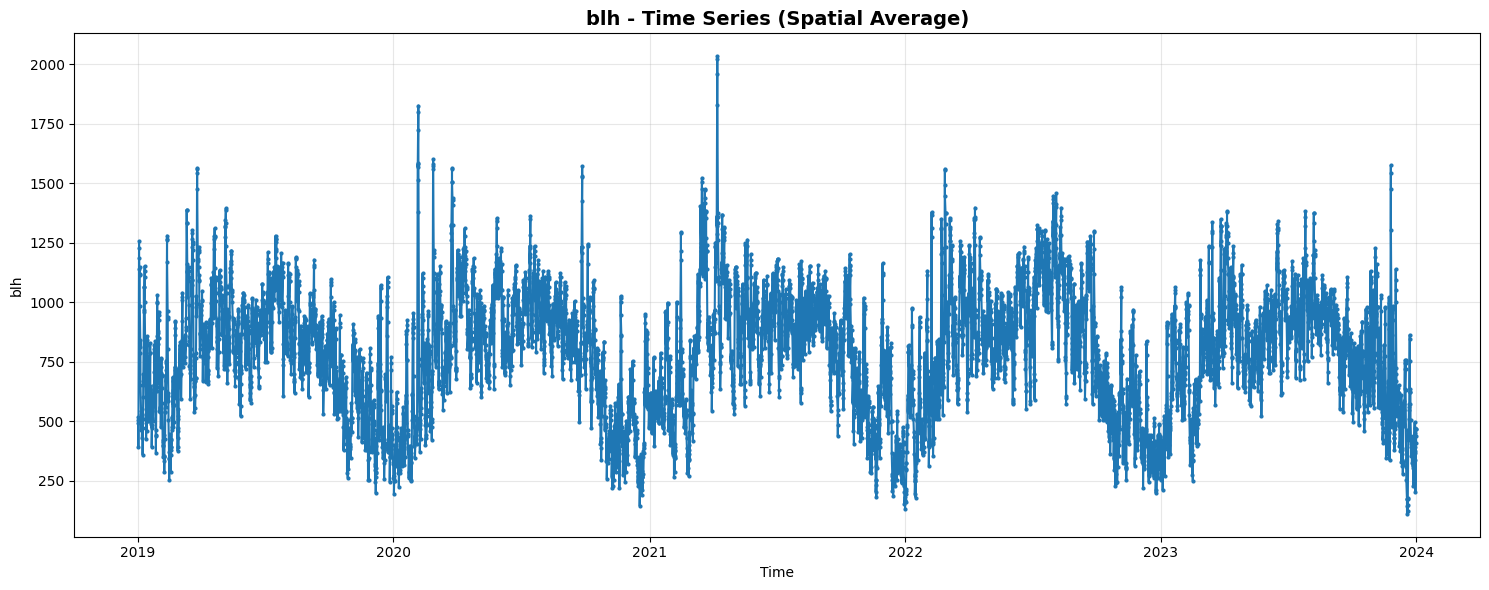


🗺️ Generating spatial distribution maps with borders...


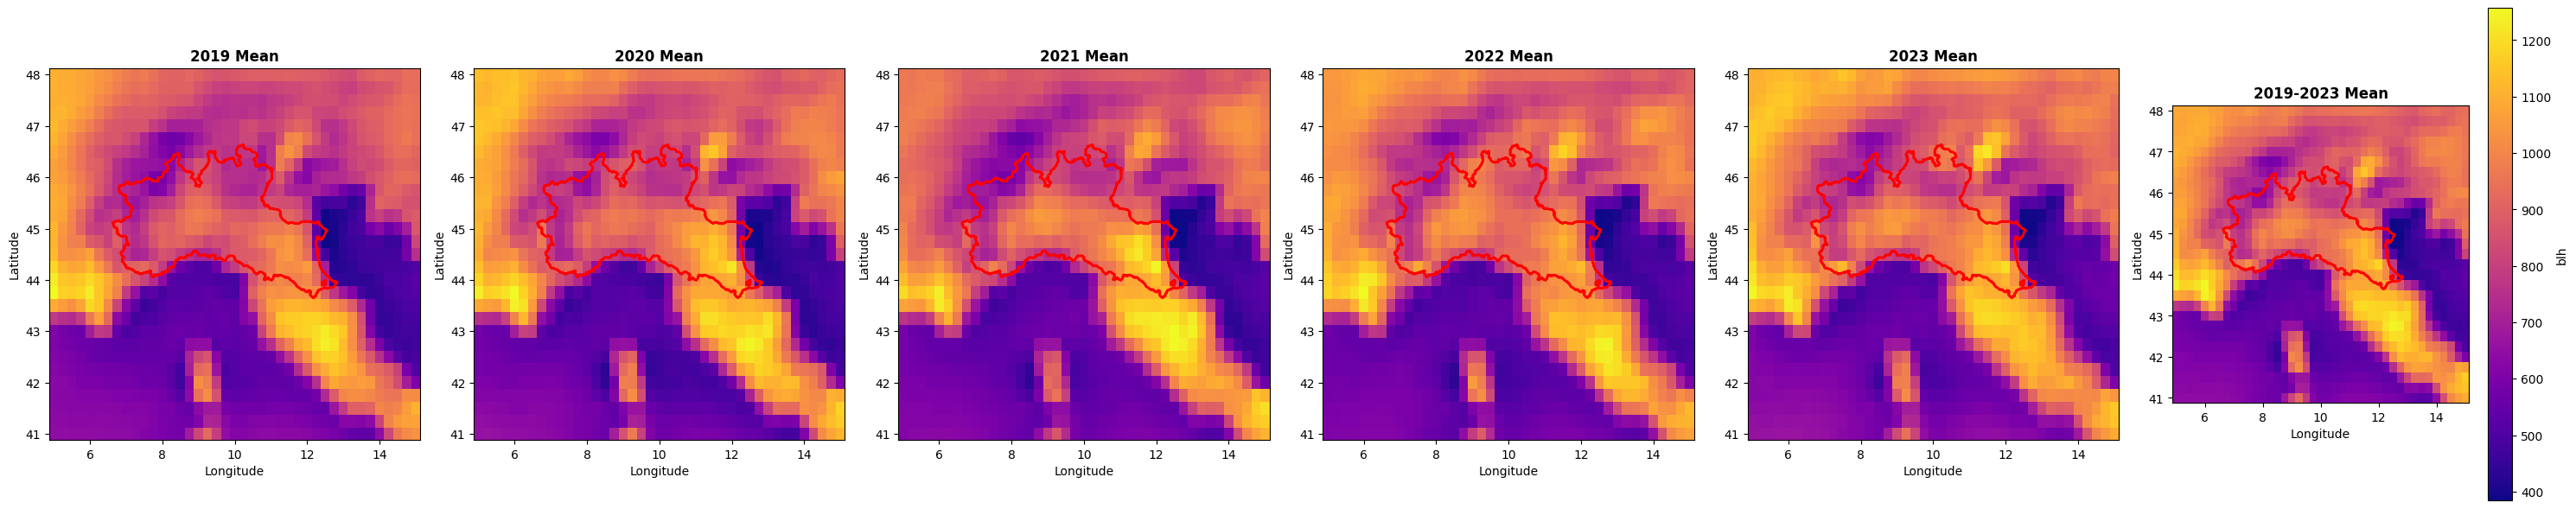


📊 Statistical Summary:
Time series statistics:
  Minimum: 111.13
  Maximum: 2033.14
  Mean: 801.99
  Standard deviation: 258.69

Spatial distribution statistics (5-year mean):
  Minimum: 384.75
  Maximum: 1256.73
  Mean: 801.99
  Standard deviation: 213.52


In [ ]:
# --- 4. 文件路径 ---
temperature_file = "/content/drive/MyDrive/Variables/boundary_layer_height/data_stream-oper_stepType-instant.nc"
aoi_file = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"

# --- 5. 数据加载 ---
import os
if not os.path.exists(temperature_file):
    raise FileNotFoundError(f"Boundary layer height file not found: {temperature_file}")
if not os.path.exists(aoi_file):
    raise FileNotFoundError(f"AOI file not found: {aoi_file}")

ds = xr.open_dataset(temperature_file)
aoi = gpd.read_file(aoi_file)

print(f"Dataset variables: {list(ds.data_vars)}")
print(f"Dataset coordinates: {list(ds.coords)}")

# --- 6. 变量和时间处理 ---
# 自动识别边界层高度变量
var = [v for v in ds.data_vars if 'blh' in v.lower() or 'boundary' in v.lower() or 'height' in v.lower() or 'layer' in v.lower()][0]
print(f"Using variable: {var}")

# 自动识别时间维度
time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
if time_coords:
    time_dim = time_coords[0]
    print(f"Using time dimension: {time_dim}")
else:
    raise ValueError("No time dimension found")

# 确保时间有year属性
if not hasattr(ds[time_dim].dt, 'year'):
    ds[time_dim] = xr.decode_cf(ds)[time_dim]

years = np.unique(ds[time_dim + '.year'].values)
print(f"Years in data: {years}")

# --- 7. 时间序列图 ---
print("\n📈 Generating time series plot...")
fig, ax = plt.subplots(figsize=(15, 6))

# 计算空间平均时间序列
if 'latitude' in ds[var].dims and 'longitude' in ds[var].dims:
    ts_mean = ds[var].mean(dim=['latitude', 'longitude'])
else:
    ts_mean = ds[var].mean(dim=[dim for dim in ds[var].dims if dim != time_dim])

ts_mean.plot(ax=ax, marker='o', markersize=2)
ax.set_title(f'{var} - Time Series (Spatial Average)', fontsize=14, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 8. 空间分布图（保留边框） ---
print("\n🗺️ Generating spatial distribution maps with borders...")
n_years = len(years)
fig, axes = plt.subplots(1, n_years + 1, figsize=(5*(n_years+1), 6))

for i, year in enumerate(years):
    ax = axes[i]
    yearly_mean = ds[var].sel({time_dim: str(year)}).mean(dim=time_dim)

    # 绘制热力图（保留边框）
    im = yearly_mean.plot(ax=ax, cmap='plasma', add_colorbar=False)

    # 保留坐标轴边框和标签
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{year} Mean', fontsize=12, fontweight='bold')

    # AOI叠加（保持红色边框）
    aoi.boundary.plot(ax=ax, color='red', linewidth=2)

# 5年均值（最后一个图）
ax = axes[-1]
mean_5yr = ds[var].mean(dim=time_dim)

# 绘制热力图（保留边框）
im = mean_5yr.plot(ax=ax, cmap='plasma', add_colorbar=True)

# 保留坐标轴边框和标签
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'{years[0]}-{years[-1]} Mean', fontsize=12, fontweight='bold')

# AOI叠加（保持红色边框）
aoi.boundary.plot(ax=ax, color='red', linewidth=2)

plt.tight_layout()
plt.show()

# --- 9. 统计信息 ---
print("\n📊 Statistical Summary:")
print(f"Time series statistics:")
print(f"  Minimum: {ts_mean.min().values:.2f}")
print(f"  Maximum: {ts_mean.max().values:.2f}")
print(f"  Mean: {ts_mean.mean().values:.2f}")
print(f"  Standard deviation: {ts_mean.std().values:.2f}")

print(f"\nSpatial distribution statistics (5-year mean):")
print(f"  Minimum: {mean_5yr.min().values:.2f}")
print(f"  Maximum: {mean_5yr.max().values:.2f}")
print(f"  Mean: {mean_5yr.mean().values:.2f}")
print(f"  Standard deviation: {mean_5yr.std().values:.2f}")

In [ ]:
# Step 1: Check S5P Reference Data Specifications
import rasterio
import numpy as np
import xarray as xr

def check_s5p_reference_specs():
    """Check S5P reference data specifications"""

    print("🔍 Checking S5P reference data specifications...")

    # S5P reference file path
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"

    try:
        with rasterio.open(s5p_reference) as src:
            print(f"✅ Successfully opened S5P reference file")

            # Basic information
            print(f" S5P Reference Data Specifications:")
            print(f"   File path: {s5p_reference}")
            print(f"   Number of bands: {src.count}")
            print(f"   Width: {src.width}")
            print(f"   Height: {src.height}")
            print(f"   Data type: {src.dtypes[0]}")
            print(f"   Coordinate Reference System: {src.crs}")
            print(f"   Transform matrix: {src.transform}")
            print(f"   Bounding box: {src.bounds}")

            # Read one band to confirm data shape
            data = src.read(1)  # Read first band
            print(f"   Data shape: {data.shape}")
            print(f"   Valid value range: {np.nanmin(data):.4f} - {np.nanmax(data):.4f}")
            print(f"   Number of missing values: {np.isnan(data).sum()}")

            # Save reference specifications
            s5p_specs = {
                'crs': src.crs,
                'transform': src.transform,
                'width': src.width,
                'height': src.height,
                'count': src.count,
                'dtype': src.dtypes[0],
                'bounds': src.bounds
            }

            return s5p_specs

    except Exception as e:
        print(f"❌ Cannot open S5P reference file: {e}")
        return None

# Check S5P specifications
s5p_specs = check_s5p_reference_specs()



#Step 2: Check BLH Data Coordinate System
def check_blh_coordinate_system():
    """Check BLH data coordinate system"""

    print("\n🔍 Checking BLH data coordinate system...")

    # BLH file path
    blh_file = "/content/drive/MyDrive/Variables/boundary_layer_height/data_stream-oper_stepType-instant.nc"

    try:
        ds = xr.open_dataset(blh_file)
        print(f"✅ Successfully opened BLH data file")

        # Basic information
        print(f"\n📊 BLH Data Specifications:")
        print(f"   File path: {blh_file}")
        print(f"   Variables: {list(ds.data_vars)}")
        print(f"   Coordinates: {list(ds.coords)}")
        print(f"   Dimensions: {list(ds.dims)}")

        # Check blh variable dimensions
        blh_var = ds['blh']
        print(f"\n   BLH Variable Information:")
        print(f"   Dimensions: {blh_var.dims}")
        print(f"   Shape: {blh_var.shape}")

        # Check coordinate information
        if 'latitude' in ds.coords:
            lat = ds['latitude']
            print(f"\n   Latitude Information:")
            print(f"     Range: {lat.min().values:.4f} - {lat.max().values:.4f}")
            print(f"     Resolution: {abs(lat[1] - lat[0]).values:.4f}")
            print(f"     Units: {lat.units if hasattr(lat, 'units') else 'Unknown'}")

        if 'longitude' in ds.coords:
            lon = ds['longitude']
            print(f"\n   Longitude Information:")
            print(f"     Range: {lon.min().values:.4f} - {lon.max().values:.4f}")
            print(f"     Resolution: {abs(lon[1] - lon[0]).values:.4f}")
            print(f"     Units: {lon.units if hasattr(lon, 'units') else 'Unknown'}")

        if 'valid_time' in ds.coords:
            time = ds['valid_time']
            print(f"\n   Time Information:")
            print(f"     Range: {time.min().values} - {time.max().values}")
            print(f"     Number of time steps: {len(time)}")

        # Check CRS information
        if hasattr(ds, 'crs'):
            print(f"\n   Coordinate Reference System: {ds.crs}")
        else:
            print(f"\n   ⚠️ CRS information not found, may need manual specification")

        return ds

    except Exception as e:
        print(f"❌ Cannot open BLH data file: {e}")
        return None

# Check BLH coordinate system
blh_ds = check_blh_coordinate_system()


#Step 3: Compare Dataset Specifications

def compare_datasets(s5p_specs, blh_ds):
    """Compare S5P and BLH dataset specifications"""

    print(f"\n🔍 Dataset Specification Comparison:")
    print(f"{'='*50}")

    if s5p_specs and blh_ds:
        print(f" S5P Reference Data:")
        print(f"   Spatial resolution: {s5p_specs['width']} x {s5p_specs['height']}")
        print(f"   Coordinate system: {s5p_specs['crs']}")
        print(f"   Bounding box: {s5p_specs['bounds']}")

        print(f"\n📊 BLH Data:")
        if 'latitude' in blh_ds.coords and 'longitude' in blh_ds.coords:
            lat_res = abs(blh_ds['latitude'][1] - blh_ds['latitude'][0]).values
            lon_res = abs(blh_ds['longitude'][1] - blh_ds['longitude'][0]).values
            print(f"   Spatial resolution: {len(blh_ds['longitude'])} x {len(blh_ds['latitude'])}")
            print(f"   Lat/Lon resolution: {lon_res:.4f}° x {lat_res:.4f}°")
            print(f"   Latitude range: {blh_ds['latitude'].min().values:.4f} - {blh_ds['latitude'].max().values:.4f}")
            print(f"   Longitude range: {blh_ds['longitude'].min().values:.4f} - {blh_ds['longitude'].max().values:.4f}")

        # Determine if reprojection is needed
        print(f"\n🔧 Processing Recommendations:")
        print(f"   1. Time aggregation: Hourly → Daily average")
        print(f"   2. Spatial reprojection: BLH grid → S5P grid")
        print(f"   3. Format conversion: NetCDF → GeoTIFF")
        print(f"   4. Batch export: Process 2019-2023 separately")

        return True
    else:
        print(f"❌ Cannot compare dataset specifications")
        return False

# Compare datasets
comparison_result = compare_datasets(s5p_specs, blh_ds)

🔍 Checking S5P reference data specifications...
✅ Successfully opened S5P reference file
 S5P Reference Data Specifications:
   File path: /content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif
   Number of bands: 365
   Width: 621
   Height: 300
   Data type: float32
   Coordinate Reference System: EPSG:4326
   Transform matrix: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
   Bounding box: BoundingBox(left=6.620030281745857, bottom=43.640199621659995, right=12.830058688036154, top=46.64021334450555)
   Data shape: (300, 621)
   Valid value range: -0.0000 - 0.0003
   Number of missing values: 150761

🔍 Checking BLH data coordinate system...
✅ Successfully opened BLH data file

📊 BLH Data Specifications:
   File path: /content/drive/MyDrive/Variables/boundary_layer_height/data_stream-oper_stepType-instant.nc
   Variables: ['blh']
   Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
   Dimensions: ['valid_time', 'latitude', 'longitude']

   BLH

In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import os
from pathlib import Path

def process_blh_satellite_overpass():
    """Process BLH satellite overpass data (4 hours per day)"""

    print("🛰️ Processing BLH satellite overpass data...")

    # File paths
    blh_file = "/content/drive/MyDrive/Variables/boundary_layer_height/data_stream-oper_stepType-instant.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
    output_dir = "/content/drive/MyDrive/Variables/boundary_layer_height/boundary_layer_height_processed"
    os.makedirs(output_dir, exist_ok=True)

    # Load data
    ds = xr.open_dataset(blh_file)

    # Get S5P reference specifications
    with rasterio.open(s5p_reference) as src:
        target_crs = src.crs  # EPSG:4326
        target_transform = src.transform
        target_width = src.width  # 621
        target_height = src.height  # 300
        target_bounds = src.bounds

    print(f"   S5P target grid: {target_width} x {target_height}")
    print(f"   BLH data: 4 hours per day (12:00-15:00)")

    # Calculate daily average from 4 satellite overpass hours
    print("📅 Calculating daily average from 4 satellite overpass hours...")
    daily_blh = ds['blh'].groupby('valid_time.date').mean('valid_time')

    print(f"   Daily data shape: {daily_blh.shape}")
    print(f"   Number of days: {len(daily_blh.date)}")

    # Process by year
    years = [2019, 2020, 2021, 2022, 2023]

    for year in years:
        print(f"\n📁 Processing {year}...")

        # 修正：使用pandas datetime方法
        # 将xarray的date转换为pandas datetime
        dates = pd.to_datetime(daily_blh.date.values)
        year_mask = dates.year == year

        # 使用布尔索引选择该年份的数据
        yearly_data = daily_blh.sel(date=daily_blh.date[year_mask])

        # Get number of days in this year
        n_days = len(yearly_data.date)
        print(f"   Number of days: {n_days}")

        if n_days == 0:
            print(f"   ⚠️ No data found for {year}, skipping...")
            continue

        # Create output GeoTIFF with same structure as S5P
        output_file = f"{output_dir}/blh_daily_{year}.tif"

        # Prepare metadata for GeoTIFF
        profile = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': n_days,  # One band per day
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': np.nan
        }

        # Create output array
        output_data = np.full((n_days, target_height, target_width), np.nan, dtype=np.float32)

        # Process each day
        for day_idx in range(n_days):
            if day_idx % 50 == 0:  # Progress indicator
                print(f"     Processing day {day_idx + 1}/{n_days}")

            # Get daily data
            daily_slice = yearly_data.isel(date=day_idx)

            # Convert to numpy array and handle coordinates
            daily_array = daily_slice.values  # Shape: (29, 41)

            # Create source rasterio dataset for reprojection
            # BLH data: 0.25° resolution, bounds: lat(41-48), lon(5-15)
            source_height, source_width = daily_array.shape

            # Calculate source transform (approximate)
            source_bounds = (5.0, 41.0, 15.0, 48.0)  # (left, bottom, right, top)
            source_transform = rasterio.transform.from_bounds(*source_bounds, source_width, source_height)

            # Reproject to S5P grid
            reproject(
                source=daily_array,
                destination=output_data[day_idx],
                src_transform=source_transform,
                src_crs=target_crs,  # Assuming same CRS
                dst_transform=target_transform,
                dst_crs=target_crs,
                resampling=Resampling.bilinear,
                nodata=np.nan
            )

        # Save GeoTIFF
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(output_data)

        print(f"  ✅ Saved: {output_file}")
        print(f"     Shape: {output_data.shape}")
        print(f"     Valid values: {np.sum(~np.isnan(output_data))}")

    # Create 5-year mean
    print(f"\n📊 Creating 5-year mean...")
    all_years_data = []

    for year in years:
        year_file = f"{output_dir}/blh_daily_{year}.tif"
        if os.path.exists(year_file):
            with rasterio.open(year_file) as src:
                data = src.read()
                all_years_data.append(data)

    if all_years_data:
        # Calculate mean across all years
        mean_5yr = np.nanmean(np.concatenate(all_years_data, axis=0), axis=0)

        # Save 5-year mean
        mean_profile = profile.copy()
        mean_profile['count'] = 1

        mean_file = f"{output_dir}/blh_5year_mean.tif"
        with rasterio.open(mean_file, 'w', **mean_profile) as dst:
            dst.write(mean_5yr, 1)

        print(f"  ✅ Saved 5-year mean: {mean_file}")

    print(f"\n🎉 BLH processing completed!")
    print(f"   Output directory: {output_dir}")
    print(f"   Files created:")
    for year in years:
        print(f"     - blh_daily_{year}.tif")
    print(f"     - blh_5year_mean.tif")

# Run processing
if __name__ == "__main__":
    process_blh_satellite_overpass()

🛰️ Processing BLH satellite overpass data...
   S5P target grid: 621 x 300
   BLH data: 4 hours per day (12:00-15:00)
📅 Calculating daily average from 4 satellite overpass hours...
   Daily data shape: (1826, 29, 41)
   Number of days: 1826

📁 Processing 2019...
   Number of days: 365
     Processing day 1/365
     Processing day 51/365
     Processing day 101/365
     Processing day 151/365
     Processing day 201/365
     Processing day 251/365
     Processing day 301/365
     Processing day 351/365
  ✅ Saved: /content/drive/MyDrive/Variables/boundary_layer_height/boundary_layer_height_processed/blh_daily_2019.tif
     Shape: (365, 300, 621)
     Valid values: 67999500

📁 Processing 2020...
   Number of days: 366
     Processing day 1/366
     Processing day 51/366
     Processing day 101/366
     Processing day 151/366
     Processing day 201/366
     Processing day 251/366
     Processing day 301/366
     Processing day 351/366
  ✅ Saved: /content/drive/MyDrive/Variables/boundary_l

In [ ]:
def quality_check_blh_results():
    """Quality check of processed BLH data"""

    print("🔍 Quality check of processed BLH data...")

    output_dir = "/content/drive/MyDrive/Variables/boundary_layer_height/boundary_layer_height_processed"

    # Check each year file
    years = [2019, 2020, 2021, 2022, 2023]

    for year in years:
        file_path = f"{output_dir}/blh_daily_{year}.tif"

        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read()
                print(f"\n📊 {year} BLH data:")
                print(f"   Shape: {data.shape}")
                print(f"   Valid values: {np.sum(~np.isnan(data))}")
                print(f"   Value range: {np.nanmin(data):.2f} - {np.nanmax(data):.2f}")
                print(f"   Mean: {np.nanmean(data):.2f}")
                print(f"   Std: {np.nanstd(data):.2f}")
        else:
            print(f"❌ {year} file not found")

    # Check 5-year mean
    mean_file = f"{output_dir}/blh_5year_mean.tif"
    if os.path.exists(mean_file):
        with rasterio.open(mean_file) as src:
            data = src.read(1)
            print(f"\n📊 5-year mean BLH:")
            print(f"   Shape: {data.shape}")
            print(f"   Value range: {np.nanmin(data):.2f} - {np.nanmax(data):.2f}")
            print(f"   Mean: {np.nanmean(data):.2f}")
            print(f"   Std: {np.nanstd(data):.2f}")

# Run quality check
quality_check_blh_results()

🔍 Quality check of processed BLH data...

📊 2019 BLH data:
   Shape: (365, 300, 621)
   Valid values: 67999500
   Value range: 9.31 - 3806.99
   Mean: 795.42
   Std: 500.37

📊 2020 BLH data:
   Shape: (366, 300, 621)
   Valid values: 68185800
   Value range: 9.53 - 3668.60
   Mean: 812.58
   Std: 518.63

📊 2021 BLH data:
   Shape: (365, 300, 621)
   Valid values: 67999500
   Value range: 9.43 - 4233.41
   Mean: 836.27
   Std: 554.67

📊 2022 BLH data:
   Shape: (365, 300, 621)
   Valid values: 67999500
   Value range: 9.50 - 3398.87
   Mean: 859.30
   Std: 568.91

📊 2023 BLH data:
   Shape: (365, 300, 621)
   Valid values: 67999500
   Value range: 9.86 - 3451.79
   Mean: 826.52
   Std: 506.88

📊 5-year mean BLH:
   Shape: (300, 621)
   Value range: 384.85 - 1180.10
   Mean: 826.01
   Std: 168.41


## 3. wind speed and direction

U wind dataset variables: ['u10']
V wind dataset variables: ['v10']
U wind dataset coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
Using U variable: u10
Using V variable: v10
Using time dimension: valid_time
Years in data: [2019 2020 2021 2022 2023]

🌪️ Calculating wind speed and direction...
Wind speed and direction calculated successfully!

📈 Generating time series plots...


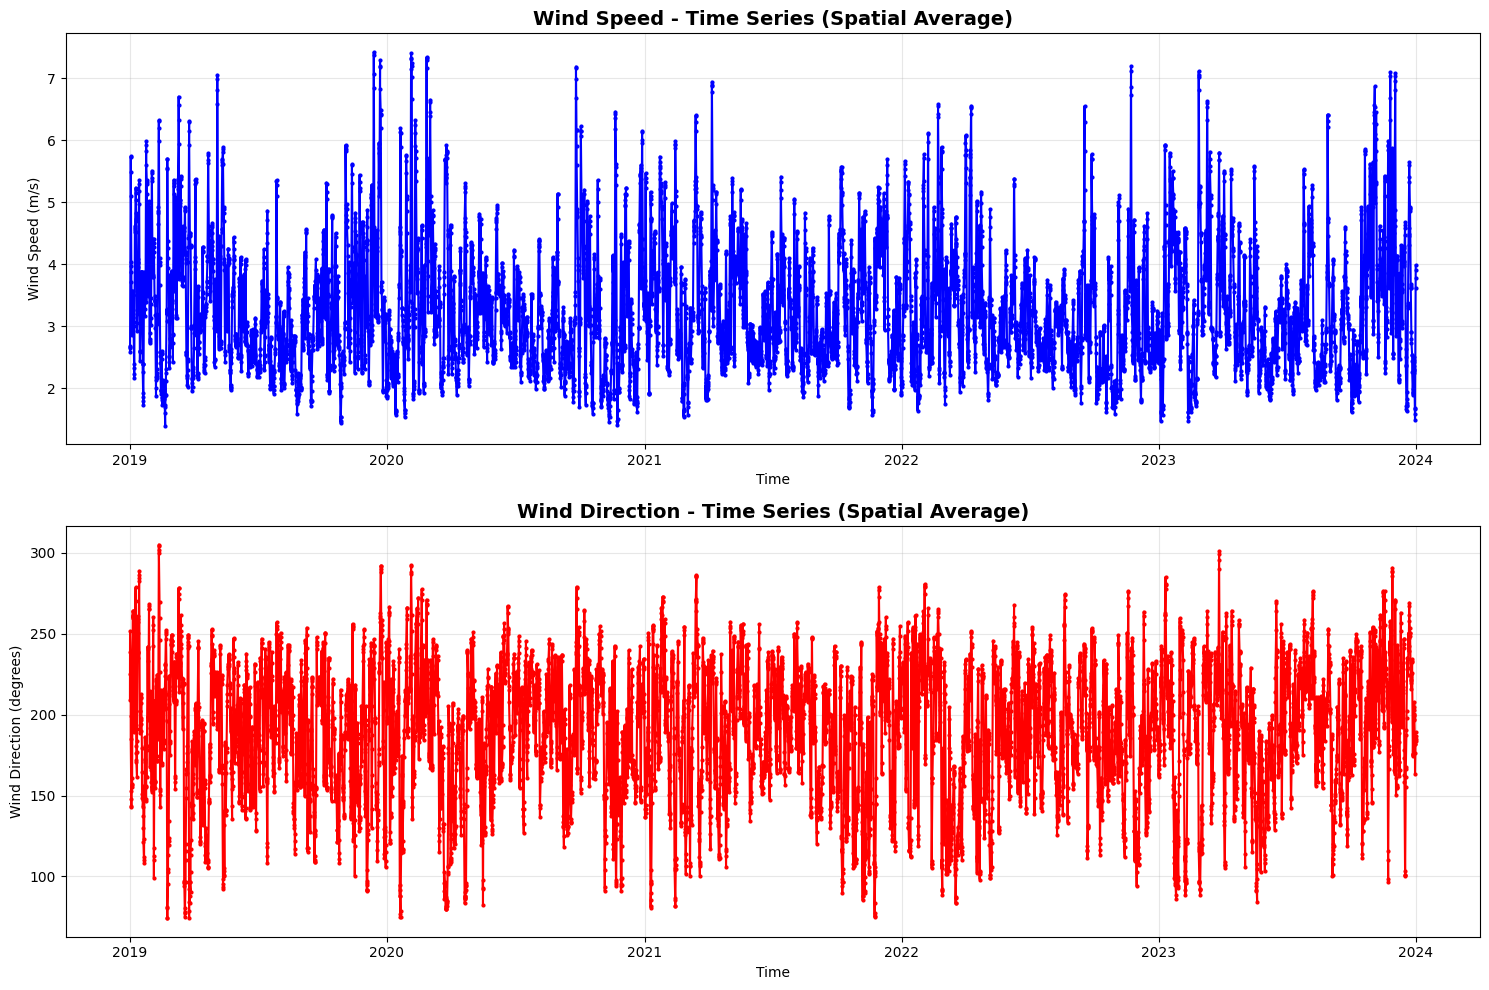


🗺️ Generating wind speed spatial distribution maps...


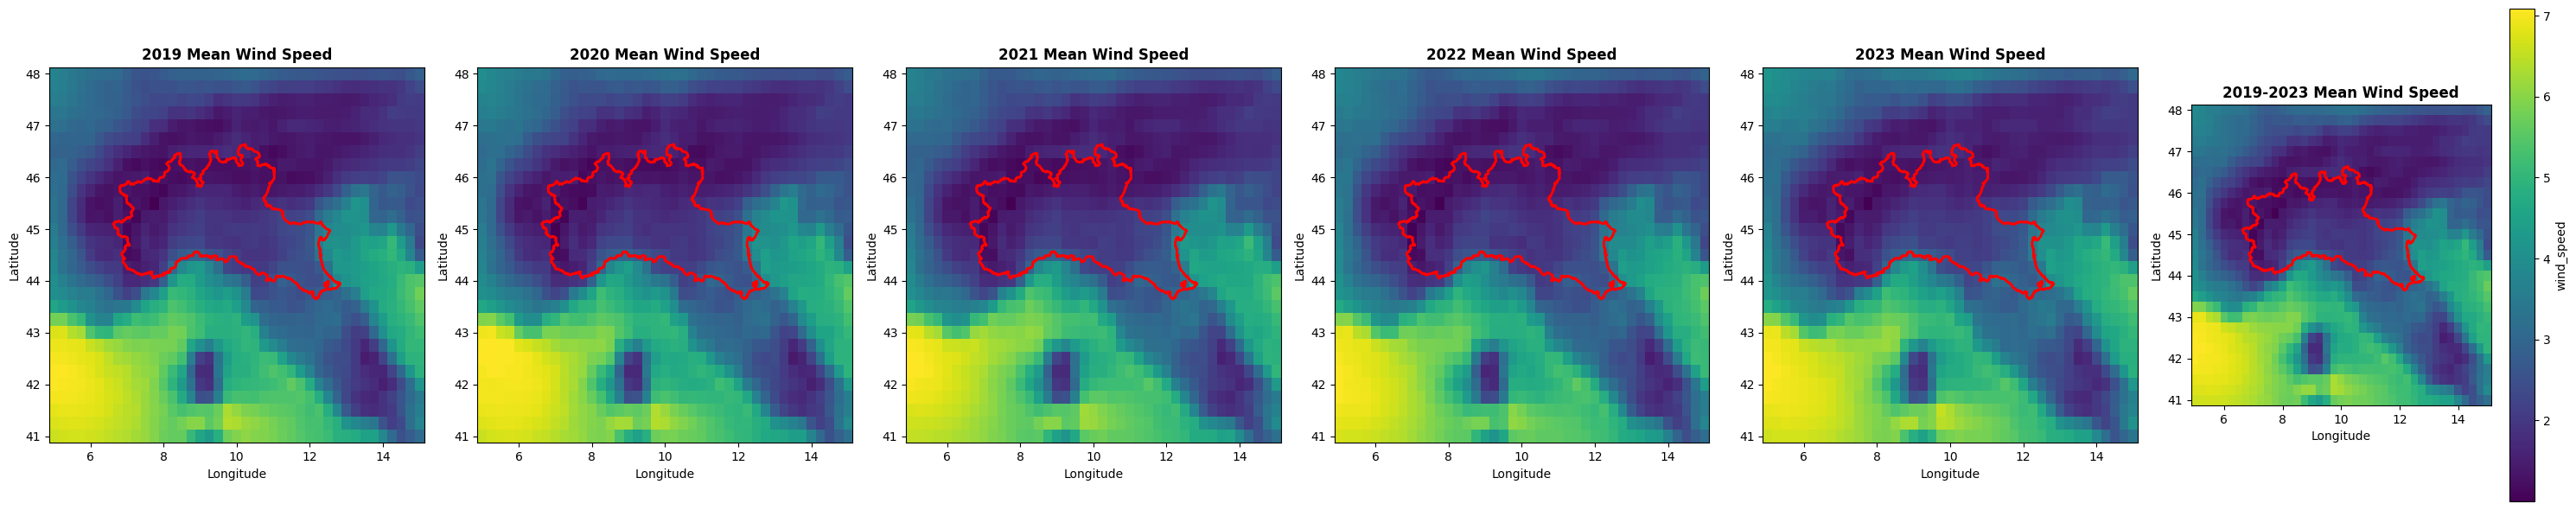


🧭 Generating wind direction spatial distribution maps...


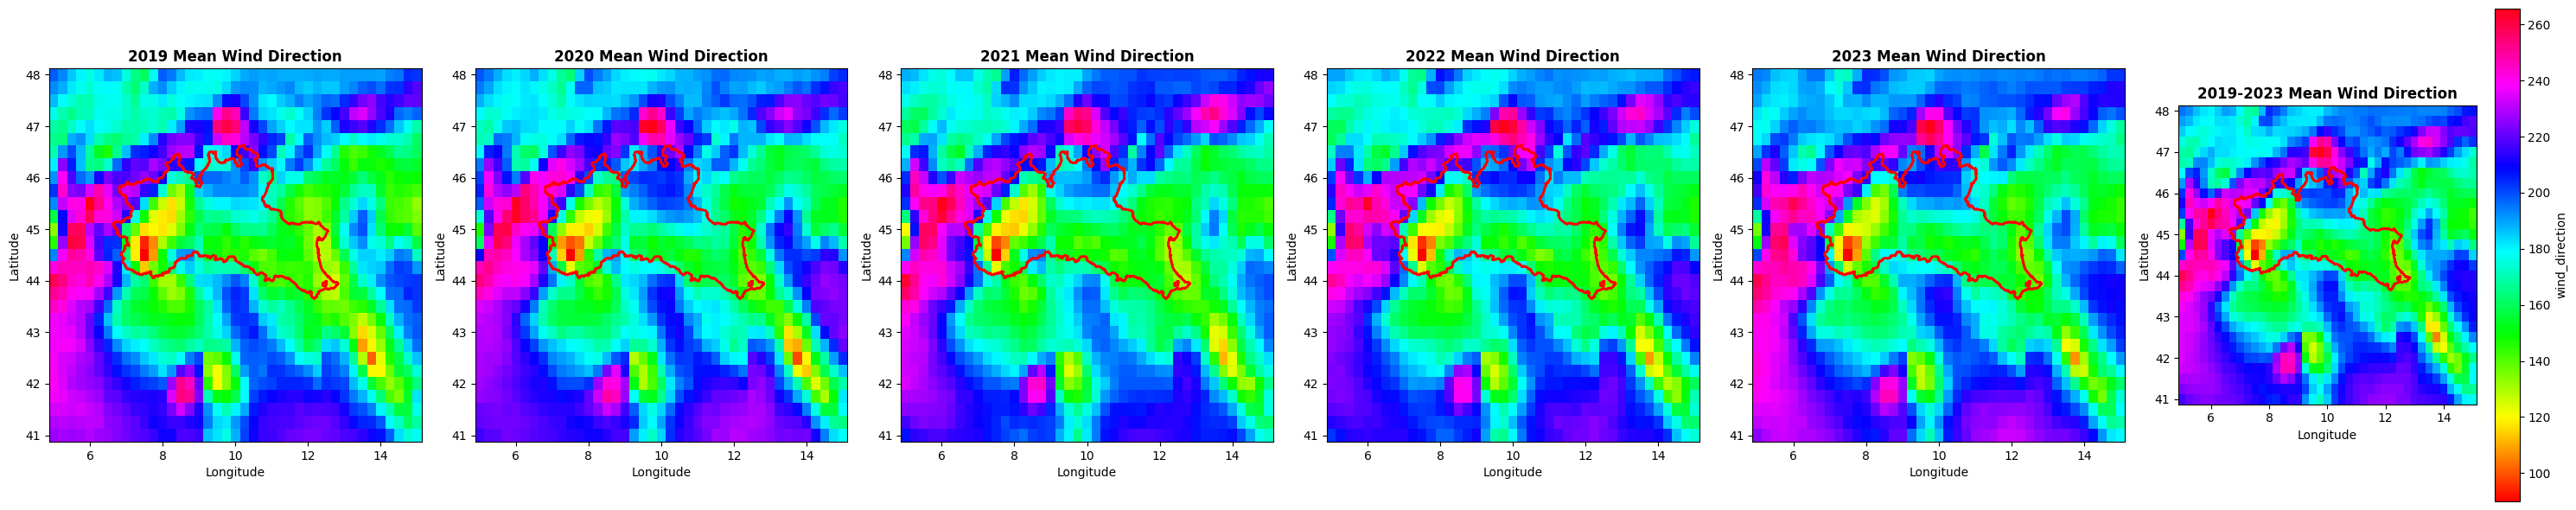


📊 Statistical Summary:
Wind Speed statistics:
  Minimum: 1.40 m/s
  Maximum: 7.42 m/s
  Mean: 3.29 m/s
  Standard deviation: 1.03 m/s

Wind Direction statistics:
  Minimum: 74.29°
  Maximum: 305.17°
  Mean: 189.72°
  Standard deviation: 41.39°

Spatial distribution statistics (5-year mean):
  Wind Speed - Mean: 3.29 m/s
  Wind Direction - Mean: 189.72°


In [ ]:
# --- 4. 文件路径 ---
u_wind_file = "/content/drive/MyDrive/Variables/10m_u_component_of_wind/data_stream-oper_stepType-instant.nc"
v_wind_file = "/content/drive/MyDrive/Variables/10m_v_component_of_wind/data_stream-oper_stepType-instant.nc"
aoi_file = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"

# --- 5. 数据加载 ---
import os
if not os.path.exists(u_wind_file):
    raise FileNotFoundError(f"U wind file not found: {u_wind_file}")
if not os.path.exists(v_wind_file):
    raise FileNotFoundError(f"V wind file not found: {v_wind_file}")
if not os.path.exists(aoi_file):
    raise FileNotFoundError(f"AOI file not found: {aoi_file}")

ds_u = xr.open_dataset(u_wind_file)
ds_v = xr.open_dataset(v_wind_file)
aoi = gpd.read_file(aoi_file)

print(f"U wind dataset variables: {list(ds_u.data_vars)}")
print(f"V wind dataset variables: {list(ds_v.data_vars)}")
print(f"U wind dataset coordinates: {list(ds_u.coords)}")

# --- 6. 变量和时间处理 ---
# 自动识别风速分量变量
u_var = [v for v in ds_u.data_vars if 'u' in v.lower() or 'wind' in v.lower()][0]
v_var = [v for v in ds_v.data_vars if 'v' in v.lower() or 'wind' in v.lower()][0]
print(f"Using U variable: {u_var}")
print(f"Using V variable: {v_var}")

# 自动识别时间维度
time_coords = [coord for coord in ds_u.coords if "time" in coord.lower()]
if time_coords:
    time_dim = time_coords[0]
    print(f"Using time dimension: {time_dim}")
else:
    raise ValueError("No time dimension found")

# 确保时间有year属性
if not hasattr(ds_u[time_dim].dt, 'year'):
    ds_u[time_dim] = xr.decode_cf(ds_u)[time_dim]
    ds_v[time_dim] = xr.decode_cf(ds_v)[time_dim]

years = np.unique(ds_u[time_dim + '.year'].values)
print(f"Years in data: {years}")

# --- 7. 计算风速和风向 ---
print("\n🌪️ Calculating wind speed and direction...")

# 计算风速 (magnitude)
wind_speed = np.sqrt(ds_u[u_var]**2 + ds_v[v_var]**2)

# 计算风向 (direction in degrees, meteorological convention)
wind_direction = np.degrees(np.arctan2(-ds_u[u_var], -ds_v[v_var])) % 360

# 创建新的数据集
ds_wind = xr.Dataset({
    'wind_speed': wind_speed,
    'wind_direction': wind_direction
}, coords=ds_u.coords)

print("Wind speed and direction calculated successfully!")

# --- 8. 时间序列图 ---
print("\n📈 Generating time series plots...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 风速时间序列
if 'latitude' in ds_wind['wind_speed'].dims and 'longitude' in ds_wind['wind_speed'].dims:
    speed_ts = ds_wind['wind_speed'].mean(dim=['latitude', 'longitude'])
else:
    speed_ts = ds_wind['wind_speed'].mean(dim=[dim for dim in ds_wind['wind_speed'].dims if dim != time_dim])

speed_ts.plot(ax=ax1, marker='o', markersize=2, color='blue')
ax1.set_title('Wind Speed - Time Series (Spatial Average)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time')
ax1.set_ylabel('Wind Speed (m/s)')
ax1.grid(True, alpha=0.3)

# 风向时间序列
if 'latitude' in ds_wind['wind_direction'].dims and 'longitude' in ds_wind['wind_direction'].dims:
    dir_ts = ds_wind['wind_direction'].mean(dim=['latitude', 'longitude'])
else:
    dir_ts = ds_wind['wind_direction'].mean(dim=[dim for dim in ds_wind['wind_direction'].dims if dim != time_dim])

dir_ts.plot(ax=ax2, marker='o', markersize=2, color='red')
ax2.set_title('Wind Direction - Time Series (Spatial Average)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time')
ax2.set_ylabel('Wind Direction (degrees)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 9. 风速空间分布图 ---
print("\n🗺️ Generating wind speed spatial distribution maps...")
n_years = len(years)
fig, axes = plt.subplots(1, n_years + 1, figsize=(5*(n_years+1), 6))

for i, year in enumerate(years):
    ax = axes[i]
    yearly_speed = ds_wind['wind_speed'].sel({time_dim: str(year)}).mean(dim=time_dim)

    # 绘制风速热力图
    im = yearly_speed.plot(ax=ax, cmap='viridis', add_colorbar=False)

    # 保留坐标轴边框和标签
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{year} Mean Wind Speed', fontsize=12, fontweight='bold')

    # AOI叠加
    aoi.boundary.plot(ax=ax, color='red', linewidth=2)

# 5年均值
ax = axes[-1]
mean_5yr_speed = ds_wind['wind_speed'].mean(dim=time_dim)

# 绘制风速热力图
im = mean_5yr_speed.plot(ax=ax, cmap='viridis', add_colorbar=True)

# 保留坐标轴边框和标签
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'{years[0]}-{years[-1]} Mean Wind Speed', fontsize=12, fontweight='bold')

# AOI叠加
aoi.boundary.plot(ax=ax, color='red', linewidth=2)

plt.tight_layout()
plt.show()

# --- 10. 风向空间分布图 ---
print("\n🧭 Generating wind direction spatial distribution maps...")
fig, axes = plt.subplots(1, n_years + 1, figsize=(5*(n_years+1), 6))

for i, year in enumerate(years):
    ax = axes[i]
    yearly_direction = ds_wind['wind_direction'].sel({time_dim: str(year)}).mean(dim=time_dim)

    # 绘制风向热力图
    im = yearly_direction.plot(ax=ax, cmap='hsv', add_colorbar=False)

    # 保留坐标轴边框和标签
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{year} Mean Wind Direction', fontsize=12, fontweight='bold')

    # AOI叠加
    aoi.boundary.plot(ax=ax, color='red', linewidth=2)

# 5年均值
ax = axes[-1]
mean_5yr_direction = ds_wind['wind_direction'].mean(dim=time_dim)

# 绘制风向热力图
im = mean_5yr_direction.plot(ax=ax, cmap='hsv', add_colorbar=True)

# 保留坐标轴边框和标签
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'{years[0]}-{years[-1]} Mean Wind Direction', fontsize=12, fontweight='bold')

# AOI叠加
aoi.boundary.plot(ax=ax, color='red', linewidth=2)

plt.tight_layout()
plt.show()

# --- 11. 统计信息 ---
print("\n📊 Statistical Summary:")
print(f"Wind Speed statistics:")
print(f"  Minimum: {speed_ts.min().values:.2f} m/s")
print(f"  Maximum: {speed_ts.max().values:.2f} m/s")
print(f"  Mean: {speed_ts.mean().values:.2f} m/s")
print(f"  Standard deviation: {speed_ts.std().values:.2f} m/s")

print(f"\nWind Direction statistics:")
print(f"  Minimum: {dir_ts.min().values:.2f}°")
print(f"  Maximum: {dir_ts.max().values:.2f}°")
print(f"  Mean: {dir_ts.mean().values:.2f}°")
print(f"  Standard deviation: {dir_ts.std().values:.2f}°")

print(f"\nSpatial distribution statistics (5-year mean):")
print(f"  Wind Speed - Mean: {mean_5yr_speed.mean().values:.2f} m/s")
print(f"  Wind Direction - Mean: {mean_5yr_direction.mean().values:.2f}°")

In [ ]:
#Check wind data resolution and compare with NO2 data

import xarray as xr
import numpy as np
import rasterio

def check_wind_data_resolution():
    """Check wind data resolution and compare with NO2 data"""

    print("Checking wind data resolution and comparing with NO2...")

    # File paths
    u_wind_file = "/content/drive/MyDrive/Variables/10m_u_component_of_wind/data_stream-oper_stepType-instant.nc"
    v_wind_file = "/content/drive/MyDrive/Variables/10m_v_component_of_wind/data_stream-oper_stepType-instant.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"

    # Load data
    ds_u = xr.open_dataset(u_wind_file)
    ds_v = xr.open_dataset(v_wind_file)

    # Get S5P reference specifications
    with rasterio.open(s5p_reference) as src:
        s5p_crs = src.crs
        s5p_transform = src.transform
        s5p_width = src.width
        s5p_height = src.height
        s5p_bounds = src.bounds

    print(f"\n📊 S5P NO2 Reference Data:")
    print(f"   CRS: {s5p_crs}")
    print(f"   Width: {s5p_width}")
    print(f"   Height: {s5p_height}")
    print(f"   Transform: {s5p_transform}")
    print(f"   Bounds: {s5p_bounds}")

    # Check U wind data
    print(f" U Wind Data:")
    print(f"   Variables: {list(ds_u.data_vars)}")
    print(f"   Coordinates: {list(ds_u.coords)}")
    print(f"   Dimensions: {list(ds_u.dims)}")

    u_var = [v for v in ds_u.data_vars if 'u' in v.lower() or 'wind' in v.lower()][0]
    u_data = ds_u[u_var]
    print(f"   U variable: {u_var}")
    print(f"   U data shape: {u_data.shape}")

    if 'latitude' in u_data.dims and 'longitude' in u_data.dims:
        lat = ds_u['latitude']
        lon = ds_u['longitude']
        print(f"   Latitude range: {lat.min().values:.4f} - {lat.max().values:.4f}")
        print(f"   Longitude range: {lon.min().values:.4f} - {lon.max().values:.4f}")
        print(f"   Latitude resolution: {abs(lat[1] - lat[0]).values:.4f}°")
        print(f"   Longitude resolution: {abs(lon[1] - lon[0]).values:.4f}°")

    # Check V wind data
    print(f" V Wind Data:")
    print(f"   Variables: {list(ds_v.data_vars)}")
    print(f"   Coordinates: {list(ds_v.coords)}")
    print(f"   Dimensions: {list(ds_v.dims)}")

    v_var = [v for v in ds_v.data_vars if 'v' in v.lower() or 'wind' in v.lower()][0]
    v_data = ds_v[v_var]
    print(f"   V variable: {v_var}")
    print(f"   V data shape: {v_data.shape}")

    if 'latitude' in v_data.dims and 'longitude' in v_data.dims:
        lat = ds_v['latitude']
        lon = ds_v['longitude']
        print(f"   Latitude range: {lat.min().values:.4f} - {lat.max().values:.4f}")
        print(f"   Longitude range: {lon.min().values:.4f} - {lon.max().values:.4f}")
        print(f"   Latitude resolution: {abs(lat[1] - lat[0]).values:.4f}°")
        print(f"   Longitude resolution: {abs(lon[1] - lon[0]).values:.4f}°")

    # Check time coverage
    time_coords = [coord for coord in ds_u.coords if "time" in coord.lower()]
    time_dim = time_coords[0]

    print(f"\n📅 Time Coverage:")
    print(f"   Time dimension: {time_dim}")
    print(f"   Total time steps: {len(ds_u[time_dim])}")

    # Check 2019-01-01 data
    jan1_u = ds_u.sel({time_dim: '2019-01-01'})
    jan1_v = ds_v.sel({time_dim: '2019-01-01'})
    print(f"   2019-01-01 U wind time steps: {len(jan1_u[time_dim])}")
    print(f"   2019-01-01 V wind time steps: {len(jan1_v[time_dim])}")

    # Compare resolutions
    print(f"\n🔍 Resolution Comparison:")

    # Calculate wind data resolution
    if 'latitude' in u_data.dims and 'longitude' in u_data.dims:
        wind_lat_res = abs(lat[1] - lat[0]).values
        wind_lon_res = abs(lon[1] - lon[0]).values

        # Calculate S5P resolution from transform
        s5p_lon_res = abs(s5p_transform[0])  # pixel width
        s5p_lat_res = abs(s5p_transform[4])  # pixel height

        print(f"   Wind data resolution: {wind_lon_res:.4f}° x {wind_lat_res:.4f}°")
        print(f"   S5P NO2 resolution: {s5p_lon_res:.4f}° x {s5p_lat_res:.4f}°")

        if wind_lat_res == 0.25 and wind_lon_res == 0.25:
            print(f"   ✅ Wind data has same resolution as BLH (0.25°)")
        else:
            print(f"   ⚠️ Wind data resolution differs from BLH")

        if s5p_lat_res < wind_lat_res:
            print(f"   ✅ S5P resolution is finer, upsampling needed")
        else:
            print(f"   ⚠️ S5P resolution is coarser, downsampling needed")

    return ds_u, ds_v, s5p_reference

# Run the check
ds_u, ds_v, s5p_reference = check_wind_data_resolution()

Checking wind data resolution and comparing with NO2...

📊 S5P NO2 Reference Data:
   CRS: EPSG:4326
   Width: 621
   Height: 300
   Transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
   Bounds: BoundingBox(left=6.620030281745857, bottom=43.640199621659995, right=12.830058688036154, top=46.64021334450555)
 U Wind Data:
   Variables: ['u10']
   Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
   Dimensions: ['valid_time', 'latitude', 'longitude']
   U variable: u10
   U data shape: (7304, 29, 41)
   Latitude range: 41.0000 - 48.0000
   Longitude range: 5.0000 - 15.0000
   Latitude resolution: 0.2500°
   Longitude resolution: 0.2500°
 V Wind Data:
   Variables: ['v10']
   Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
   Dimensions: ['valid_time', 'latitude', 'longitude']
   V variable: v10
   V data shape: (7304, 29, 41)
   Latitude range: 41.0000 - 48.0000
   Longitude range: 5.0000 - 15.0000
   Latitude resolution:

In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import os
from pathlib import Path
import pandas as pd

def process_wind_to_s5p_grid():
    """Process wind data to S5P grid-aligned GeoTIFF format (final complete version)"""

    print("🌪️ Processing wind data to u10/v10 components (final complete)...")

    # File paths
    u_wind_file = "/content/drive/MyDrive/Variables/10m_u_component_of_wind/data_stream-oper_stepType-instant.nc"
    v_wind_file = "/content/drive/MyDrive/Variables/10m_v_component_of_wind/data_stream-oper_stepType-instant.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"

    # Output directories
    u10_dir = "/content/drive/MyDrive/Variables/10m_u_component_of_wind/u10_processed"
    v10_dir = "/content/drive/MyDrive/Variables/10m_v_component_of_wind/v10_processed"
    wind_speed_dir = "/content/drive/MyDrive/Variables/10m_u_component_of_wind/wind_speed_processed"
    wind_direction_dir = "/content/drive/MyDrive/Variables/10m_v_component_of_wind/wind_direction_processed"

    os.makedirs(u10_dir, exist_ok=True)
    os.makedirs(v10_dir, exist_ok=True)
    os.makedirs(wind_speed_dir, exist_ok=True)
    os.makedirs(wind_direction_dir, exist_ok=True)

    # Load data
    ds_u = xr.open_dataset(u_wind_file)
    ds_v = xr.open_dataset(v_wind_file)

    try:
        # Get S5P reference specifications
        with rasterio.open(s5p_reference) as src:
            target_crs = src.crs  # EPSG:4326
            target_transform = src.transform
            target_width = src.width  # 621
            target_height = src.height  # 300
            target_bounds = src.bounds

        print(f"   S5P target grid: {target_width} x {target_height}")

        # Identify variables and time dimension
        u_var = [v for v in ds_u.data_vars if 'u' in v.lower() or 'wind' in v.lower()][0]
        v_var = [v for v in ds_v.data_vars if 'v' in v.lower() or 'wind' in v.lower()][0]
        time_coords = [coord for coord in ds_u.coords if "time" in coord.lower()]
        time_dim = time_coords[0]

        print(f"   U variable: {u_var}")
        print(f"   V variable: {v_var}")
        print(f"   Time dimension: {time_dim}")

        # Ensure time has year attribute
        if not hasattr(ds_u[time_dim].dt, 'year'):
            ds_u[time_dim] = xr.decode_cf(ds_u)[time_dim]
            ds_v[time_dim] = xr.decode_cf(ds_v)[time_dim]

        # Calculate daily averages of u and v components
        print("📊 Calculating daily averages of u and v components...")

        daily_u = ds_u[u_var].groupby(f'{time_dim}.date').mean(time_dim)
        daily_v = ds_v[v_var].groupby(f'{time_dim}.date').mean(time_dim)

        # Align u/v date sets (inner join)
        print("🔗 Aligning u/v date sets...")
        daily_u, daily_v = xr.align(daily_u, daily_v, join="inner")

        print(f"   Daily u component shape: {daily_u.shape}")
        print(f"   Daily v component shape: {daily_v.shape}")

        # Dynamic coordinate name identification
        print("🗺️ Identifying coordinate names...")
        lon_name = next(c for c in daily_u.coords if c.lower() in ("lon","longitude"))
        lat_name = next(c for c in daily_u.coords if c.lower() in ("lat","latitude"))

        print(f"   Longitude coordinate: {lon_name}")
        print(f"   Latitude coordinate: {lat_name}")

        # Determine source CRS
        print(" Determining source CRS...")
        src_crs = target_crs
        if 'crs' in ds_u:
            try:
                import pyproj
                src_crs = rasterio.crs.CRS.from_wkt(ds_u['crs'].attrs.get('spatial_ref'))
                print(f"   Using CF CRS from dataset")
            except Exception:
                src_crs = target_crs
                print(f"   Using fallback CRS: {target_crs}")
        else:
            print(f"   Using default CRS: {target_crs}")

        # Process by year
        years = [2019, 2020, 2021, 2022, 2023]

        for year in years:
            print(f"\n📁 Processing {year}...")

            # Filter data by year
            dates_u = pd.to_datetime(daily_u.date.values)
            dates_v = pd.to_datetime(daily_v.date.values)
            year_mask_u = dates_u.year == year
            year_mask_v = dates_v.year == year

            yearly_u = daily_u.sel(date=daily_u.date[year_mask_u])
            yearly_v = daily_v.sel(date=daily_v.date[year_mask_v])

            n_days = len(yearly_u.date)

            print(f"   Days to process: {n_days}")

            if n_days == 0:
                print(f"   ⚠️ No data found for {year}, skipping...")
                continue

            # Stream write u10 component
            print(f"     Processing u10 component (stream writing)...")
            output_u10_file = f"{u10_dir}/u10_daily_{year}.tif"

            profile_u10 = {
                'driver': 'GTiff',
                'height': target_height,
                'width': target_width,
                'count': n_days,
                'dtype': 'float32',
                'crs': target_crs,
                'transform': target_transform,
                'nodata': None,  # 使用NaN，配合numpy处理
                'compress': 'deflate',
                'tiled': True,
                'blockxsize': 256,
                'blockysize': 256,
            }

            with rasterio.open(output_u10_file, 'w', **profile_u10) as dst:
                for i in range(n_days):
                    if i % 50 == 0:
                        print(f"       Processing u10 day {i + 1}/{n_days}")

                    # Get single day data
                    arr = yearly_u.isel(date=i).values.astype("float32")
                    src_h, src_w = arr.shape

                    # Calculate source bounds dynamically
                    daily_slice = yearly_u.isel(date=i)
                    lat_vals = daily_slice[lat_name].values
                    lon_vals = daily_slice[lon_name].values

                    # Handle latitude direction (flip if ascending)
                    if lat_vals[0] < lat_vals[-1]:  # Ascending (South to North)
                        arr = np.flipud(arr)
                        lat_vals = np.flip(lat_vals)

                    west = float(np.min(lon_vals))
                    east = float(np.max(lon_vals))
                    south = float(np.min(lat_vals))
                    north = float(np.max(lat_vals))
                    source_bounds = (west, south, east, north)
                    source_transform = rasterio.transform.from_bounds(*source_bounds, src_w, src_h)

                    # Reproject
                    out = np.full((target_height, target_width), np.nan, dtype="float32")
                    reproject(
                        source=arr,
                        destination=out,
                        src_transform=source_transform,
                        src_crs=src_crs,
                        dst_transform=target_transform,
                        dst_crs=target_crs,
                        resampling=Resampling.bilinear,
                        nodata=np.nan
                    )

                    # Write current band
                    dst.write(out, i+1)

                    # 1. 给每个波段写入日期标签
                    date_str = pd.to_datetime(yearly_u.date.values[i]).strftime("%Y-%m-%d")
                    dst.update_tags(i+1, date=date_str)

            print(f"     ✅ Saved u10: {output_u10_file}")

            # Stream write v10 component
            print(f"     Processing v10 component (stream writing)...")
            output_v10_file = f"{v10_dir}/v10_daily_{year}.tif"

            profile_v10 = {
                'driver': 'GTiff',
                'height': target_height,
                'width': target_width,
                'count': n_days,
                'dtype': 'float32',
                'crs': target_crs,
                'transform': target_transform,
                'nodata': None,  # 使用NaN
                'compress': 'deflate',
                'tiled': True,
                'blockxsize': 256,
                'blockysize': 256,
            }

            with rasterio.open(output_v10_file, 'w', **profile_v10) as dst:
                for i in range(n_days):
                    if i % 50 == 0:
                        print(f"       Processing v10 day {i + 1}/{n_days}")

                    arr = yearly_v.isel(date=i).values.astype("float32")
                    src_h, src_w = arr.shape

                    daily_slice = yearly_v.isel(date=i)
                    lat_vals = daily_slice[lat_name].values
                    lon_vals = daily_slice[lon_name].values

                    if lat_vals[0] < lat_vals[-1]:
                        arr = np.flipud(arr)
                        lat_vals = np.flip(lat_vals)

                    west = float(np.min(lon_vals))
                    east = float(np.max(lon_vals))
                    south = float(np.min(lat_vals))
                    north = float(np.max(lat_vals))
                    source_bounds = (west, south, east, north)
                    source_transform = rasterio.transform.from_bounds(*source_bounds, src_w, src_h)

                    out = np.full((target_height, target_width), np.nan, dtype="float32")
                    reproject(
                        source=arr,
                        destination=out,
                        src_transform=source_transform,
                        src_crs=src_crs,
                        dst_transform=target_transform,
                        dst_crs=target_crs,
                        resampling=Resampling.bilinear,
                        nodata=np.nan
                    )

                    dst.write(out, i+1)

                    # 给每个波段写入日期标签
                    date_str = pd.to_datetime(yearly_v.date.values[i]).strftime("%Y-%m-%d")
                    dst.update_tags(i+1, date=date_str)

            print(f"     ✅ Saved v10: {output_v10_file}")

            # Calculate wind speed/direction for QC
            print(f"     Calculating wind speed/direction for QC...")

            wind_speed = np.sqrt(yearly_u**2 + yearly_v**2)
            wind_direction = np.degrees(np.arctan2(-yearly_u, -yearly_v)) % 360

            # Stream write wind speed
            output_speed_file = f"{wind_speed_dir}/wind_speed_daily_{year}.tif"
            with rasterio.open(output_speed_file, 'w', **profile_u10) as dst:
                for i in range(n_days):
                    if i % 50 == 0:
                        print(f"       Processing wind speed day {i + 1}/{n_days}")

                    arr = wind_speed.isel(date=i).values.astype("float32")
                    src_h, src_w = arr.shape

                    daily_slice = wind_speed.isel(date=i)
                    lat_vals = daily_slice[lat_name].values
                    lon_vals = daily_slice[lon_name].values

                    if lat_vals[0] < lat_vals[-1]:
                        arr = np.flipud(arr)
                        lat_vals = np.flip(lat_vals)

                    west = float(np.min(lon_vals))
                    east = float(np.max(lon_vals))
                    south = float(np.min(lat_vals))
                    north = float(np.max(lat_vals))
                    source_bounds = (west, south, east, north)
                    source_transform = rasterio.transform.from_bounds(*source_bounds, src_w, src_h)

                    out = np.full((target_height, target_width), np.nan, dtype="float32")
                    reproject(
                        source=arr,
                        destination=out,
                        src_transform=source_transform,
                        src_crs=src_crs,
                        dst_transform=target_transform,
                        dst_crs=target_crs,
                        resampling=Resampling.bilinear,
                        nodata=np.nan
                    )

                    dst.write(out, i+1)

                    # 给每个波段写入日期标签
                    date_str = pd.to_datetime(wind_speed.date.values[i]).strftime("%Y-%m-%d")
                    dst.update_tags(i+1, date=date_str)

            # Stream write wind direction
            output_direction_file = f"{wind_direction_dir}/wind_direction_daily_{year}.tif"
            with rasterio.open(output_direction_file, 'w', **profile_u10) as dst:
                for i in range(n_days):
                    if i % 50 == 0:
                        print(f"       Processing wind direction day {i + 1}/{n_days}")

                    arr = wind_direction.isel(date=i).values.astype("float32")
                    src_h, src_w = arr.shape

                    daily_slice = wind_direction.isel(date=i)
                    lat_vals = daily_slice[lat_name].values
                    lon_vals = daily_slice[lon_name].values

                    if lat_vals[0] < lat_vals[-1]:
                        arr = np.flipud(arr)
                        lat_vals = np.flip(lat_vals)

                    west = float(np.min(lon_vals))
                    east = float(np.max(lon_vals))
                    south = float(np.min(lat_vals))
                    north = float(np.max(lat_vals))
                    source_bounds = (west, south, east, north)
                    source_transform = rasterio.transform.from_bounds(*source_bounds, src_w, src_h)

                    out = np.full((target_height, target_width), np.nan, dtype="float32")
                    reproject(
                        source=arr,
                        destination=out,
                        src_transform=source_transform,
                        src_crs=src_crs,
                        dst_transform=target_transform,
                        dst_crs=target_crs,
                        resampling=Resampling.bilinear,
                        nodata=np.nan
                    )

                    dst.write(out, i+1)

                    # 给每个波段写入日期标签
                    date_str = pd.to_datetime(wind_direction.date.values[i]).strftime("%Y-%m-%d")
                    dst.update_tags(i+1, date=date_str)

            print(f"     ✅ Saved wind speed/direction for QC")

        # Create 5-year means
        print(f"\n📊 Creating 5-year means...")

        first_year_file = f"{u10_dir}/u10_daily_{years[0]}.tif"
        if os.path.exists(first_year_file):
            with rasterio.open(first_year_file) as src:
                mean_profile = src.profile.copy()
                mean_profile['count'] = 1

            # u10 5-year mean
            all_u10_data = []
            for year in years:
                year_file = f"{u10_dir}/u10_daily_{year}.tif"
                if os.path.exists(year_file):
                    with rasterio.open(year_file) as src:
                        data = src.read()
                        all_u10_data.append(data)

            if all_u10_data:
                mean_5yr_u10 = np.nanmean(np.concatenate(all_u10_data, axis=0), axis=0)
                mean_u10_file = f"{u10_dir}/u10_5year_mean.tif"
                with rasterio.open(mean_u10_file, 'w', **mean_profile) as dst:
                    dst.write(mean_5yr_u10, 1)
                print(f"  ✅ Saved u10 5-year mean: {mean_u10_file}")

            # v10 5-year mean
            all_v10_data = []
            for year in years:
                year_file = f"{v10_dir}/v10_daily_{year}.tif"
                if os.path.exists(year_file):
                    with rasterio.open(year_file) as src:
                        data = src.read()
                        all_v10_data.append(data)

            if all_v10_data:
                mean_5yr_v10 = np.nanmean(np.concatenate(all_v10_data, axis=0), axis=0)
                mean_v10_file = f"{v10_dir}/v10_5year_mean.tif"
                with rasterio.open(mean_v10_file, 'w', **mean_profile) as dst:
                    dst.write(mean_5yr_v10, 1)
                print(f"  ✅ Saved v10 5-year mean: {mean_v10_file}")

        print(f"\n🎉 Wind processing completed!")
        print(f"   u10 output: {u10_dir}")
        print(f"   v10 output: {v10_dir}")
        print(f"   Wind speed/direction (QC only): {wind_speed_dir}, {wind_direction_dir}")
        print(f"   Training: Use only u10/v10 components")

    finally:
        # 2. 关闭xarray句柄，释放文件锁
        print("🔒 Closing xarray handles...")
        ds_u.close()
        ds_v.close()
        print("   ✅ File handles closed")

def quick_self_check():
    """Quick self-check after processing"""
    print("\n🔍 Quick self-check...")

    # Check u10 file
    u10_file = "/content/drive/MyDrive/Variables/10m_u_component_of_wind/u10_processed/u10_daily_2019.tif"
    if os.path.exists(u10_file):
        with rasterio.open(u10_file) as src:
            print(f"✅ u10 file exists:")
            print(f"   Count: {src.count}")
            print(f"   Height: {src.height}")
            print(f"   Width: {src.width}")
            print(f"   CRS: {src.crs}")
            print(f"   Transform: {src.transform}")

            # Check statistics for first band
            data = src.read(1)
            print(f"   Band 1 stats: min={np.nanmin(data):.2f}, max={np.nanmax(data):.2f}, mean={np.nanmean(data):.2f}")

            # Check if values are in reasonable range (-20 to 20 m/s)
            if -20 <= np.nanmin(data) and np.nanmax(data) <= 20:
                print(f"   ✅ Values in reasonable range")
            else:
                print(f"   ⚠️ Values outside expected range")

            # Check date tags
            if src.count > 0:
                tags = src.tags(1)
                if 'date' in tags:
                    print(f"   ✅ Date tags present: {tags['date']}")
                else:
                    print(f"   ⚠️ No date tags found")
    else:
        print(f"❌ u10 file not found: {u10_file}")

def quick_compare_speed():
    """4. 快速核验：比较u/v推导的风速与QC风速的差异"""
    print("\n🔍 Quick speed comparison...")

    u_path = "/content/drive/MyDrive/Variables/10m_u_component_of_wind/u10_processed/u10_daily_2019.tif"
    v_path = "/content/drive/MyDrive/Variables/10m_v_component_of_wind/v10_processed/v10_daily_2019.tif"
    s_path = "/content/drive/MyDrive/Variables/10m_u_component_of_wind/wind_speed_processed/wind_speed_daily_2019.tif"

    if all(os.path.exists(p) for p in [u_path, v_path, s_path]):
        with rasterio.open(u_path) as su, rasterio.open(v_path) as sv, rasterio.open(s_path) as ss:
            # 任意一天，比如第100天
            ub = su.read(100)
            vb = sv.read(100)
            sb = ss.read(100)

            # 从u/v推导风速
            derived = np.sqrt(ub**2 + vb**2)

            # 计算差异
            diff = np.nanmean(np.abs(derived - sb))
            print(f"Speed diff (band 100) mean abs = {diff:.4f} m/s")

            if diff < 0.01:
                print(f"   ✅ Difference is very small (excellent)")
            elif diff < 0.1:
                print(f"   ✅ Difference is acceptable")
            else:
                print(f"   ⚠️ Difference is larger than expected")
    else:
        print(f"❌ Some files not found for comparison")

# Run processing
if __name__ == "__main__":
    process_wind_to_s5p_grid()
    quick_self_check()
    quick_compare_speed()

🌪️ Processing wind data to u10/v10 components (final complete)...
   S5P target grid: 621 x 300
   U variable: u10
   V variable: v10
   Time dimension: valid_time
📊 Calculating daily averages of u and v components...
🔗 Aligning u/v date sets...
   Daily u component shape: (1826, 29, 41)
   Daily v component shape: (1826, 29, 41)
🗺️ Identifying coordinate names...
   Longitude coordinate: longitude
   Latitude coordinate: latitude
 Determining source CRS...
   Using default CRS: EPSG:4326

📁 Processing 2019...
   Days to process: 365
     Processing u10 component (stream writing)...
       Processing u10 day 1/365
       Processing u10 day 51/365
       Processing u10 day 101/365
       Processing u10 day 151/365
       Processing u10 day 201/365
       Processing u10 day 251/365
       Processing u10 day 301/365
       Processing u10 day 351/365
     ✅ Saved u10: /content/drive/MyDrive/Variables/10m_u_component_of_wind/u10_processed/u10_daily_2019.tif
     Processing v10 component (st

In [ ]:
import rasterio
import numpy as np
import os
import pandas as pd
from datetime import datetime

def comprehensive_wind_data_check():
    """Comprehensive check of processed wind data"""

    print(" Comprehensive Wind Data Check")
    print("=" * 50)

    # File paths
    base_path = "/content/drive/MyDrive/Variables"
    years = [2019, 2020, 2021, 2022, 2023]

    # 1. Check u10 files
    print("\n📊 1. Checking u10 files...")
    print("-" * 30)

    for year in years:
        u10_file = f"{base_path}/10m_u_component_of_wind/u10_processed/u10_daily_{year}.tif"
        if os.path.exists(u10_file):
            with rasterio.open(u10_file) as src:
                data = src.read(1)  # First band
                file_size = os.path.getsize(u10_file) / (1024*1024)  # MB

                print(f"✅ {year}: {src.count} bands, {src.height}x{src.width}")
                print(f"   Stats: min={np.nanmin(data):.2f}, max={np.nanmax(data):.2f}, mean={np.nanmean(data):.2f}")
                print(f"   File size: {file_size:.2f} MB")
                print(f"   CRS: {src.crs}")

                # Check date tags
                if src.count > 0:
                    tags = src.tags(1)
                    if 'date' in tags:
                        print(f"   Date tag: {tags['date']}")
                    else:
                        print(f"   ⚠️ No date tag found")
                print()
        else:
            print(f"❌ {year}: File not found")

    # 2. Check v10 files
    print("\n📊 2. Checking v10 files...")
    print("-" * 30)

    for year in years:
        v10_file = f"{base_path}/10m_v_component_of_wind/v10_processed/v10_daily_{year}.tif"
        if os.path.exists(v10_file):
            with rasterio.open(v10_file) as src:
                data = src.read(1)  # First band
                file_size = os.path.getsize(v10_file) / (1024*1024)  # MB

                print(f"✅ {year}: {src.count} bands, {src.height}x{src.width}")
                print(f"   Stats: min={np.nanmin(data):.2f}, max={np.nanmax(data):.2f}, mean={np.nanmean(data):.2f}")
                print(f"   File size: {file_size:.2f} MB")
                print()
        else:
            print(f"❌ {year}: File not found")

    # 3. Check wind speed files (QC)
    print("\n📊 3. Checking wind speed files (QC)...")
    print("-" * 30)

    for year in years:
        speed_file = f"{base_path}/10m_u_component_of_wind/wind_speed_processed/wind_speed_daily_{year}.tif"
        if os.path.exists(speed_file):
            with rasterio.open(speed_file) as src:
                data = src.read(1)  # First band
                file_size = os.path.getsize(speed_file) / (1024*1024)  # MB

                print(f"✅ {year}: {src.count} bands, {src.height}x{src.width}")
                print(f"   Stats: min={np.nanmin(data):.2f}, max={np.nanmax(data):.2f}, mean={np.nanmean(data):.2f}")
                print(f"   File size: {file_size:.2f} MB")
                print()
        else:
            print(f"❌ {year}: File not found")

    # 4. Check wind direction files (QC)
    print("\n📊 4. Checking wind direction files (QC)...")
    print("-" * 30)

    for year in years:
        direction_file = f"{base_path}/10m_v_component_of_wind/wind_direction_processed/wind_direction_daily_{year}.tif"
        if os.path.exists(direction_file):
            with rasterio.open(direction_file) as src:
                data = src.read(1)  # First band
                file_size = os.path.getsize(direction_file) / (1024*1024)  # MB

                print(f"✅ {year}: {src.count} bands, {src.height}x{src.width}")
                print(f"   Stats: min={np.nanmin(data):.2f}, max={np.nanmax(data):.2f}, mean={np.nanmean(data):.2f}")
                print(f"   File size: {file_size:.2f} MB")
                print()
        else:
            print(f"❌ {year}: File not found")

    # 5. Check 5-year means
    print(" 5. Checking 5-year means...")
    print("-" * 30)

    # u10 5-year mean
    u10_mean_file = f"{base_path}/10m_u_component_of_wind/u10_processed/u10_5year_mean.tif"
    if os.path.exists(u10_mean_file):
        with rasterio.open(u10_mean_file) as src:
            data = src.read(1)
            file_size = os.path.getsize(u10_mean_file) / (1024*1024)  # MB

            print(f"✅ u10 5-year mean: {src.height}x{src.width}")
            print(f"   Stats: min={np.nanmin(data):.2f}, max={np.nanmax(data):.2f}, mean={np.nanmean(data):.2f}")
            print(f"   File size: {file_size:.2f} MB")
            print()
    else:
        print(f"❌ u10 5-year mean: File not found")

    # v10 5-year mean
    v10_mean_file = f"{base_path}/10m_v_component_of_wind/v10_processed/v10_5year_mean.tif"
    if os.path.exists(v10_mean_file):
        with rasterio.open(v10_mean_file) as src:
            data = src.read(1)
            file_size = os.path.getsize(v10_mean_file) / (1024*1024)  # MB

            print(f"✅ v10 5-year mean: {src.height}x{src.width}")
            print(f"   Stats: min={np.nanmin(data):.2f}, max={np.nanmax(data):.2f}, mean={np.nanmean(data):.2f}")
            print(f"   File size: {file_size:.2f} MB")
            print()
    else:
        print(f"❌ v10 5-year mean: File not found")

    # 6. Detailed check for 2019 (example year)
    print("\n📊 6. Detailed check for 2019...")
    print("-" * 30)

    u10_file = f"{base_path}/10m_u_component_of_wind/u10_processed/u10_daily_2019.tif"
    v10_file = f"{base_path}/10m_v_component_of_wind/v10_processed/v10_daily_2019.tif"
    speed_file = f"{base_path}/10m_u_component_of_wind/wind_speed_processed/wind_speed_daily_2019.tif"

    if all(os.path.exists(f) for f in [u10_file, v10_file, speed_file]):
        with rasterio.open(u10_file) as su, rasterio.open(v10_file) as sv, rasterio.open(speed_file) as ss:
            print(f"✅ All 2019 files exist")
            print(f"   u10: {su.count} bands, {su.height}x{su.width}")
            print(f"   v10: {sv.count} bands, {sv.height}x{sv.width}")
            print(f"   speed: {ss.count} bands, {ss.height}x{ss.width}")

            # Check different days
            days_to_check = [1, 50, 100, 150, 200, 250, 300, 365]
            print(f"\n   Checking different days:")
            for day in days_to_check:
                if day <= su.count:
                    u_data = su.read(day)
                    v_data = sv.read(day)
                    s_data = ss.read(day)

                    # Calculate derived speed
                    derived_speed = np.sqrt(u_data**2 + v_data**2)
                    diff = np.nanmean(np.abs(derived_speed - s_data))

                    print(f"   Day {day}: u10={np.nanmean(u_data):.2f}, v10={np.nanmean(v_data):.2f}, speed={np.nanmean(s_data):.2f}, diff={diff:.4f}")

            # Check date tags
            print(f"\n   Checking date tags:")
            for day in [1, 100, 200, 365]:
                if day <= su.count:
                    u_tags = su.tags(day)
                    v_tags = sv.tags(day)
                    s_tags = ss.tags(day)

                    print(f"   Day {day}: u10={u_tags.get('date', 'N/A')}, v10={v_tags.get('date', 'N/A')}, speed={s_tags.get('date', 'N/A')}")

    # 7. Summary
    print("\n📊 7. Summary...")
    print("-" * 30)

    total_files = 0
    existing_files = 0

    for year in years:
        files_to_check = [
            f"{base_path}/10m_u_component_of_wind/u10_processed/u10_daily_{year}.tif",
            f"{base_path}/10m_v_component_of_wind/v10_processed/v10_daily_{year}.tif",
            f"{base_path}/10m_u_component_of_wind/wind_speed_processed/wind_speed_daily_{year}.tif",
            f"{base_path}/10m_v_component_of_wind/wind_direction_processed/wind_direction_daily_{year}.tif"
        ]

        for file_path in files_to_check:
            total_files += 1
            if os.path.exists(file_path):
                existing_files += 1

    # Add 5-year mean files
    mean_files = [
        f"{base_path}/10m_u_component_of_wind/u10_processed/u10_5year_mean.tif",
        f"{base_path}/10m_v_component_of_wind/v10_processed/v10_5year_mean.tif"
    ]

    for file_path in mean_files:
        total_files += 1
        if os.path.exists(file_path):
            existing_files += 1

    print(f"Total files expected: {total_files}")
    print(f"Files existing: {existing_files}")
    print(f"Success rate: {existing_files/total_files*100:.1f}%")

    if existing_files == total_files:
        print("🎉 All files exist! Data processing completed successfully.")
    else:
        print("⚠️ Some files are missing. Please check the processing.")

def quick_speed_consistency_check():
    """Quick check of speed consistency between u/v derived and QC speed"""

    print("\n🔍 Quick Speed Consistency Check")
    print("=" * 50)

    base_path = "/content/drive/MyDrive/Variables"
    years = [2019, 2020, 2021, 2022, 2023]

    for year in years:
        u10_file = f"{base_path}/10m_u_component_of_wind/u10_processed/u10_daily_{year}.tif"
        v10_file = f"{base_path}/10m_v_component_of_wind/v10_processed/v10_daily_{year}.tif"
        speed_file = f"{base_path}/10m_u_component_of_wind/wind_speed_processed/wind_speed_daily_{year}.tif"

        if all(os.path.exists(f) for f in [u10_file, v10_file, speed_file]):
            with rasterio.open(u10_file) as su, rasterio.open(v10_file) as sv, rasterio.open(speed_file) as ss:
                # Check multiple days
                days_to_check = [1, 50, 100, 150, 200, 250, 300]
                if year == 2020:  # Leap year
                    days_to_check.append(366)
                else:
                    days_to_check.append(365)

                max_diff = 0
                min_diff = float('inf')
                total_diff = 0
                count = 0

                for day in days_to_check:
                    if day <= su.count:
                        u_data = su.read(day)
                        v_data = sv.read(day)
                        s_data = ss.read(day)

                        # Calculate derived speed
                        derived_speed = np.sqrt(u_data**2 + v_data**2)
                        diff = np.nanmean(np.abs(derived_speed - s_data))

                        max_diff = max(max_diff, diff)
                        min_diff = min(min_diff, diff)
                        total_diff += diff
                        count += 1

                avg_diff = total_diff / count if count > 0 else 0

                print(f"✅ {year}: Max diff={max_diff:.4f}, Min diff={min_diff:.4f}, Avg diff={avg_diff:.4f}")

                if avg_diff < 0.01:
                    print(f"   🎉 Excellent consistency!")
                elif avg_diff < 0.1:
                    print(f"   ✅ Good consistency")
                else:
                    print(f"   ⚠️ Check needed")
        else:
            print(f"❌ {year}: Some files missing")

# Run the checks
if __name__ == "__main__":
    comprehensive_wind_data_check()
    quick_speed_consistency_check()

 Comprehensive Wind Data Check

📊 1. Checking u10 files...
------------------------------
✅ 2019: 365 bands, 300x621
   Stats: min=-1.61, max=3.95, mean=0.79
   File size: 239.95 MB
   CRS: EPSG:4326
   Date tag: 2019-01-01

✅ 2020: 366 bands, 300x621
   Stats: min=-2.95, max=3.05, mean=-0.12
   File size: 240.53 MB
   CRS: EPSG:4326
   Date tag: 2020-01-01

✅ 2021: 365 bands, 300x621
   Stats: min=-9.24, max=2.10, mean=-1.39
   File size: 239.72 MB
   CRS: EPSG:4326
   Date tag: 2021-01-01

✅ 2022: 365 bands, 300x621
   Stats: min=-1.57, max=2.96, mean=0.34
   File size: 239.69 MB
   CRS: EPSG:4326
   Date tag: 2022-01-01

✅ 2023: 365 bands, 300x621
   Stats: min=-4.05, max=1.83, mean=0.02
   File size: 239.88 MB
   CRS: EPSG:4326
   Date tag: 2023-01-01


📊 2. Checking v10 files...
------------------------------
✅ 2019: 365 bands, 300x621
   Stats: min=-4.08, max=2.96, mean=-0.08
   File size: 239.50 MB

✅ 2020: 366 bands, 300x621
   Stats: min=-3.38, max=3.15, mean=-0.18
   File siz

## 4. total_precipitation

Dataset variables: ['tp']
Dataset coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
Using variable: tp
Using time dimension: valid_time
Years in data: [2019 2020 2021 2022 2023]

📈 Generating time series plot...


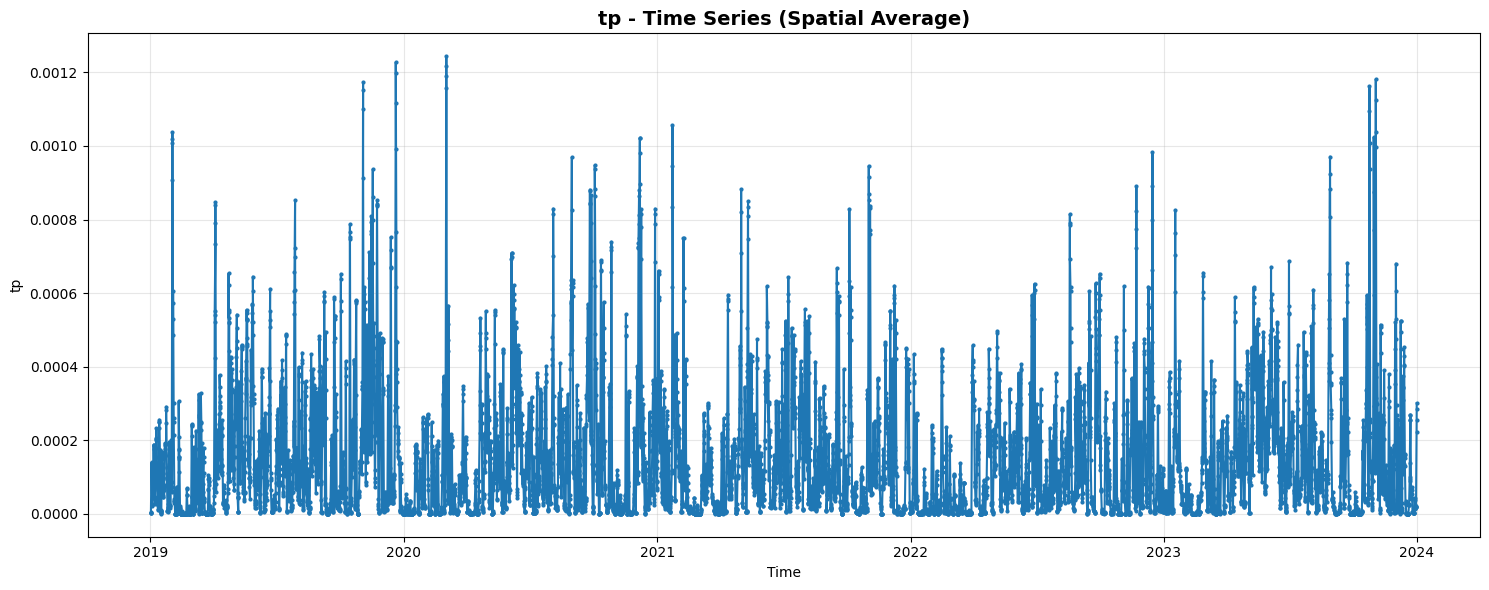


🗺️ Generating spatial distribution maps...


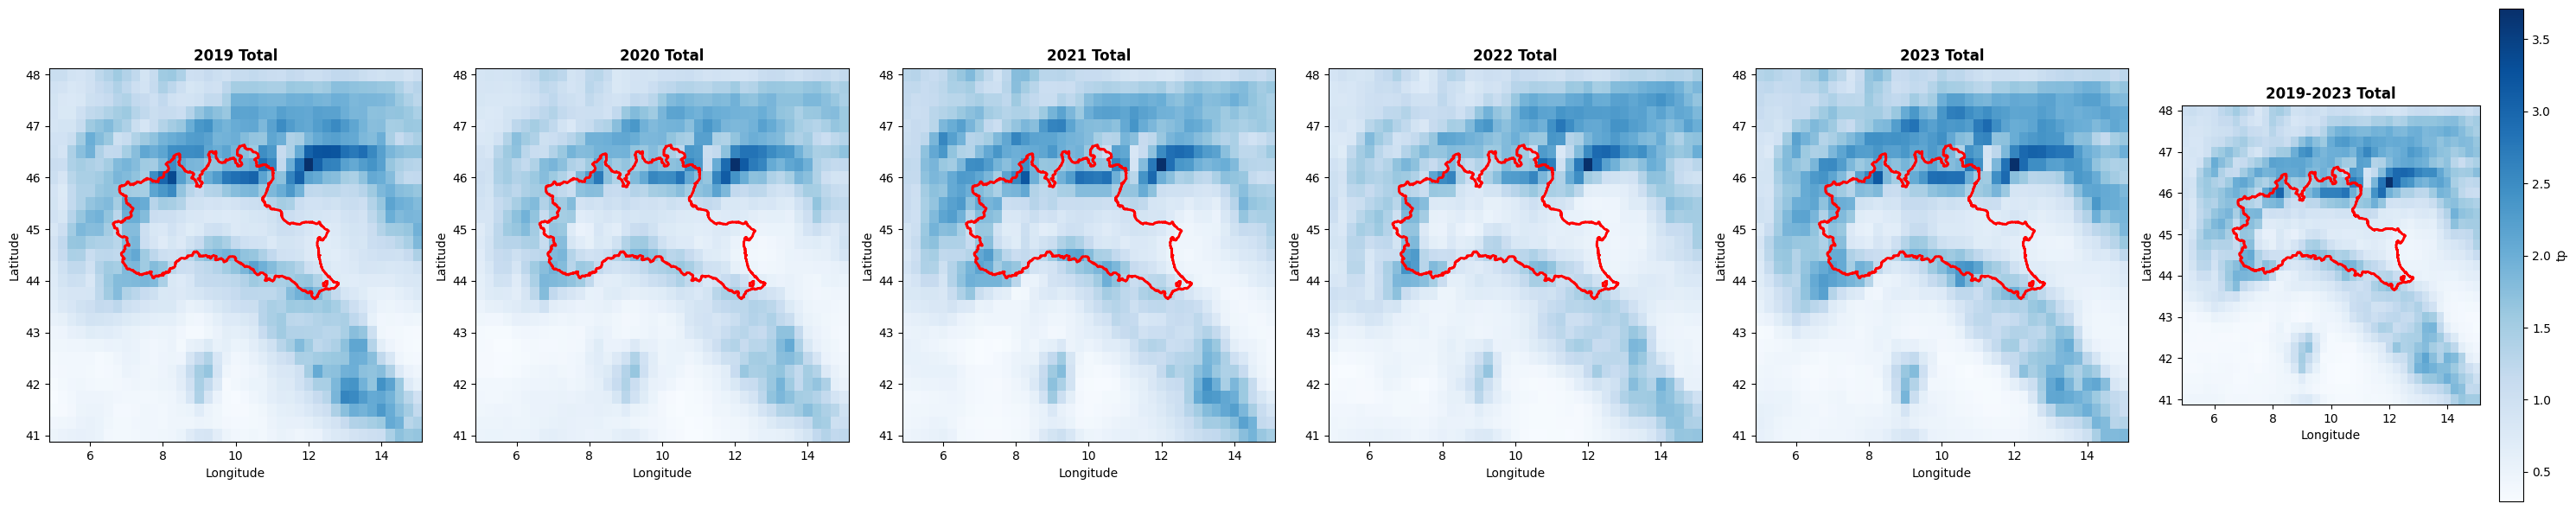


📊 Statistical Summary:
Time series statistics:
  Minimum: 0.00
  Maximum: 0.00
  Mean: 0.00
  Standard deviation: 0.00

Spatial distribution statistics (multi-year total):
  Minimum: 0.30
  Maximum: 3.71
  Mean: 1.09
  Standard deviation: 0.59


In [ ]:
# --- 4. 文件路径 ---
precip_file = "/content/drive/MyDrive/Variables/total_precipitation/data_stream-oper_stepType-accum.nc"
aoi_file = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"

# --- 5. 数据加载 ---
import os
if not os.path.exists(precip_file):
    raise FileNotFoundError(f"Precipitation file not found: {precip_file}")
if not os.path.exists(aoi_file):
    raise FileNotFoundError(f"AOI file not found: {aoi_file}")

ds = xr.open_dataset(precip_file)
aoi = gpd.read_file(aoi_file)

print(f"Dataset variables: {list(ds.data_vars)}")
print(f"Dataset coordinates: {list(ds.coords)}")

# --- 6. 变量和时间处理 ---
# 自动识别降水变量
var = [v for v in ds.data_vars if 'precip' in v.lower() or 'tp' in v.lower() or 'rain' in v.lower()][0]
print(f"Using variable: {var}")

# 自动识别时间维度
time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
if time_coords:
    time_dim = time_coords[0]
    print(f"Using time dimension: {time_dim}")
else:
    raise ValueError("No time dimension found")

# 确保时间有year属性
if not hasattr(ds[time_dim].dt, 'year'):
    ds[time_dim] = xr.decode_cf(ds)[time_dim]

years = np.unique(ds[time_dim + '.year'].values)
print(f"Years in data: {years}")

# --- 7. 时间序列图 ---
print("\n📈 Generating time series plot...")
fig, ax = plt.subplots(figsize=(15, 6))

# 计算空间平均时间序列
if 'latitude' in ds[var].dims and 'longitude' in ds[var].dims:
    ts_mean = ds[var].mean(dim=['latitude', 'longitude'])
else:
    ts_mean = ds[var].mean(dim=[dim for dim in ds[var].dims if dim != time_dim])

ts_mean.plot(ax=ax, marker='o', markersize=2)
ax.set_title(f'{var} - Time Series (Spatial Average)', fontsize=14, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 8. 空间分布图（每年+多年均值） ---
print("\n🗺️ Generating spatial distribution maps...")
n_years = len(years)
fig, axes = plt.subplots(1, n_years + 1, figsize=(5*(n_years+1), 6))

for i, year in enumerate(years):
    ax = axes[i]
    yearly_sum = ds[var].sel({time_dim: str(year)}).sum(dim=time_dim)
    im = yearly_sum.plot(ax=ax, cmap='Blues', add_colorbar=False)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{year} Total', fontsize=12, fontweight='bold')
    aoi.boundary.plot(ax=ax, color='red', linewidth=2)

# 多年总和
ax = axes[-1]
total_sum = ds[var].sum(dim=time_dim)
im = total_sum.plot(ax=ax, cmap='Blues', add_colorbar=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'{years[0]}-{years[-1]} Total', fontsize=12, fontweight='bold')
aoi.boundary.plot(ax=ax, color='red', linewidth=2)

plt.tight_layout()
plt.show()

# --- 9. 统计信息 ---
print("\n📊 Statistical Summary:")
print(f"Time series statistics:")
print(f"  Minimum: {ts_mean.min().values:.2f}")
print(f"  Maximum: {ts_mean.max().values:.2f}")
print(f"  Mean: {ts_mean.mean().values:.2f}")
print(f"  Standard deviation: {ts_mean.std().values:.2f}")

print(f"\nSpatial distribution statistics (multi-year total):")
print(f"  Minimum: {total_sum.min().values:.2f}")
print(f"  Maximum: {total_sum.max().values:.2f}")
print(f"  Mean: {total_sum.mean().values:.2f}")
print(f"  Standard deviation: {total_sum.std().values:.2f}")

In [ ]:
import xarray as xr
import numpy as np
import rasterio

def check_precipitation_data_resolution():
    """Check precipitation data resolution and compare with other variables"""

    print("🌧️ Checking precipitation data resolution...")

    # File paths
    precip_file = "/content/drive/MyDrive/Variables/total_precipitation/data_stream-oper_stepType-accum.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"

    # Load data
    ds = xr.open_dataset(precip_file)

    # Get S5P reference specifications
    with rasterio.open(s5p_reference) as src:
        s5p_crs = src.crs
        s5p_transform = src.transform
        s5p_width = src.width
        s5p_height = src.height
        s5p_bounds = src.bounds

    print(f"\n📊 S5P NO2 Reference Data:")
    print(f"   CRS: {s5p_crs}")
    print(f"   Width: {s5p_width}")
    print(f"   Height: {s5p_height}")
    print(f"   Transform: {s5p_transform}")
    print(f"   Bounds: {s5p_bounds}")

    # Check precipitation data
    print(f"\n🌧️ Precipitation Data:")
    print(f"   Variables: {list(ds.data_vars)}")
    print(f"   Coordinates: {list(ds.coords)}")
    print(f"   Dimensions: {list(ds.dims)}")

    precip_var = [v for v in ds.data_vars if 'precip' in v.lower() or 'tp' in v.lower() or 'rain' in v.lower()][0]
    precip_data = ds[precip_var]
    print(f"   Precipitation variable: {precip_var}")
    print(f"   Data shape: {precip_data.shape}")

    # Check spatial resolution
    if 'latitude' in precip_data.dims and 'longitude' in precip_data.dims:
        lat = ds['latitude']
        lon = ds['longitude']
        print(f"   Latitude range: {lat.min().values:.4f} - {lat.max().values:.4f}")
        print(f"   Longitude range: {lon.min().values:.4f} - {lon.max().values:.4f}")
        print(f"   Latitude resolution: {abs(lat[1] - lat[0]).values:.4f}°")
        print(f"   Longitude resolution: {abs(lon[1] - lon[0]).values:.4f}°")

    # Check time coverage
    time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
    time_dim = time_coords[0]

    print(f"\n📅 Time Coverage:")
    print(f"   Time dimension: {time_dim}")
    print(f"   Total time steps: {len(ds[time_dim])}")

    # Check 2019-01-01 data
    jan1_data = ds.sel({time_dim: '2019-01-01'})
    print(f"   2019-01-01 time steps: {len(jan1_data[time_dim])}")

    if len(jan1_data[time_dim]) > 0:
        print(f"   Time points on 2019-01-01:")
        for i in range(len(jan1_data[time_dim])):
            time_point = jan1_data[time_dim][i]
            print(f"     {i}: {time_point.values}")

    # Compare with other variables
    print(f"\n🔍 Comparison with other variables:")
    print(f"   BLH: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")
    print(f"   Wind: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")

    if 'latitude' in precip_data.dims and 'longitude' in precip_data.dims:
        precip_lat_res = abs(lat[1] - lat[0]).values
        precip_lon_res = abs(lon[1] - lon[0]).values

        if precip_lat_res == 0.25 and precip_lon_res == 0.25:
            print(f"   ✅ Precipitation has same resolution as BLH and Wind (0.25°)")
        else:
            print(f"   ⚠️ Precipitation resolution differs: {precip_lon_res:.4f}° x {precip_lat_res:.4f}°")

        if len(jan1_data[time_dim]) == 4:
            print(f"   ✅ Precipitation has same time coverage as BLH and Wind (4 hours/day)")
        else:
            print(f"   ⚠️ Precipitation time coverage differs: {len(jan1_data[time_dim])} hours/day")

    return ds

# Run the check
precip_ds = check_precipitation_data_resolution()

🌧️ Checking precipitation data resolution...

📊 S5P NO2 Reference Data:
   CRS: EPSG:4326
   Width: 621
   Height: 300
   Transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
   Bounds: BoundingBox(left=6.620030281745857, bottom=43.640199621659995, right=12.830058688036154, top=46.64021334450555)

🌧️ Precipitation Data:
   Variables: ['tp']
   Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
   Dimensions: ['valid_time', 'latitude', 'longitude']
   Precipitation variable: tp
   Data shape: (7304, 29, 41)
   Latitude range: 41.0000 - 48.0000
   Longitude range: 5.0000 - 15.0000
   Latitude resolution: 0.2500°
   Longitude resolution: 0.2500°

📅 Time Coverage:
   Time dimension: valid_time
   Total time steps: 7304
   2019-01-01 time steps: 4
   Time points on 2019-01-01:
     0: 2019-01-01T12:00:00.000000000
     1: 2019-01-01T13:00:00.000000000
     2: 2019-01-01T14:00:00.000000000
     3: 2019-01-01T15:00:00.000000000

🔍 Comparison with other

In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import os
from pathlib import Path

def process_precipitation_to_s5p_grid():
    """Process precipitation data to S5P grid-aligned GeoTIFF format"""

    print("🌧️ Processing precipitation data...")

    # File paths
    precip_file = "/content/drive/MyDrive/Variables/total_precipitation/data_stream-oper_stepType-accum.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
    output_dir = "/content/drive/MyDrive/Variables/total_precipitation/total_precipitation_processed"
    os.makedirs(output_dir, exist_ok=True)

    # Load data
    ds = xr.open_dataset(precip_file)

    # Get S5P reference specifications
    with rasterio.open(s5p_reference) as src:
        target_crs = src.crs
        target_transform = src.transform
        target_width = src.width
        target_height = src.height
        target_bounds = src.bounds

    print(f"   S5P target grid: {target_width} x {target_height}")

    # Identify variable and time dimension
    precip_var = [v for v in ds.data_vars if 'precip' in v.lower() or 'tp' in v.lower() or 'rain' in v.lower()][0]
    time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
    time_dim = time_coords[0]

    print(f"   Precipitation variable: {precip_var}")
    print(f"   Time dimension: {time_dim}")

    # Ensure time has year attribute
    if not hasattr(ds[time_dim].dt, 'year'):
        ds[time_dim] = xr.decode_cf(ds)[time_dim]

    # Check time coverage
    print("🔍 Checking precipitation time coverage...")
    jan1_data = ds.sel({time_dim: '2019-01-01'})
    print(f"   2019-01-01 time steps: {len(jan1_data[time_dim])}")

    # Calculate daily total precipitation (sum of 4-hourly accumulations)
    print("📅 Calculating daily total precipitation...")
    daily_precip = ds[precip_var].groupby(f'{time_dim}.date').sum(time_dim)

    print(f"   Daily precipitation shape: {daily_precip.shape}")
    print(f"   Number of days: {len(daily_precip.date)}")

    # Process by year
    years = [2019, 2020, 2021, 2022, 2023]

    for year in years:
        print(f"\n📁 Processing {year}...")

        # Filter data by year
        dates = pd.to_datetime(daily_precip.date.values)
        year_mask = dates.year == year
        yearly_data = daily_precip.sel(date=daily_precip.date[year_mask])

        n_days = len(yearly_data.date)
        print(f"   Number of days: {n_days}")

        if n_days == 0:
            print(f"   ⚠️ No data found for {year}, skipping...")
            continue

        # Create output GeoTIFF
        output_file = f"{output_dir}/precipitation_daily_{year}.tif"

        profile = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': n_days,
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': np.nan
        }

        output_data = np.full((n_days, target_height, target_width), np.nan, dtype=np.float32)

        # Process each day
        for day_idx in range(n_days):
            if day_idx % 50 == 0:
                print(f"     Processing day {day_idx + 1}/{n_days}")

            daily_slice = yearly_data.isel(date=day_idx)
            daily_array = daily_slice.values

            source_height, source_width = daily_array.shape
            source_bounds = (5.0, 41.0, 15.0, 48.0)
            source_transform = rasterio.transform.from_bounds(*source_bounds, source_width, source_height)

            reproject(
                source=daily_array,
                destination=output_data[day_idx],
                src_transform=source_transform,
                src_crs=target_crs,
                dst_transform=target_transform,
                dst_crs=target_crs,
                resampling=Resampling.bilinear,
                nodata=np.nan
            )

        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(output_data)

        print(f"  ✅ Saved: {output_file}")
        print(f"     Shape: {output_data.shape}")
        print(f"     Valid values: {np.sum(~np.isnan(output_data))}")

    # Create 5-year mean
    print(f"\n📊 Creating 5-year mean...")
    all_years_data = []

    for year in years:
        year_file = f"{output_dir}/precipitation_daily_{year}.tif"
        if os.path.exists(year_file):
            with rasterio.open(year_file) as src:
                data = src.read()
                all_years_data.append(data)

    if all_years_data:
        mean_5yr = np.nanmean(np.concatenate(all_years_data, axis=0), axis=0)

        mean_profile = profile.copy()
        mean_profile['count'] = 1

        mean_file = f"{output_dir}/precipitation_5year_mean.tif"
        with rasterio.open(mean_file, 'w', **mean_profile) as dst:
            dst.write(mean_5yr, 1)

        print(f"  ✅ Saved 5-year mean: {mean_file}")

    print(f"\n🎉 Precipitation processing completed!")
    print(f"   Output directory: {output_dir}")
    print(f"   Files created:")
    for year in years:
        print(f"     - precipitation_daily_{year}.tif")
    print(f"     - precipitation_5year_mean.tif")

# Run processing
if __name__ == "__main__":
    process_precipitation_to_s5p_grid()

🌧️ Processing precipitation data...
   S5P target grid: 621 x 300
   Precipitation variable: tp
   Time dimension: valid_time
🔍 Checking precipitation time coverage...
   2019-01-01 time steps: 4
📅 Calculating daily total precipitation...
   Daily precipitation shape: (1826, 29, 41)
   Number of days: 1826

📁 Processing 2019...
   Number of days: 365
     Processing day 1/365
     Processing day 51/365
     Processing day 101/365
     Processing day 151/365
     Processing day 201/365
     Processing day 251/365
     Processing day 301/365
     Processing day 351/365
  ✅ Saved: /content/drive/MyDrive/Variables/total_precipitation/total_precipitation_processed/precipitation_daily_2019.tif
     Shape: (365, 300, 621)
     Valid values: 67999500

📁 Processing 2020...
   Number of days: 366
     Processing day 1/366
     Processing day 51/366
     Processing day 101/366
     Processing day 151/366
     Processing day 201/366
     Processing day 251/366
     Processing day 301/366
     Proc

In [ ]:
def quality_check_precipitation_results():
    """Quality check of processed precipitation data"""

    print("🔍 Quality check of processed precipitation data...")

    output_dir = "/content/drive/MyDrive/Variables/total_precipitation/total_precipitation_processed"

    years = [2019, 2020, 2021, 2022, 2023]

    print(" Precipitation Data:")
    for year in years:
        file_path = f"{output_dir}/precipitation_daily_{year}.tif"
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read()
                print(f"   {year}: Shape {data.shape}, Valid values: {np.sum(~np.isnan(data))}")
                print(f"     Range: {np.nanmin(data):.6f} - {np.nanmax(data):.6f} m")
                print(f"     Mean: {np.nanmean(data):.6f} m")
                print(f"     Mean (mm): {np.nanmean(data)*1000:.3f} mm")

    # Check 5-year mean
    print(" 5-Year Mean:")
    mean_file = f"{output_dir}/precipitation_5year_mean.tif"
    if os.path.exists(mean_file):
        with rasterio.open(mean_file) as src:
            data = src.read(1)
            print(f"   Shape: {data.shape}")
            print(f"   Range: {np.nanmin(data):.6f} - {np.nanmax(data):.6f} m")
            print(f"   Mean: {np.nanmean(data):.6f} m")
            print(f"   Mean (mm): {np.nanmean(data)*1000:.3f} mm")

# Run quality check
quality_check_precipitation_results()

🔍 Quality check of processed precipitation data...
 Precipitation Data:
   2019: Shape (365, 300, 621), Valid values: 67999500
     Range: 0.000000 - 0.044292 m
     Mean: 0.000842 m
     Mean (mm): 0.842 mm
   2020: Shape (366, 300, 621), Valid values: 68185800
     Range: 0.000000 - 0.039863 m
     Mean: 0.000750 m
     Mean (mm): 0.750 mm
   2021: Shape (365, 300, 621), Valid values: 67999500
     Range: 0.000000 - 0.040068 m
     Mean: 0.000726 m
     Mean (mm): 0.726 mm
   2022: Shape (365, 300, 621), Valid values: 67999500
     Range: 0.000000 - 0.059683 m
     Mean: 0.000556 m
     Mean (mm): 0.556 mm
   2023: Shape (365, 300, 621), Valid values: 67999500
     Range: 0.000000 - 0.046529 m
     Mean: 0.000760 m
     Mean (mm): 0.760 mm
 5-Year Mean:
   Shape: (300, 621)
   Range: 0.000237 - 0.002013 m
   Mean: 0.000727 m
   Mean (mm): 0.727 mm


## 5.surface_pressure

Dataset variables: ['sp']
Dataset coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
Using variable: sp
Using time dimension: valid_time
Years in data: [2019 2020 2021 2022 2023]

📈 Generating time series plot...


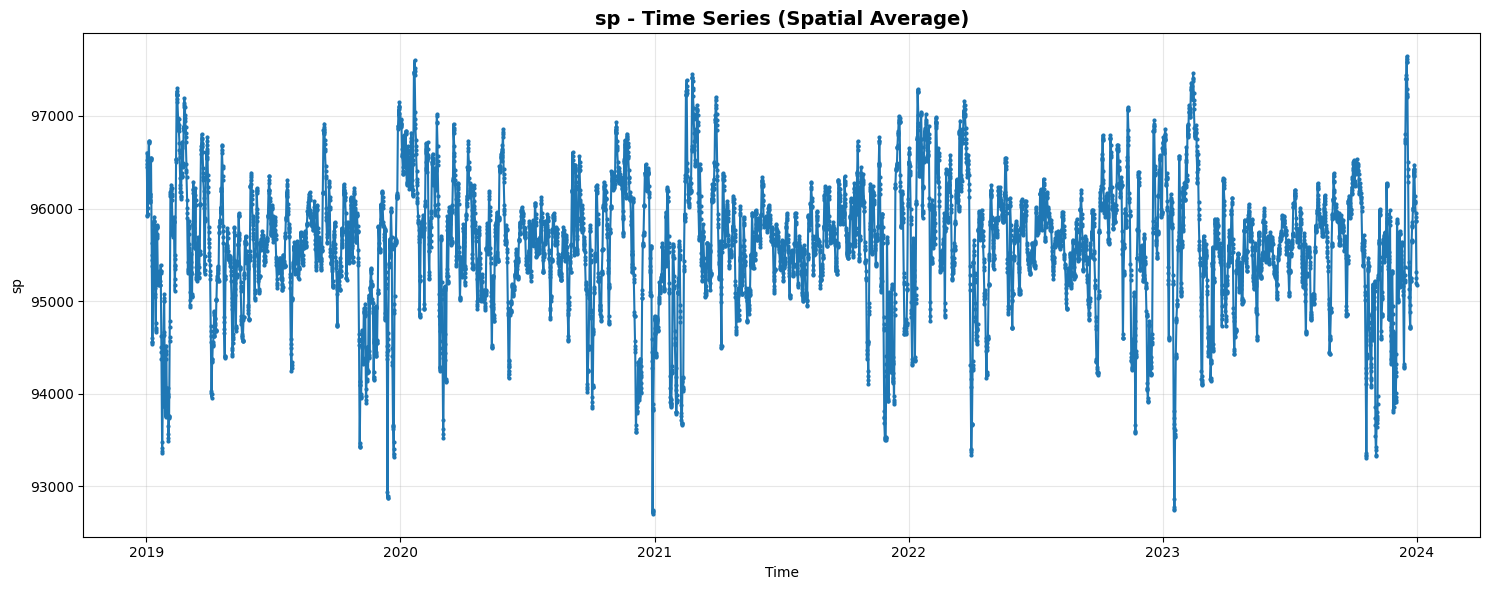


🗺️ Generating spatial distribution maps...


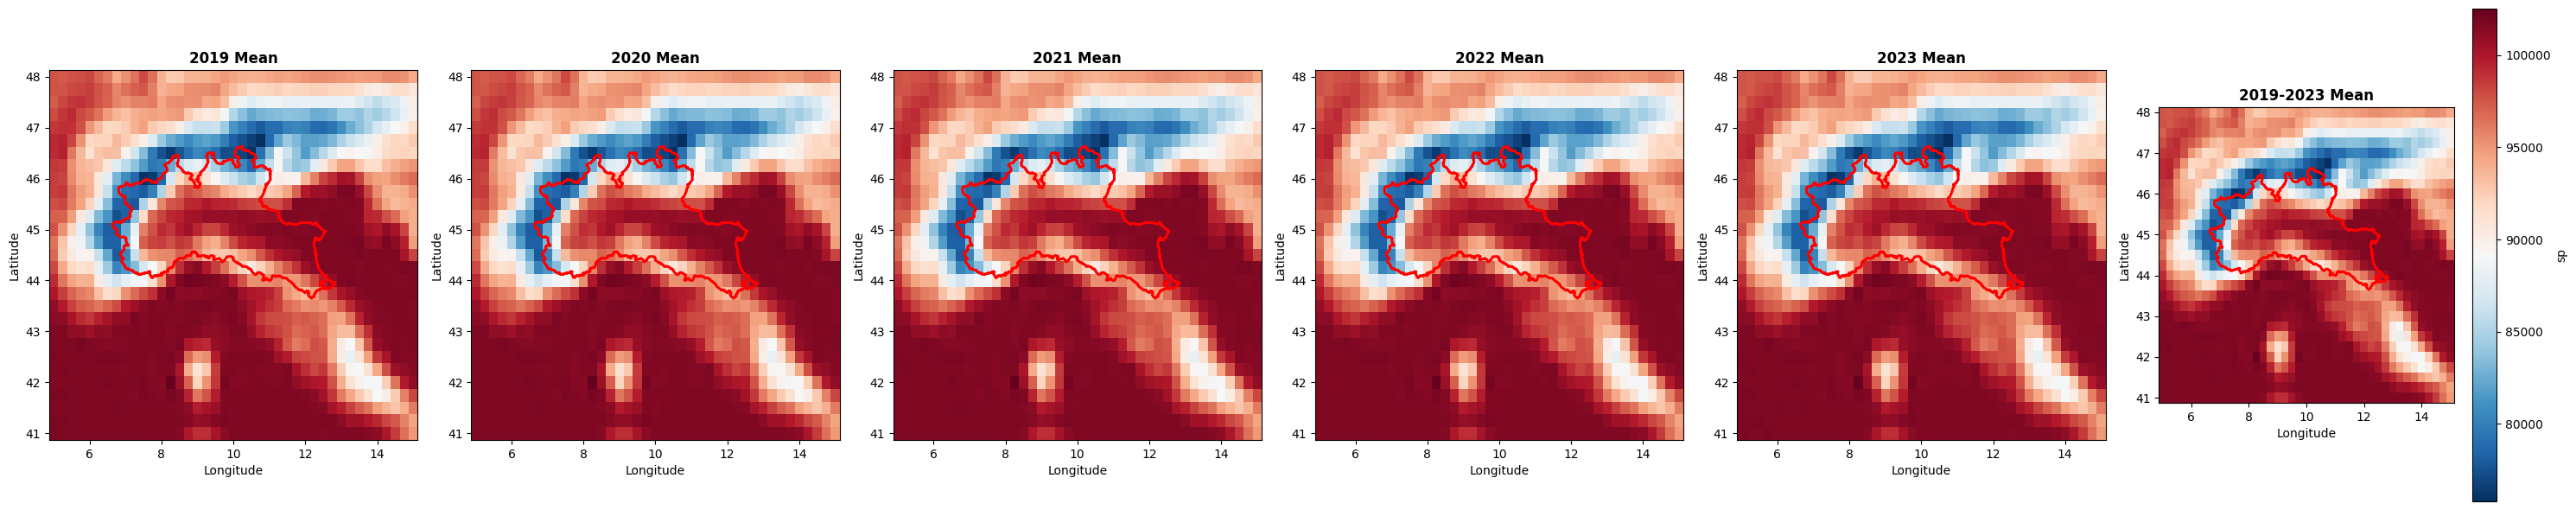


📊 Statistical Summary:
Time series statistics:
  Minimum: 92699.62
  Maximum: 97646.09
  Mean: 95609.58
  Standard deviation: 685.25

Spatial distribution statistics (5-year mean):
  Minimum: 75803.77
  Maximum: 102515.89
  Mean: 95609.59
  Standard deviation: 6602.14


In [ ]:
# --- 4. 文件路径 ---
pressure_file = "/content/drive/MyDrive/Variables/surface_pressure/data_stream-oper_stepType-instant.nc"
aoi_file = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"

# --- 5. 数据加载 ---
import os
if not os.path.exists(pressure_file):
    raise FileNotFoundError(f"Surface pressure file not found: {pressure_file}")
if not os.path.exists(aoi_file):
    raise FileNotFoundError(f"AOI file not found: {aoi_file}")

ds = xr.open_dataset(pressure_file)
aoi = gpd.read_file(aoi_file)

print(f"Dataset variables: {list(ds.data_vars)}")
print(f"Dataset coordinates: {list(ds.coords)}")

# --- 6. 变量和时间处理 ---
# 自动识别气压变量
var = [v for v in ds.data_vars if 'sp' in v.lower() or 'pressure' in v.lower() or 'ps' in v.lower()][0]
print(f"Using variable: {var}")

# 自动识别时间维度
time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
if time_coords:
    time_dim = time_coords[0]
    print(f"Using time dimension: {time_dim}")
else:
    raise ValueError("No time dimension found")

# 确保时间有year属性
if not hasattr(ds[time_dim].dt, 'year'):
    ds[time_dim] = xr.decode_cf(ds)[time_dim]

years = np.unique(ds[time_dim + '.year'].values)
print(f"Years in data: {years}")

# --- 7. 时间序列图 ---
print("\n📈 Generating time series plot...")
fig, ax = plt.subplots(figsize=(15, 6))

# 计算空间平均时间序列
if 'latitude' in ds[var].dims and 'longitude' in ds[var].dims:
    ts_mean = ds[var].mean(dim=['latitude', 'longitude'])
else:
    ts_mean = ds[var].mean(dim=[dim for dim in ds[var].dims if dim != time_dim])

ts_mean.plot(ax=ax, marker='o', markersize=2)
ax.set_title(f'{var} - Time Series (Spatial Average)', fontsize=14, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 8. 空间分布图（每年+多年均值） ---
print("\n🗺️ Generating spatial distribution maps...")
n_years = len(years)
fig, axes = plt.subplots(1, n_years + 1, figsize=(5*(n_years+1), 6))

for i, year in enumerate(years):
    ax = axes[i]
    yearly_mean = ds[var].sel({time_dim: str(year)}).mean(dim=time_dim)
    im = yearly_mean.plot(ax=ax, cmap='RdBu_r', add_colorbar=False)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{year} Mean', fontsize=12, fontweight='bold')
    aoi.boundary.plot(ax=ax, color='red', linewidth=2)

# 多年均值
ax = axes[-1]
mean_5yr = ds[var].mean(dim=time_dim)
im = mean_5yr.plot(ax=ax, cmap='RdBu_r', add_colorbar=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'{years[0]}-{years[-1]} Mean', fontsize=12, fontweight='bold')
aoi.boundary.plot(ax=ax, color='red', linewidth=2)

plt.tight_layout()
plt.show()

# --- 9. 统计信息 ---
print("\n📊 Statistical Summary:")
print(f"Time series statistics:")
print(f"  Minimum: {ts_mean.min().values:.2f}")
print(f"  Maximum: {ts_mean.max().values:.2f}")
print(f"  Mean: {ts_mean.mean().values:.2f}")
print(f"  Standard deviation: {ts_mean.std().values:.2f}")

print(f"\nSpatial distribution statistics (5-year mean):")
print(f"  Minimum: {mean_5yr.min().values:.2f}")
print(f"  Maximum: {mean_5yr.max().values:.2f}")
print(f"  Mean: {mean_5yr.mean().values:.2f}")
print(f"  Standard deviation: {mean_5yr.std().values:.2f}")

In [ ]:
import xarray as xr
import rasterio
import numpy as np
import pandas as pd
import os

def check_pressure_resolution():
    """Check surface pressure data resolution and compare with S5P reference"""

    print("🌪️ Checking surface pressure data resolution...")

    # File paths
    pressure_file = "/content/drive/MyDrive/Variables/surface_pressure/data_stream-oper_stepType-instant.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"

    # Check if files exist
    print(f"Checking file existence...")
    print(f"Pressure file exists: {os.path.exists(pressure_file)}")
    print(f"S5P reference exists: {os.path.exists(s5p_reference)}")

    try:
        # Load S5P reference data
        print("Loading S5P reference data...")
        with rasterio.open(s5p_reference) as src:
            print("📊 S5P NO2 Reference Data:")
            print(f"   CRS: {src.crs}")
            print(f"   Width: {src.width}")
            print(f"   Height: {src.height}")
            print(f"   Transform: {src.transform}")
            print(f"   Bounds: {src.bounds}")
    except Exception as e:
        print(f"Error loading S5P reference: {e}")
        return

    try:
        # Load pressure data
        print("Loading pressure data...")
        ds = xr.open_dataset(pressure_file)

        # Identify variable
        pressure_var = [v for v in ds.data_vars if 'sp' in v.lower() or 'pressure' in v.lower() or 'ps' in v.lower()][0]

        print(f"\n🌪️ Surface Pressure Data:")
        print(f"   Variables: {list(ds.data_vars)}")
        print(f"   Coordinates: {list(ds.coords)}")
        print(f"   Dimensions: {list(ds[pressure_var].dims)}")
        print(f"   Pressure variable: {pressure_var}")
        print(f"   Data shape: {ds[pressure_var].shape}")

        # Check spatial resolution
        if 'latitude' in ds.coords and 'longitude' in ds.coords:
            lat_range = f"{ds.latitude.min().values:.4f} - {ds.latitude.max().values:.4f}"
            lon_range = f"{ds.longitude.min().values:.4f} - {ds.longitude.max().values:.4f}"

            lat_res = abs(ds.latitude.values[1] - ds.latitude.values[0])
            lon_res = abs(ds.longitude.values[1] - ds.longitude.values[0])

            print(f"   Latitude range: {lat_range}")
            print(f"   Longitude range: {lon_range}")
            print(f"   Latitude resolution: {lat_res:.4f}°")
            print(f"   Longitude resolution: {lon_res:.4f}°")

        # Check time coverage
        time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
        time_dim = time_coords[0]

        print(f"\n📅 Time Coverage:")
        print(f"   Time dimension: {time_dim}")
        print(f"   Total time steps: {len(ds[time_dim])}")

        # Check specific day coverage
        jan1_data = ds.sel({time_dim: '2019-01-01'})
        print(f"   2019-01-01 time steps: {len(jan1_data[time_dim])}")

        if len(jan1_data[time_dim]) > 0:
            print("   Time points on 2019-01-01:")
            for i, time_point in enumerate(jan1_data[time_dim].values):
                print(f"     {i}: {time_point}")

        # Check time pattern
        unique_hours = []
        for time_point in ds[time_dim].values:
            hour = pd.to_datetime(time_point).hour
            if hour not in unique_hours:
                unique_hours.append(hour)

        print(f"🕐 Time pattern:")
        print(f"   Hours in data: {sorted(unique_hours)}")

        # Compare with other variables
        print(f"\n🔍 Comparison with other variables:")
        print(f"   BLH: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")
        print(f"   Wind: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")
        print(f"   Precipitation: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")
        print(f"   Temperature: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")

        # Check if pressure data matches
        if lat_res == 0.25 and lon_res == 0.25:
            print(f"   ✅ Surface pressure has same resolution as other variables (0.25°)")
        else:
            print(f"   ⚠️ Surface pressure resolution differs from other variables")

        if len(unique_hours) == 4 and set(unique_hours) == {12, 13, 14, 15}:
            print(f"   ✅ Surface pressure has same time coverage as other variables (4 hours/day)")
        else:
            print(f"   ⚠️ Surface pressure time coverage differs from other variables")

        # Check if upsampling is needed
        print(f"\n📏 Resolution comparison:")
        print(f"   Surface pressure resolution: {lat_res:.4f}° x {lon_res:.4f}°")
        print(f"   S5P resolution: 0.0100° x 0.0100°")
        print(f"   ✅ S5P resolution is finer, upsampling needed")

    except Exception as e:
        print(f"Error processing pressure data: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    check_pressure_resolution()

🌪️ Checking surface pressure data resolution...
Checking file existence...
Pressure file exists: True
S5P reference exists: True
Loading S5P reference data...
📊 S5P NO2 Reference Data:
   CRS: EPSG:4326
   Width: 621
   Height: 300
   Transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
   Bounds: BoundingBox(left=6.620030281745857, bottom=43.640199621659995, right=12.830058688036154, top=46.64021334450555)
Loading pressure data...

🌪️ Surface Pressure Data:
   Variables: ['sp']
   Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
   Dimensions: ['valid_time', 'latitude', 'longitude']
   Pressure variable: sp
   Data shape: (7304, 29, 41)
   Latitude range: 41.0000 - 48.0000
   Longitude range: 5.0000 - 15.0000
   Latitude resolution: 0.2500°
   Longitude resolution: 0.2500°

📅 Time Coverage:
   Time dimension: valid_time
   Total time steps: 7304
   2019-01-01 time steps: 4
   Time points on 2019-01-01:
     0: 2019-01-01T12:00:00.000000000
  

In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import os
from pathlib import Path

def process_surface_pressure_to_s5p_grid():
    """Process surface pressure data to S5P grid-aligned GeoTIFF format"""

    print("🌪️ Processing surface pressure data...")

    # File paths
    pressure_file = "/content/drive/MyDrive/Variables/surface_pressure/data_stream-oper_stepType-instant.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
    output_dir = "/content/drive/MyDrive/Variables/surface_pressure/surface_pressure_processed"
    os.makedirs(output_dir, exist_ok=True)

    # Load data
    ds = xr.open_dataset(pressure_file)

    # Get S5P reference specifications
    with rasterio.open(s5p_reference) as src:
        target_crs = src.crs
        target_transform = src.transform
        target_width = src.width
        target_height = src.height
        target_bounds = src.bounds

    print(f"   S5P target grid: {target_width} x {target_height}")

    # Identify variable and time dimension
    pressure_var = [v for v in ds.data_vars if 'sp' in v.lower() or 'pressure' in v.lower() or 'ps' in v.lower()][0]
    time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
    time_dim = time_coords[0]

    print(f"   Pressure variable: {pressure_var}")
    print(f"   Time dimension: {time_dim}")

    # Ensure time has year attribute
    if not hasattr(ds[time_dim].dt, 'year'):
        ds[time_dim] = xr.decode_cf(ds)[time_dim]

    # Check time coverage
    print("🔍 Checking pressure time coverage...")
    jan1_data = ds.sel({time_dim: '2019-01-01'})
    print(f"   2019-01-01 time steps: {len(jan1_data[time_dim])}")

    # Calculate daily average pressure
    print("📅 Calculating daily average pressure...")
    daily_pressure = ds[pressure_var].groupby(f'{time_dim}.date').mean(time_dim)

    print(f"   Daily pressure shape: {daily_pressure.shape}")
    print(f"   Number of days: {len(daily_pressure.date)}")

    # Process by year
    years = [2019, 2020, 2021, 2022, 2023]

    for year in years:
        print(f"\n📁 Processing {year}...")

        # Filter data by year
        dates = pd.to_datetime(daily_pressure.date.values)
        year_mask = dates.year == year
        yearly_data = daily_pressure.sel(date=daily_pressure.date[year_mask])

        n_days = len(yearly_data.date)
        print(f"   Number of days: {n_days}")

        if n_days == 0:
            print(f"   ⚠️ No data found for {year}, skipping...")
            continue

        # Create output GeoTIFF
        output_file = f"{output_dir}/pressure_daily_{year}.tif"

        profile = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': n_days,
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': np.nan
        }

        output_data = np.full((n_days, target_height, target_width), np.nan, dtype=np.float32)

        # Process each day
        for day_idx in range(n_days):
            if day_idx % 50 == 0:
                print(f"     Processing day {day_idx + 1}/{n_days}")

            daily_slice = yearly_data.isel(date=day_idx)
            daily_array = daily_slice.values

            source_height, source_width = daily_array.shape
            source_bounds = (5.0, 41.0, 15.0, 48.0)
            source_transform = rasterio.transform.from_bounds(*source_bounds, source_width, source_height)

            reproject(
                source=daily_array,
                destination=output_data[day_idx],
                src_transform=source_transform,
                src_crs=target_crs,
                dst_transform=target_transform,
                dst_crs=target_crs,
                resampling=Resampling.bilinear,
                nodata=np.nan
            )

        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(output_data)

        print(f"  ✅ Saved: {output_file}")
        print(f"     Shape: {output_data.shape}")
        print(f"     Valid values: {np.sum(~np.isnan(output_data))}")

    # Create 5-year mean
    print(f"\n📊 Creating 5-year mean...")
    all_years_data = []

    for year in years:
        year_file = f"{output_dir}/pressure_daily_{year}.tif"
        if os.path.exists(year_file):
            with rasterio.open(year_file) as src:
                data = src.read()
                all_years_data.append(data)

    if all_years_data:
        mean_5yr = np.nanmean(np.concatenate(all_years_data, axis=0), axis=0)

        mean_profile = profile.copy()
        mean_profile['count'] = 1

        mean_file = f"{output_dir}/pressure_5year_mean.tif"
        with rasterio.open(mean_file, 'w', **mean_profile) as dst:
            dst.write(mean_5yr, 1)

        print(f"  ✅ Saved 5-year mean: {mean_file}")

    print(f"\n🎉 Surface pressure processing completed!")
    print(f"   Output directory: {output_dir}")
    print(f"   Files created:")
    for year in years:
        print(f"     - pressure_daily_{year}.tif")
    print(f"     - pressure_5year_mean.tif")

# Run processing
if __name__ == "__main__":
    process_surface_pressure_to_s5p_grid()

🌪️ Processing surface pressure data...
   S5P target grid: 621 x 300
   Pressure variable: sp
   Time dimension: valid_time
🔍 Checking pressure time coverage...
   2019-01-01 time steps: 4
📅 Calculating daily average pressure...
   Daily pressure shape: (1826, 29, 41)
   Number of days: 1826

📁 Processing 2019...
   Number of days: 365
     Processing day 1/365
     Processing day 51/365
     Processing day 101/365
     Processing day 151/365
     Processing day 201/365
     Processing day 251/365
     Processing day 301/365
     Processing day 351/365
  ✅ Saved: /content/drive/MyDrive/Variables/surface_pressure/surface_pressure_processed/pressure_daily_2019.tif
     Shape: (365, 300, 621)
     Valid values: 67999500

📁 Processing 2020...
   Number of days: 366
     Processing day 1/366
     Processing day 51/366
     Processing day 101/366
     Processing day 151/366
     Processing day 201/366
     Processing day 251/366
     Processing day 301/366
     Processing day 351/366
  ✅ Sav

In [ ]:
import rasterio
import numpy as np
import os

def quality_check_pressure_results():
    """Quality check of processed surface pressure data"""

    print("Quality check of processed surface pressure data...")

    output_dir = "/content/drive/MyDrive/Variables/surface_pressure/surface_pressure_processed"
    years = [2019, 2020, 2021, 2022, 2023]

    print("📊 Surface Pressure Data:")

    # Check yearly data
    for year in years:
        file_path = f"{output_dir}/pressure_daily_{year}.tif"
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read()
                valid_mask = ~np.isnan(data)
                valid_data = data[valid_mask]

                print(f"  {year}: Shape {data.shape}, Valid values: {np.sum(valid_mask)}")
                print(f"    Range: {valid_data.min():.2f} - {valid_data.max():.2f} Pa")
                print(f"    Mean: {valid_data.mean():.2f} Pa")
                print(f"    Std: {valid_data.std():.2f} Pa")
        else:
            print(f"  {year}: File not found")

    # Check 5-year mean
    mean_file = f"{output_dir}/pressure_5year_mean.tif"
    if os.path.exists(mean_file):
        with rasterio.open(mean_file) as src:
            mean_data = src.read(1)  # Read first band
            valid_mask = ~np.isnan(mean_data)
            valid_mean = mean_data[valid_mask]

            print(f"\n📊 5-Year Mean Surface Pressure:")
            print(f"  Shape: {mean_data.shape}")
            print(f"  Range: {valid_mean.min():.2f} - {valid_mean.max():.2f} Pa")
            print(f"  Mean: {valid_mean.mean():.2f} Pa")
            print(f"  Std: {valid_mean.std():.2f} Pa")

    print(f"\n🎉 Quality check completed!")

if __name__ == "__main__":
    quality_check_pressure_results()

Quality check of processed surface pressure data...
📊 Surface Pressure Data:
  2019: Shape (365, 300, 621), Valid values: 67999500
    Range: 73008.01 - 104015.43 Pa
    Mean: 92901.09 Pa
    Std: 7806.45 Pa
  2020: Shape (366, 300, 621), Valid values: 68185800
    Range: 72678.37 - 104350.77 Pa
    Mean: 93055.29 Pa
    Std: 7830.58 Pa
  2021: Shape (365, 300, 621), Valid values: 67999500
    Range: 73393.45 - 104367.69 Pa
    Mean: 92969.65 Pa
    Std: 7831.40 Pa
  2022: Shape (365, 300, 621), Valid values: 67999500
    Range: 73712.13 - 104026.29 Pa
    Mean: 93112.19 Pa
    Std: 7804.91 Pa
  2023: Shape (365, 300, 621), Valid values: 67999500
    Range: 72895.12 - 104251.72 Pa
    Mean: 92927.84 Pa
    Std: 7796.28 Pa

📊 5-Year Mean Surface Pressure:
  Shape: (300, 621)
  Range: 75930.61 - 102081.04 Pa
  Mean: 92993.23 Pa
  Std: 7778.74 Pa

🎉 Quality check completed!


## 6.surface_net_thermal_radiation

Dataset variables: ['str']
Dataset coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
Using variable: str
Using time dimension: valid_time
Years in data: [2019 2020 2021 2022 2023]

📈 Generating time series plot...


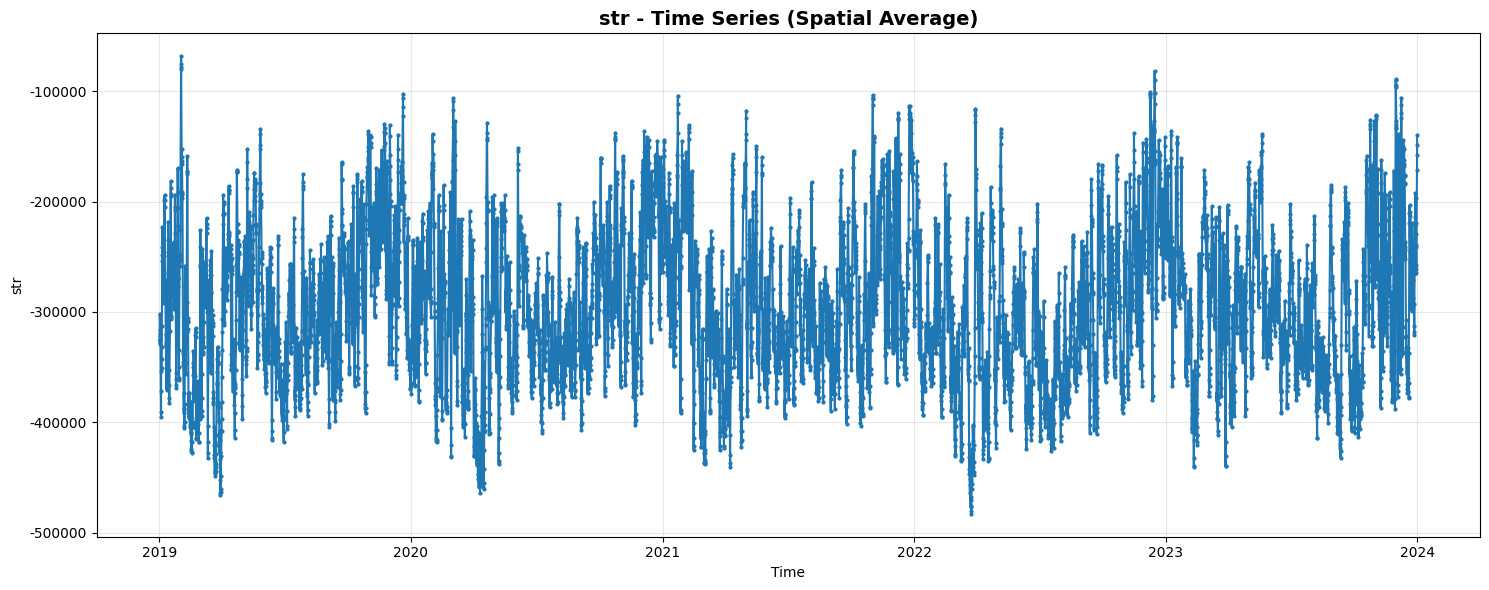


🗺️ Generating spatial distribution maps...


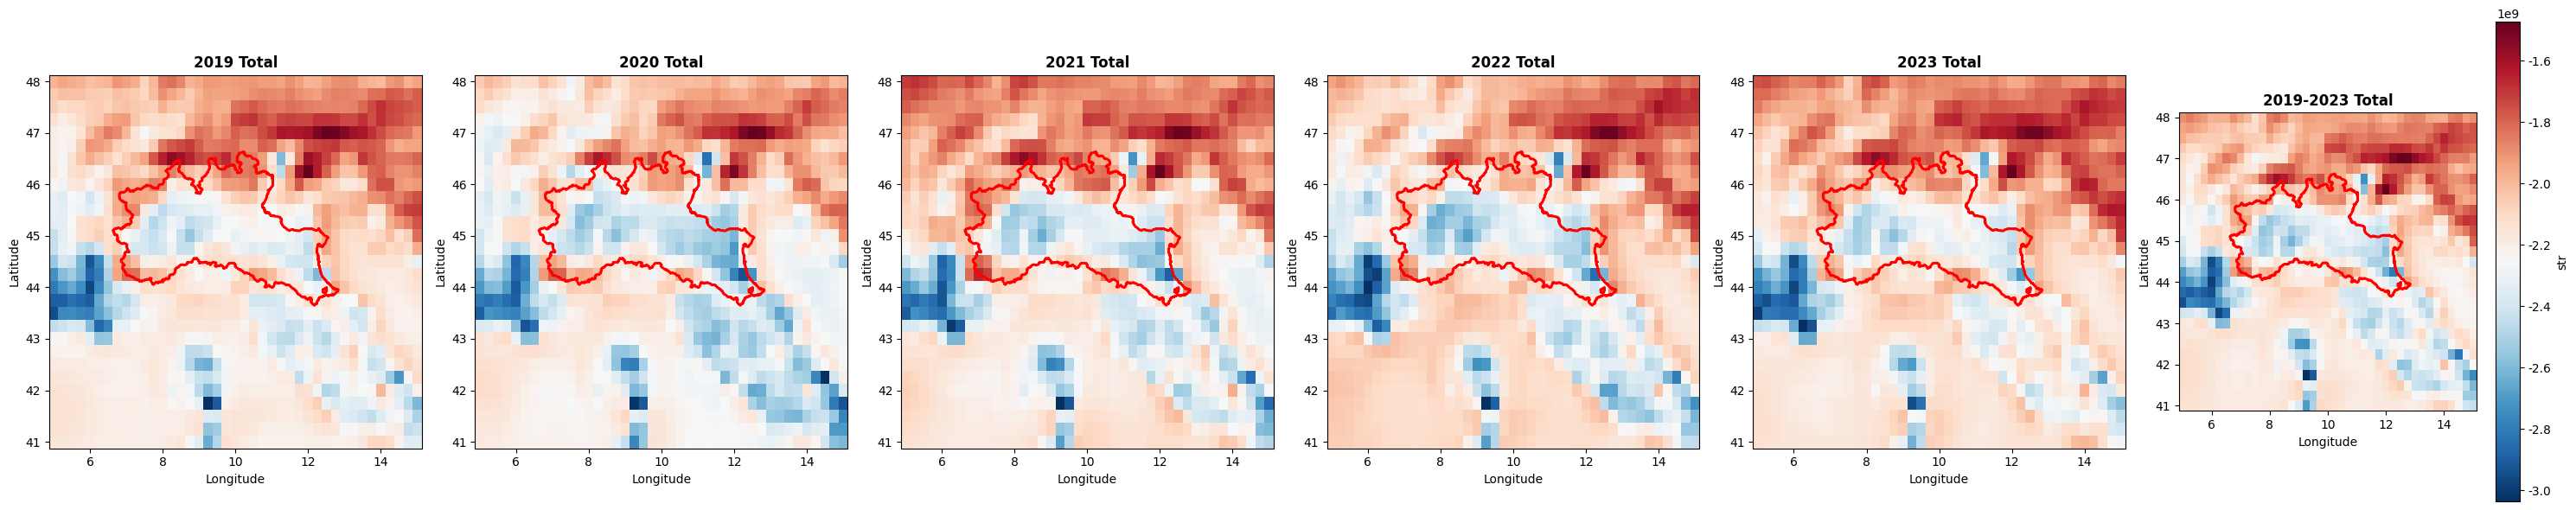


📊 Statistical Summary:
Time series statistics:
  Minimum: -482928.28
  Maximum: -68353.90
  Mean: -294950.12
  Standard deviation: 69459.14

Spatial distribution statistics (multi-year total):
  Minimum: -3036128256.00
  Maximum: -1472384768.00
  Mean: -2154318080.00
  Standard deviation: 233206544.00


In [ ]:
# --- 4. 文件路径 ---
radiation_file = "/content/drive/MyDrive/Variables/surface_net_thermal_radiation/data_stream-oper_stepType-accum.nc"
aoi_file = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"

# --- 5. 数据加载 ---
import os
if not os.path.exists(radiation_file):
    raise FileNotFoundError(f"Surface net thermal radiation file not found: {radiation_file}")
if not os.path.exists(aoi_file):
    raise FileNotFoundError(f"AOI file not found: {aoi_file}")

ds = xr.open_dataset(radiation_file)
aoi = gpd.read_file(aoi_file)

print(f"Dataset variables: {list(ds.data_vars)}")
print(f"Dataset coordinates: {list(ds.coords)}")

# --- 6. 变量和时间处理 ---
# 自动识别辐射变量
var = [v for v in ds.data_vars if 'str' in v.lower() or 'radiation' in v.lower() or 'thermal' in v.lower()][0]
print(f"Using variable: {var}")

# 自动识别时间维度
time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
if time_coords:
    time_dim = time_coords[0]
    print(f"Using time dimension: {time_dim}")
else:
    raise ValueError("No time dimension found")

# 确保时间有year属性
if not hasattr(ds[time_dim].dt, 'year'):
    ds[time_dim] = xr.decode_cf(ds)[time_dim]

years = np.unique(ds[time_dim + '.year'].values)
print(f"Years in data: {years}")

# --- 7. 时间序列图 ---
print("\n📈 Generating time series plot...")
fig, ax = plt.subplots(figsize=(15, 6))

# 计算空间平均时间序列
if 'latitude' in ds[var].dims and 'longitude' in ds[var].dims:
    ts_mean = ds[var].mean(dim=['latitude', 'longitude'])
else:
    ts_mean = ds[var].mean(dim=[dim for dim in ds[var].dims if dim != time_dim])

ts_mean.plot(ax=ax, marker='o', markersize=2)
ax.set_title(f'{var} - Time Series (Spatial Average)', fontsize=14, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 8. 空间分布图（每年+多年均值） ---
print("\n🗺️ Generating spatial distribution maps...")
n_years = len(years)
fig, axes = plt.subplots(1, n_years + 1, figsize=(5*(n_years+1), 6))

for i, year in enumerate(years):
    ax = axes[i]
    yearly_sum = ds[var].sel({time_dim: str(year)}).sum(dim=time_dim)
    im = yearly_sum.plot(ax=ax, cmap='RdBu_r', add_colorbar=False)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{year} Total', fontsize=12, fontweight='bold')
    aoi.boundary.plot(ax=ax, color='red', linewidth=2)

# 多年总和
ax = axes[-1]
total_sum = ds[var].sum(dim=time_dim)
im = total_sum.plot(ax=ax, cmap='RdBu_r', add_colorbar=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'{years[0]}-{years[-1]} Total', fontsize=12, fontweight='bold')
aoi.boundary.plot(ax=ax, color='red', linewidth=2)

plt.tight_layout()
plt.show()

# --- 9. 统计信息 ---
print("\n📊 Statistical Summary:")
print(f"Time series statistics:")
print(f"  Minimum: {ts_mean.min().values:.2f}")
print(f"  Maximum: {ts_mean.max().values:.2f}")
print(f"  Mean: {ts_mean.mean().values:.2f}")
print(f"  Standard deviation: {ts_mean.std().values:.2f}")

print(f"\nSpatial distribution statistics (multi-year total):")
print(f"  Minimum: {total_sum.min().values:.2f}")
print(f"  Maximum: {total_sum.max().values:.2f}")
print(f"  Mean: {total_sum.mean().values:.2f}")
print(f"  Standard deviation: {total_sum.std().values:.2f}")

In [ ]:
import xarray as xr
import rasterio
import numpy as np
import pandas as pd
import os

def check_thermal_radiation_resolution():
    """Check thermal radiation data resolution and compare with S5P reference"""

    print("🌡️ Checking thermal radiation data resolution...")

    # File paths
    radiation_file = "/content/drive/MyDrive/Variables/surface_net_thermal_radiation/data_stream-oper_stepType-accum.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"

    # Check if files exist
    print(f"Checking file existence...")
    print(f"Thermal radiation file exists: {os.path.exists(radiation_file)}")
    print(f"S5P reference exists: {os.path.exists(s5p_reference)}")

    try:
        # Load S5P reference data
        print("Loading S5P reference data...")
        with rasterio.open(s5p_reference) as src:
            print("📊 S5P NO2 Reference Data:")
            print(f"   CRS: {src.crs}")
            print(f"   Width: {src.width}")
            print(f"   Height: {src.height}")
            print(f"   Transform: {src.transform}")
            print(f"   Bounds: {src.bounds}")
    except Exception as e:
        print(f"Error loading S5P reference: {e}")
        return

    try:
        # Load thermal radiation data
        print("Loading thermal radiation data...")
        ds = xr.open_dataset(radiation_file)

        # Identify variable
        radiation_var = [v for v in ds.data_vars if 'str' in v.lower() or 'radiation' in v.lower() or 'thermal' in v.lower()][0]

        print(f" Thermal Radiation Data:")
        print(f"   Variables: {list(ds.data_vars)}")
        print(f"   Coordinates: {list(ds.coords)}")
        print(f"   Dimensions: {list(ds[radiation_var].dims)}")
        print(f"   Thermal radiation variable: {radiation_var}")
        print(f"   Data shape: {ds[radiation_var].shape}")

        # Check spatial resolution
        if 'latitude' in ds.coords and 'longitude' in ds.coords:
            lat_range = f"{ds.latitude.min().values:.4f} - {ds.latitude.max().values:.4f}"
            lon_range = f"{ds.longitude.min().values:.4f} - {ds.longitude.max().values:.4f}"

            lat_res = abs(ds.latitude.values[1] - ds.latitude.values[0])
            lon_res = abs(ds.longitude.values[1] - ds.longitude.values[0])

            print(f"   Latitude range: {lat_range}")
            print(f"   Longitude range: {lon_range}")
            print(f"   Latitude resolution: {lat_res:.4f}°")
            print(f"   Longitude resolution: {lon_res:.4f}°")

        # Check time coverage
        time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
        time_dim = time_coords[0]

        print(f"\n📅 Time Coverage:")
        print(f"   Time dimension: {time_dim}")
        print(f"   Total time steps: {len(ds[time_dim])}")

        # Check specific day coverage
        jan1_data = ds.sel({time_dim: '2019-01-01'})
        print(f"   2019-01-01 time steps: {len(jan1_data[time_dim])}")

        if len(jan1_data[time_dim]) > 0:
            print("   Time points on 2019-01-01:")
            for i, time_point in enumerate(jan1_data[time_dim].values):
                print(f"     {i}: {time_point}")

        # Check time pattern
        unique_hours = []
        for time_point in ds[time_dim].values:
            hour = pd.to_datetime(time_point).hour
            if hour not in unique_hours:
                unique_hours.append(hour)

        print(f"🕐 Time pattern:")
        print(f"   Hours in data: {sorted(unique_hours)}")

        # Check data type (accumulated vs instant)
        print(f" Data Type Analysis:")
        print(f"   File type: {os.path.basename(radiation_file)}")
        if 'accum' in radiation_file.lower():
            print(f"   ✅ Accumulated data type detected")
            print(f"   📅 Will calculate daily totals by summing")
        else:
            print(f"   ⚠️ Instant data type detected")
            print(f"   📅 Will calculate daily averages")

        # Compare with other variables
        print(f"\n🔍 Comparison with other variables:")
        print(f"   BLH: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")
        print(f"   Wind: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")
        print(f"   Precipitation: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")
        print(f"   Temperature: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")
        print(f"   Pressure: 0.25° x 0.25°, 4 hours/day (12:00-15:00)")

        # Check if thermal radiation data matches
        if lat_res == 0.25 and lon_res == 0.25:
            print(f"   ✅ Thermal radiation has same resolution as other variables (0.25°)")
        else:
            print(f"   ⚠️ Thermal radiation resolution differs from other variables")

        if len(unique_hours) == 4 and set(unique_hours) == {12, 13, 14, 15}:
            print(f"   ✅ Thermal radiation has same time coverage as other variables (4 hours/day)")
        else:
            print(f"   ⚠️ Thermal radiation time coverage differs from other variables")

        # Check if upsampling is needed
        print(f"\n📏 Resolution comparison:")
        print(f"   Thermal radiation resolution: {lat_res:.4f}° x {lon_res:.4f}°")
        print(f"   S5P resolution: 0.0100° x 0.0100°")
        print(f"   ✅ S5P resolution is finer, upsampling needed")

    except Exception as e:
        print(f"Error processing thermal radiation data: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    check_thermal_radiation_resolution()

🌡️ Checking thermal radiation data resolution...
Checking file existence...
Thermal radiation file exists: True
S5P reference exists: True
Loading S5P reference data...
📊 S5P NO2 Reference Data:
   CRS: EPSG:4326
   Width: 621
   Height: 300
   Transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
   Bounds: BoundingBox(left=6.620030281745857, bottom=43.640199621659995, right=12.830058688036154, top=46.64021334450555)
Loading thermal radiation data...
 Thermal Radiation Data:
   Variables: ['str']
   Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
   Dimensions: ['valid_time', 'latitude', 'longitude']
   Thermal radiation variable: str
   Data shape: (7304, 29, 41)
   Latitude range: 41.0000 - 48.0000
   Longitude range: 5.0000 - 15.0000
   Latitude resolution: 0.2500°
   Longitude resolution: 0.2500°

📅 Time Coverage:
   Time dimension: valid_time
   Total time steps: 7304
   2019-01-01 time steps: 4
   Time points on 2019-01-01:
     0: 2019

In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import os
import pandas as pd

def process_thermal_radiation_to_s5p_grid():
    """Process surface net thermal radiation data to S5P grid-aligned GeoTIFF format"""

    print("🌡️ Processing surface net thermal radiation data...")

    # File paths
    radiation_file = "/content/drive/MyDrive/Variables/surface_net_thermal_radiation/data_stream-oper_stepType-accum.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
    output_dir = "/content/drive/MyDrive/Variables/surface_net_thermal_radiation/thermal_radiation_processed"
    os.makedirs(output_dir, exist_ok=True)

    # Load data
    ds = xr.open_dataset(radiation_file)

    # Get S5P reference specifications
    with rasterio.open(s5p_reference) as src:
        target_crs = src.crs
        target_transform = src.transform
        target_width = src.width
        target_height = src.height

    print(f"   S5P target grid: {target_width} x {target_height}")

    # Identify variable and time dimension
    radiation_var = [v for v in ds.data_vars if 'str' in v.lower() or 'radiation' in v.lower() or 'thermal' in v.lower()][0]
    time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
    time_dim = time_coords[0]

    print(f"   Thermal radiation variable: {radiation_var}")
    print(f"   Time dimension: {time_dim}")

    # Ensure time has year attribute
    if not hasattr(ds[time_dim].dt, 'year'):
        ds[time_dim] = xr.decode_cf(ds)[time_dim]

    # Check time coverage
    print("🔍 Checking thermal radiation time coverage...")
    jan1_data = ds.sel({time_dim: '2019-01-01'})
    print(f"   2019-01-01 time steps: {len(jan1_data[time_dim])}")

    # Calculate daily total thermal radiation (accumulated type)
    print("📅 Calculating daily total thermal radiation...")
    daily_radiation = ds[radiation_var].groupby(f'{time_dim}.date').sum(time_dim)

    print(f"   Daily radiation shape: {daily_radiation.shape}")
    print(f"   Number of days: {len(daily_radiation.date)}")

    # Process by year
    years = [2019, 2020, 2021, 2022, 2023]

    for year in years:
        print(f"\n📁 Processing {year}...")

        # Filter data by year
        dates = pd.to_datetime(daily_radiation.date.values)
        year_mask = dates.year == year
        yearly_data = daily_radiation.sel(date=daily_radiation.date[year_mask])

        n_days = len(yearly_data.date)
        print(f"   Number of days: {n_days}")

        if n_days == 0:
            print(f"   ⚠️ No data found for {year}, skipping...")
            continue

        # Create output GeoTIFF
        output_file = f"{output_dir}/thermal_radiation_daily_{year}.tif"

        profile = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': n_days,
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': np.nan
        }

        output_data = np.full((n_days, target_height, target_width), np.nan, dtype=np.float32)

        # Process each day
        for day_idx in range(n_days):
            if day_idx % 50 == 0:
                print(f"     Processing day {day_idx + 1}/{n_days}")

            daily_slice = yearly_data.isel(date=day_idx)
            daily_array = daily_slice.values

            source_height, source_width = daily_array.shape
            source_bounds = (5.0, 41.0, 15.0, 48.0)
            source_transform = rasterio.transform.from_bounds(*source_bounds, source_width, source_height)

            reproject(
                source=daily_array,
                destination=output_data[day_idx],
                src_transform=source_transform,
                src_crs=target_crs,
                dst_transform=target_transform,
                dst_crs=target_crs,
                resampling=Resampling.bilinear,
                nodata=np.nan
            )

        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(output_data)

        print(f"  ✅ Saved: {output_file}")
        print(f"     Shape: {output_data.shape}")
        print(f"     Valid values: {np.sum(~np.isnan(output_data))}")

    # Create 5-year mean
    print(f"\n📊 Creating 5-year mean...")
    all_years_data = []

    for year in years:
        year_file = f"{output_dir}/thermal_radiation_daily_{year}.tif"
        if os.path.exists(year_file):
            with rasterio.open(year_file) as src:
                data = src.read()
                all_years_data.append(data)

    if all_years_data:
        mean_5yr = np.nanmean(np.concatenate(all_years_data, axis=0), axis=0)

        mean_profile = profile.copy()
        mean_profile['count'] = 1

        mean_file = f"{output_dir}/thermal_radiation_5year_mean.tif"
        with rasterio.open(mean_file, 'w', **mean_profile) as dst:
            dst.write(mean_5yr, 1)

        print(f"  ✅ Saved 5-year mean: {mean_file}")

    print(f"\n🎉 Thermal radiation processing completed!")
    print(f"   Output directory: {output_dir}")
    print(f"   Files created:")
    for year in years:
        print(f"     - thermal_radiation_daily_{year}.tif")
    print(f"     - thermal_radiation_5year_mean.tif")

# Run processing
if __name__ == "__main__":
    process_thermal_radiation_to_s5p_grid()

🌡️ Processing surface net thermal radiation data...
   S5P target grid: 621 x 300
   Thermal radiation variable: str
   Time dimension: valid_time
🔍 Checking thermal radiation time coverage...
   2019-01-01 time steps: 4
📅 Calculating daily total thermal radiation...
   Daily radiation shape: (1826, 29, 41)
   Number of days: 1826

📁 Processing 2019...
   Number of days: 365
     Processing day 1/365
     Processing day 51/365
     Processing day 101/365
     Processing day 151/365
     Processing day 201/365
     Processing day 251/365
     Processing day 301/365
     Processing day 351/365
  ✅ Saved: /content/drive/MyDrive/Variables/surface_net_thermal_radiation/thermal_radiation_processed/thermal_radiation_daily_2019.tif
     Shape: (365, 300, 621)
     Valid values: 67999500

📁 Processing 2020...
   Number of days: 366
     Processing day 1/366
     Processing day 51/366
     Processing day 101/366
     Processing day 151/366
     Processing day 201/366
     Processing day 251/366


In [ ]:
import rasterio
import numpy as np
import os

def quality_check_thermal_radiation_results():
    """Quality check of processed thermal radiation data"""

    print("Quality check of processed thermal radiation data...")

    output_dir = "/content/drive/MyDrive/Variables/surface_net_thermal_radiation/thermal_radiation_processed"
    years = [2019, 2020, 2021, 2022, 2023]

    print("📊 Thermal Radiation Data:")

    # Check yearly data
    for year in years:
        file_path = f"{output_dir}/thermal_radiation_daily_{year}.tif"
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read()
                valid_mask = ~np.isnan(data)
                valid_data = data[valid_mask]

                print(f"  {year}: Shape {data.shape}, Valid values: {np.sum(valid_mask)}")
                print(f"    Range: {valid_data.min():.2f} - {valid_data.max():.2f} J/m²")
                print(f"    Mean: {valid_data.mean():.2f} J/m²")
                print(f"    Std: {valid_data.std():.2f} J/m²")
        else:
            print(f"  {year}: File not found")

    # Check 5-year mean
    mean_file = f"{output_dir}/thermal_radiation_5year_mean.tif"
    if os.path.exists(mean_file):
        with rasterio.open(mean_file) as src:
            mean_data = src.read(1)  # Read first band
            valid_mask = ~np.isnan(mean_data)
            valid_mean = mean_data[valid_mask]

            print(f"\n📊 5-Year Mean Thermal Radiation:")
            print(f"  Shape: {mean_data.shape}")
            print(f"  Range: {valid_mean.min():.2f} - {valid_mean.max():.2f} J/m²")
            print(f"  Mean: {valid_mean.mean():.2f} J/m²")
            print(f"  Std: {valid_mean.std():.2f} J/m²")

    print(f"\n🎉 Quality check completed!")

if __name__ == "__main__":
    quality_check_thermal_radiation_results()

Quality check of processed thermal radiation data...
📊 Thermal Radiation Data:
  2019: Shape (365, 300, 621), Valid values: 67999500
    Range: -2719483.75 - 283427.75 J/m²
    Mean: -1158469.25 J/m²
    Std: 493421.19 J/m²
  2020: Shape (366, 300, 621), Valid values: 68185800
    Range: -2791354.00 - 278416.06 J/m²
    Mean: -1179054.12 J/m²
    Std: 471839.44 J/m²
  2021: Shape (365, 300, 621), Valid values: 67999500
    Range: -2796867.50 - 245693.66 J/m²
    Mean: -1166398.38 J/m²
    Std: 481539.38 J/m²
  2022: Shape (365, 300, 621), Valid values: 67999500
    Range: -3236315.25 - 201587.05 J/m²
    Mean: -1253336.12 J/m²
    Std: 483410.44 J/m²
  2023: Shape (365, 300, 621), Valid values: 67999500
    Range: -2752686.75 - 184941.17 J/m²
    Mean: -1179486.62 J/m²
    Std: 469501.47 J/m²

📊 5-Year Mean Thermal Radiation:
  Shape: (300, 621)
  Range: -1535751.62 - -810324.94 J/m²
  Mean: -1187344.75 J/m²
  Std: 109679.96 J/m²

🎉 Quality check completed!


## 7.surface_net_solar_radiation_clearsky

In [ ]:
# --- 1. 安装依赖 ---
!pip install xarray netCDF4 matplotlib geopandas rioxarray --quiet

# --- 2. 挂载 Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 3. 导入库 ---
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


Dataset variables: ['ssrc']
Dataset coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
Using variable: ssrc
Using time dimension: valid_time
Years in data: [2019 2020 2021 2022 2023]

📈 Generating time series plot...


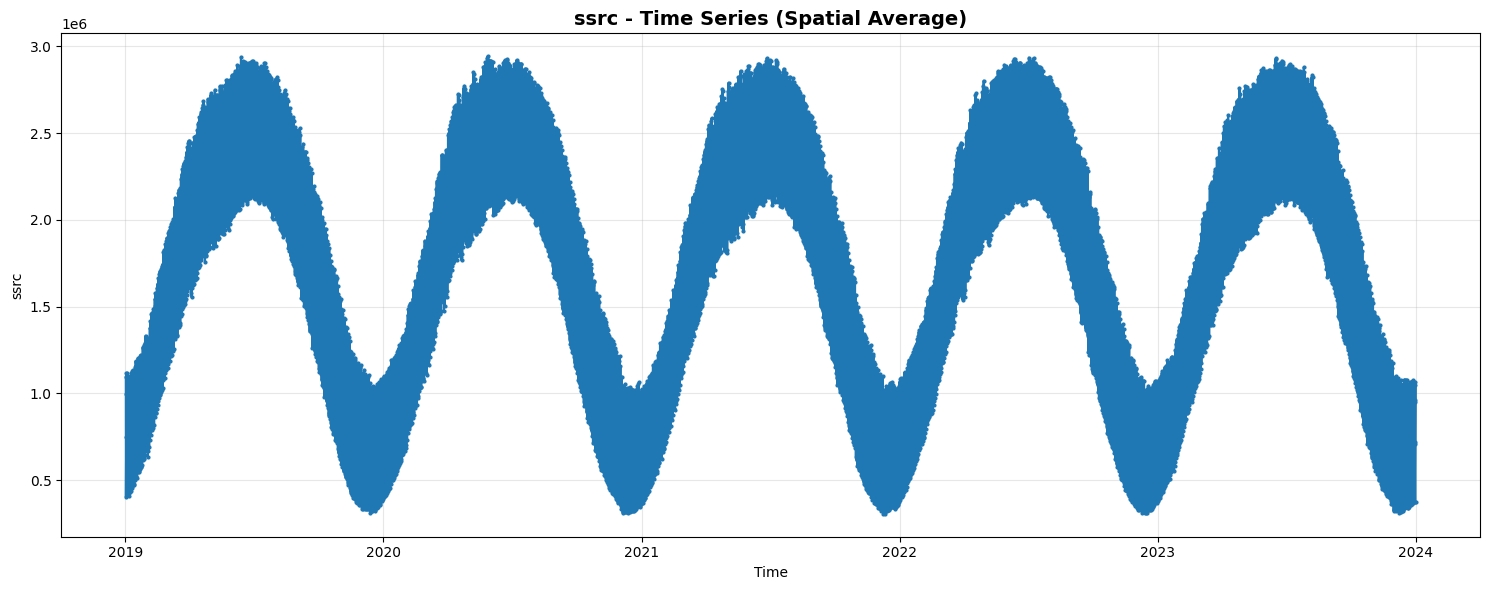


🗺️ Generating spatial distribution maps...


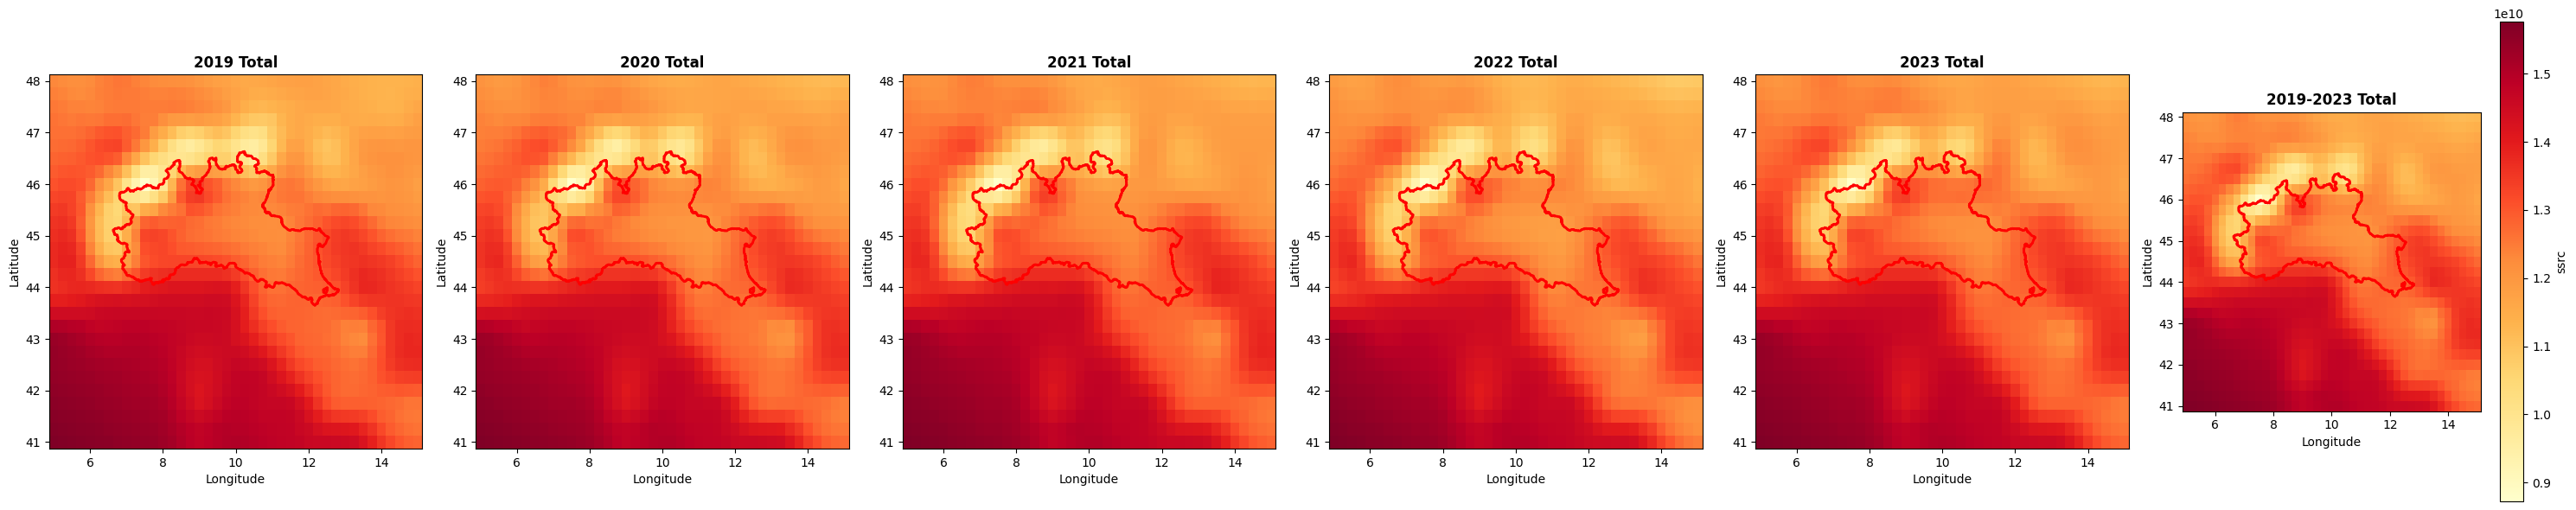


📊 Statistical Summary:
Time series statistics:
  Minimum: 306368.59
  Maximum: 2943693.00
  Mean: 1782568.75
  Standard deviation: 727669.88

Spatial distribution statistics (multi-year total):
  Minimum: 8724912128.00
  Maximum: 15760935936.00
  Mean: 13019913216.00
  Standard deviation: 1347116160.00


In [ ]:
# --- 4. 文件路径 ---
solar_radiation_file = "/content/drive/MyDrive/Variables/surface_net_solar_radiation_clearsky/data_stream-oper_stepType-accum.nc"
aoi_file = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"

# --- 5. 数据加载 ---
import os
if not os.path.exists(solar_radiation_file):
    raise FileNotFoundError(f"Solar radiation file not found: {solar_radiation_file}")
if not os.path.exists(aoi_file):
    raise FileNotFoundError(f"AOI file not found: {aoi_file}")

ds = xr.open_dataset(solar_radiation_file)
aoi = gpd.read_file(aoi_file)

print(f"Dataset variables: {list(ds.data_vars)}")
print(f"Dataset coordinates: {list(ds.coords)}")

# --- 6. 变量和时间处理 ---
# 修复变量识别 - 使用实际的变量名 'ssrc'
var = 'ssrc'  # 直接使用实际的变量名
print(f"Using variable: {var}")

# 自动识别时间维度
time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
if time_coords:
    time_dim = time_coords[0]
    print(f"Using time dimension: {time_dim}")
else:
    raise ValueError("No time dimension found")

# 确保时间有year属性
if not hasattr(ds[time_dim].dt, 'year'):
    ds[time_dim] = xr.decode_cf(ds)[time_dim]

years = np.unique(ds[time_dim + '.year'].values)
print(f"Years in data: {years}")

# --- 7. 时间序列图 ---
print("\n📈 Generating time series plot...")
fig, ax = plt.subplots(figsize=(15, 6))

# 计算空间平均时间序列
if 'latitude' in ds[var].dims and 'longitude' in ds[var].dims:
    ts_mean = ds[var].mean(dim=['latitude', 'longitude'])
else:
    ts_mean = ds[var].mean(dim=[dim for dim in ds[var].dims if dim != time_dim])

ts_mean.plot(ax=ax, marker='o', markersize=2)
ax.set_title(f'{var} - Time Series (Spatial Average)', fontsize=14, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 8. 空间分布图（每年+多年总和） ---
print("\n🗺️ Generating spatial distribution maps...")
n_years = len(years)
fig, axes = plt.subplots(1, n_years + 1, figsize=(5*(n_years+1), 6))

for i, year in enumerate(years):
    ax = axes[i]
    yearly_sum = ds[var].sel({time_dim: str(year)}).sum(dim=time_dim)
    im = yearly_sum.plot(ax=ax, cmap='YlOrRd', add_colorbar=False)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{year} Total', fontsize=12, fontweight='bold')
    aoi.boundary.plot(ax=ax, color='red', linewidth=2)

# 多年总和
ax = axes[-1]
total_sum = ds[var].sum(dim=time_dim)
im = total_sum.plot(ax=ax, cmap='YlOrRd', add_colorbar=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'{years[0]}-{years[-1]} Total', fontsize=12, fontweight='bold')
aoi.boundary.plot(ax=ax, color='red', linewidth=2)

plt.tight_layout()
plt.show()

# --- 9. 统计信息 ---
print("\n📊 Statistical Summary:")
print(f"Time series statistics:")
print(f"  Minimum: {ts_mean.min().values:.2f}")
print(f"  Maximum: {ts_mean.max().values:.2f}")
print(f"  Mean: {ts_mean.mean().values:.2f}")
print(f"  Standard deviation: {ts_mean.std().values:.2f}")

print(f"\nSpatial distribution statistics (multi-year total):")
print(f"  Minimum: {total_sum.min().values:.2f}")
print(f"  Maximum: {total_sum.max().values:.2f}")
print(f"  Mean: {total_sum.mean().values:.2f}")
print(f"  Standard deviation: {total_sum.std().values:.2f}")

In [ ]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import os
import pandas as pd

def process_solar_radiation_to_s5p_grid():
    """Process surface net solar radiation clear sky data to S5P grid-aligned GeoTIFF format"""

    print("☀️ Processing surface net solar radiation clear sky data...")

    # File paths
    solar_file = "/content/drive/MyDrive/Variables/surface_net_solar_radiation_clearsky/data_stream-oper_stepType-accum.nc"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
    output_dir = "/content/drive/MyDrive/Variables/surface_net_solar_radiation_clearsky/solar_radiation_processed"
    os.makedirs(output_dir, exist_ok=True)

    # Load data
    ds = xr.open_dataset(solar_file)

    # Get S5P reference specifications
    with rasterio.open(s5p_reference) as src:
        target_crs = src.crs
        target_transform = src.transform
        target_width = src.width
        target_height = src.height

    print(f"   S5P target grid: {target_width} x {target_height}")

    # Identify variable and time dimension
    solar_var = 'ssrc'  # 直接使用实际变量名
    time_coords = [coord for coord in ds.coords if "time" in coord.lower()]
    time_dim = time_coords[0]

    print(f"   Solar radiation variable: {solar_var}")
    print(f"   Time dimension: {time_dim}")

    # Ensure time has year attribute
    if not hasattr(ds[time_dim].dt, 'year'):
        ds[time_dim] = xr.decode_cf(ds)[time_dim]

    # Check time coverage
    print("🔍 Checking solar radiation time coverage...")
    jan1_data = ds.sel({time_dim: '2019-01-01'})
    print(f"   2019-01-01 time steps: {len(jan1_data[time_dim])}")

    # Calculate daily total solar radiation (accumulated type)
    print("📅 Calculating daily total solar radiation...")
    daily_solar = ds[solar_var].groupby(f'{time_dim}.date').sum(time_dim)

    print(f"   Daily solar radiation shape: {daily_solar.shape}")
    print(f"   Number of days: {len(daily_solar.date)}")

    # Process by year
    years = [2019, 2020, 2021, 2022, 2023]

    for year in years:
        print(f"\n📁 Processing {year}...")

        # Filter data by year
        dates = pd.to_datetime(daily_solar.date.values)
        year_mask = dates.year == year
        yearly_data = daily_solar.sel(date=daily_solar.date[year_mask])

        n_days = len(yearly_data.date)
        print(f"   Number of days: {n_days}")

        if n_days == 0:
            print(f"   ⚠️ No data found for {year}, skipping...")
            continue

        # Create output GeoTIFF
        output_file = f"{output_dir}/solar_radiation_daily_{year}.tif"

        profile = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': n_days,
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': np.nan
        }

        output_data = np.full((n_days, target_height, target_width), np.nan, dtype=np.float32)

        # Process each day
        for day_idx in range(n_days):
            if day_idx % 50 == 0:
                print(f"     Processing day {day_idx + 1}/{n_days}")

            daily_slice = yearly_data.isel(date=day_idx)
            daily_array = daily_slice.values

            source_height, source_width = daily_array.shape
            source_bounds = (5.0, 41.0, 15.0, 48.0)
            source_transform = rasterio.transform.from_bounds(*source_bounds, source_width, source_height)

            reproject(
                source=daily_array,
                destination=output_data[day_idx],
                src_transform=source_transform,
                src_crs=target_crs,
                dst_transform=target_transform,
                dst_crs=target_crs,
                resampling=Resampling.bilinear,
                nodata=np.nan
            )

        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(output_data)

        print(f"  ✅ Saved: {output_file}")
        print(f"     Shape: {output_data.shape}")
        print(f"     Valid values: {np.sum(~np.isnan(output_data))}")

    # Create 5-year mean
    print(f"\n📊 Creating 5-year mean...")
    all_years_data = []

    for year in years:
        year_file = f"{output_dir}/solar_radiation_daily_{year}.tif"
        if os.path.exists(year_file):
            with rasterio.open(year_file) as src:
                data = src.read()
                all_years_data.append(data)

    if all_years_data:
        mean_5yr = np.nanmean(np.concatenate(all_years_data, axis=0), axis=0)

        mean_profile = profile.copy()
        mean_profile['count'] = 1

        mean_file = f"{output_dir}/solar_radiation_5year_mean.tif"
        with rasterio.open(mean_file, 'w', **mean_profile) as dst:
            dst.write(mean_5yr, 1)

        print(f"  ✅ Saved 5-year mean: {mean_file}")

    print(f"\n🎉 Solar radiation processing completed!")
    print(f"   Output directory: {output_dir}")
    print(f"   Files created:")
    for year in years:
        print(f"     - solar_radiation_daily_{year}.tif")
    print(f"     - solar_radiation_5year_mean.tif")

# Run processing
if __name__ == "__main__":
    process_solar_radiation_to_s5p_grid()

☀️ Processing surface net solar radiation clear sky data...
   S5P target grid: 621 x 300
   Solar radiation variable: ssrc
   Time dimension: valid_time
🔍 Checking solar radiation time coverage...
   2019-01-01 time steps: 4
📅 Calculating daily total solar radiation...
   Daily solar radiation shape: (1826, 29, 41)
   Number of days: 1826

📁 Processing 2019...
   Number of days: 365
     Processing day 1/365
     Processing day 51/365
     Processing day 101/365
     Processing day 151/365
     Processing day 201/365
     Processing day 251/365
     Processing day 301/365
     Processing day 351/365
  ✅ Saved: /content/drive/MyDrive/Variables/surface_net_solar_radiation_clearsky/solar_radiation_processed/solar_radiation_daily_2019.tif
     Shape: (365, 300, 621)
     Valid values: 67999500

📁 Processing 2020...
   Number of days: 366
     Processing day 1/366
     Processing day 51/366
     Processing day 101/366
     Processing day 151/366
     Processing day 201/366
     Processing 

In [ ]:
import rasterio
import numpy as np
import os

def quality_check_solar_radiation_results():
    """Quality check of processed solar radiation data"""

    print("Quality check of processed solar radiation data...")

    output_dir = "/content/drive/MyDrive/Variables/surface_net_solar_radiation_clearsky/solar_radiation_processed"
    years = [2019, 2020, 2021, 2022, 2023]

    print("📊 Solar Radiation Data:")

    # Check yearly data
    for year in years:
        file_path = f"{output_dir}/solar_radiation_daily_{year}.tif"
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read()
                valid_mask = ~np.isnan(data)
                valid_data = data[valid_mask]

                print(f"  {year}: Shape {data.shape}, Valid values: {np.sum(valid_mask)}")
                print(f"    Range: {valid_data.min():.2f} - {valid_data.max():.2f} J/m²")
                print(f"    Mean: {valid_data.mean():.2f} J/m²")
                print(f"    Std: {valid_data.std():.2f} J/m²")
        else:
            print(f"  {year}: File not found")

    # Check 5-year mean
    mean_file = f"{output_dir}/solar_radiation_5year_mean.tif"
    if os.path.exists(mean_file):
        with rasterio.open(mean_file) as src:
            mean_data = src.read(1)  # Read first band
            valid_mask = ~np.isnan(mean_data)
            valid_mean = mean_data[valid_mask]

            print(f"\n📊 5-Year Mean Solar Radiation:")
            print(f"  Shape: {mean_data.shape}")
            print(f"  Range: {valid_mean.min():.2f} - {valid_mean.max():.2f} J/m²")
            print(f"  Mean: {valid_mean.mean():.2f} J/m²")
            print(f"  Std: {valid_mean.std():.2f} J/m²")

    print(f"\n🎉 Quality check completed!")

if __name__ == "__main__":
    quality_check_solar_radiation_results()

Quality check of processed solar radiation data...
📊 Solar Radiation Data:
  2019: Shape (365, 300, 621), Valid values: 67999500
    Range: 738626.00 - 11659765.00 J/m²
    Mean: 6711068.00 J/m²
    Std: 2741204.50 J/m²
  2020: Shape (366, 300, 621), Valid values: 68185800
    Range: 849035.44 - 11544754.00 J/m²
    Mean: 6773482.50 J/m²
    Std: 2767992.25 J/m²
  2021: Shape (365, 300, 621), Valid values: 67999500
    Range: 793335.00 - 11631224.00 J/m²
    Mean: 6713130.50 J/m²
    Std: 2782396.75 J/m²
  2022: Shape (365, 300, 621), Valid values: 67999500
    Range: 842600.25 - 11625482.00 J/m²
    Mean: 6832982.00 J/m²
    Std: 2743690.75 J/m²
  2023: Shape (365, 300, 621), Valid values: 67999500
    Range: 753677.75 - 11516301.00 J/m²
    Mean: 6782916.50 J/m²
    Std: 2724785.50 J/m²

📊 5-Year Mean Solar Radiation:
  Shape: (300, 621)
  Range: 4789258.00 - 7958677.00 J/m²
  Mean: 6762728.50 J/m²
  Std: 582479.12 J/m²

🎉 Quality check completed!


In [ ]:
import rasterio, os
from pprint import pprint

REF = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2023.tif"
CHECK = [
    # 按你的实际路径改一下（只要挑同一年任意一个文件检查即可）
    "/content/drive/MyDrive/Variables/boundary_layer_height/boundary_layer_height_processed/blh_daily_2023.tif",
    "/content/drive/MyDrive/Variables/2m_temperature/2m_temperature_processed/temperature_daily_2023.tif",
    "/content/drive/MyDrive/Variables/surface_pressure/surface_pressure_processed/pressure_daily_2023.tif",
    "/content/drive/MyDrive/Variables/total_precipitation/total_precipitation_processed/precipitation_daily_2023.tif",
    "/content/drive/MyDrive/Variables/surface_net_solar_radiation_clearsky/solar_radiation_processed/solar_radiation_daily_2023.tif",
    "/content/drive/MyDrive/Variables/surface_net_thermal_radiation/thermal_radiation_processed/thermal_radiation_daily_2023.tif",
    "/content/drive/MyDrive/Variables/10m_u_component_of_wind/wind_speed_processed/wind_speed_daily_2023.tif",
    "/content/drive/MyDrive/Variables/10m_v_component_of_wind/wind_direction_processed/wind_direction_daily_2023.tif",
]

with rasterio.open(REF) as r:
    ref = (r.crs, r.transform, r.width, r.height)

def same_grid(path):
    with rasterio.open(path) as s:
        return (s.crs, s.transform, s.width, s.height) == ref

report = {p: same_grid(p) for p in CHECK if os.path.exists(p)}
pprint(report)
# 所有 True 就通过

{'/content/drive/MyDrive/Variables/10m_u_component_of_wind/wind_speed_processed/wind_speed_daily_2023.tif': True,
 '/content/drive/MyDrive/Variables/10m_v_component_of_wind/wind_direction_processed/wind_direction_daily_2023.tif': True,
 '/content/drive/MyDrive/Variables/2m_temperature/2m_temperature_processed/temperature_daily_2023.tif': True,
 '/content/drive/MyDrive/Variables/boundary_layer_height/boundary_layer_height_processed/blh_daily_2023.tif': True,
 '/content/drive/MyDrive/Variables/surface_net_solar_radiation_clearsky/solar_radiation_processed/solar_radiation_daily_2023.tif': True,
 '/content/drive/MyDrive/Variables/surface_net_thermal_radiation/thermal_radiation_processed/thermal_radiation_daily_2023.tif': True,
 '/content/drive/MyDrive/Variables/surface_pressure/surface_pressure_processed/pressure_daily_2023.tif': True,
 '/content/drive/MyDrive/Variables/total_precipitation/total_precipitation_processed/precipitation_daily_2023.tif': True}


## 8. population

=== Population Data Visualization ===
=== Population Data Information ===
  2019:
    File: ita_ppp_2019_1km_Aggregated_UNadj.tif
    Shape: (1393, 1427)
    Bounds: BoundingBox(left=6.6320833075370444, bottom=35.49125004538103, right=18.523749926637045, top=47.09958333228103)
    CRS: EPSG:4326
    Resolution: 0.008333° lat x 0.008333° lon
    Data range: -99999 to 21532 people/km²
    Mean: -75736 people/km²
    Non-zero pixels: 394042
  2020:
    File: ita_ppp_2020_1km_Aggregated_UNadj.tif
    Shape: (1393, 1427)
    Bounds: BoundingBox(left=6.6320833075370444, bottom=35.49125004538103, right=18.523749926637045, top=47.09958333228103)
    CRS: EPSG:4326
    Resolution: 0.008333° lat x 0.008333° lon
    Data range: -99999 to 21302 people/km²
    Mean: -75736 people/km²
    Non-zero pixels: 394042
  2021:
    File: ita_ppp_2021_1km_UNadj_constrained.tif
    Shape: (1392, 1426)
    Bounds: BoundingBox(left=6.633743270000001, bottom=35.4945833922, right=18.517076555800003, top=47.094583

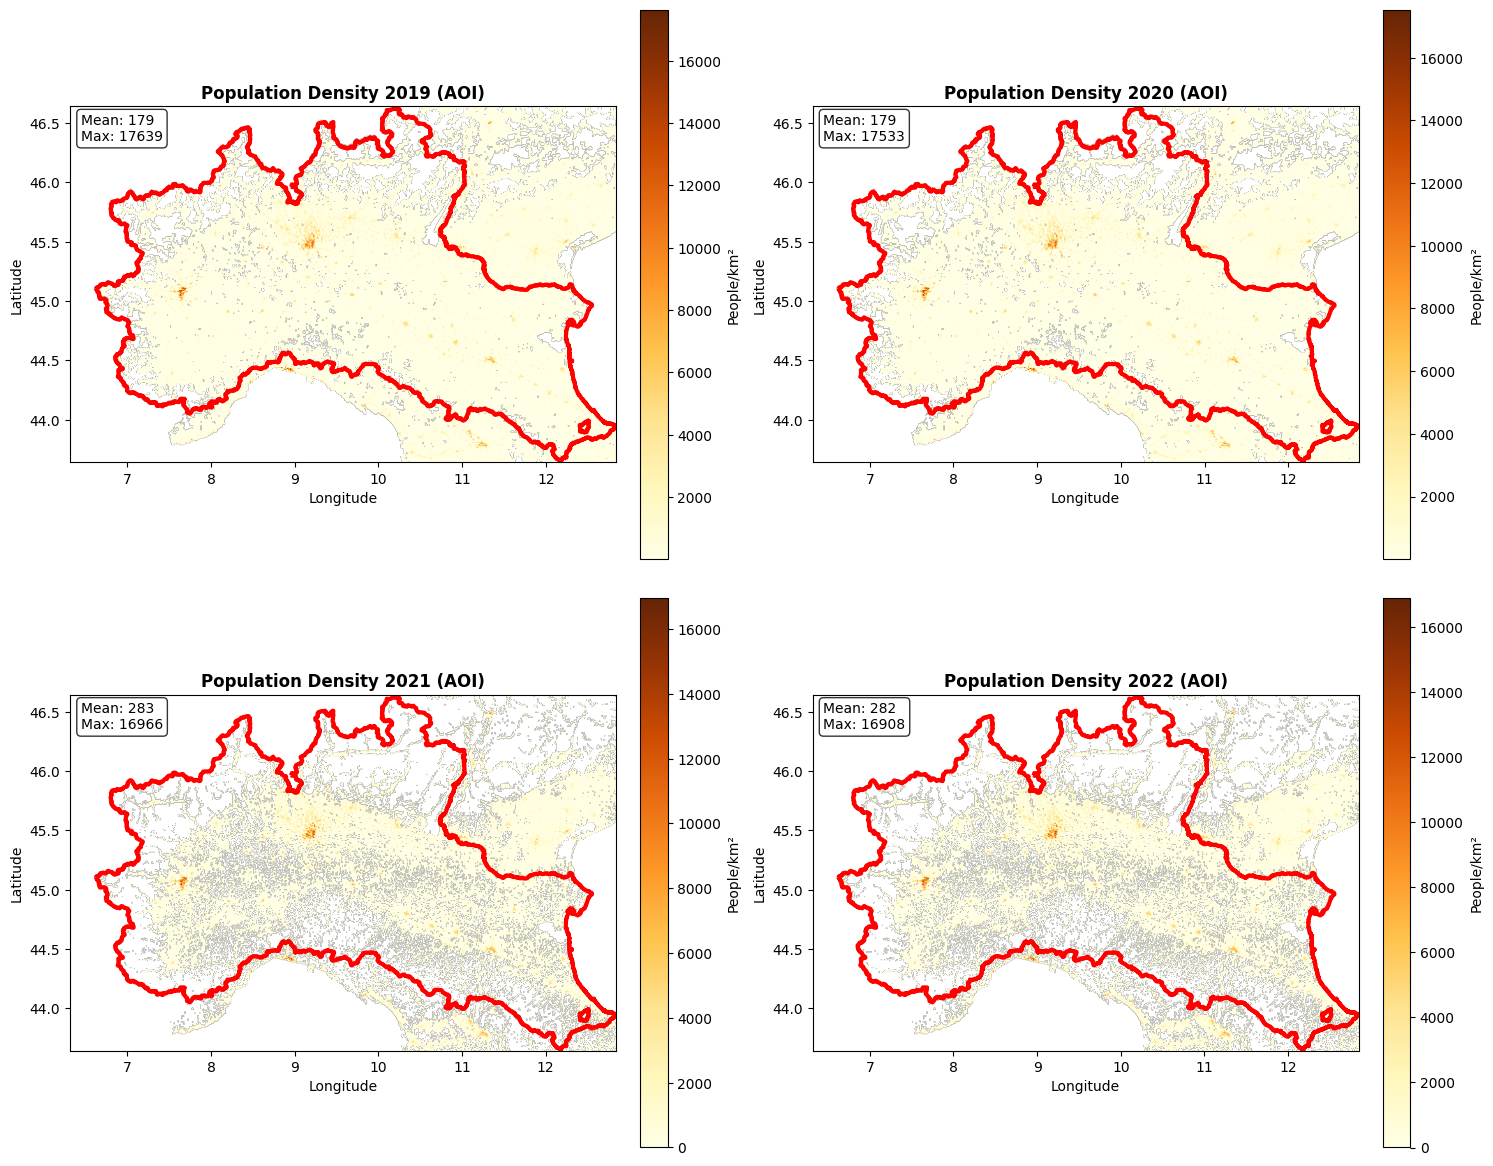

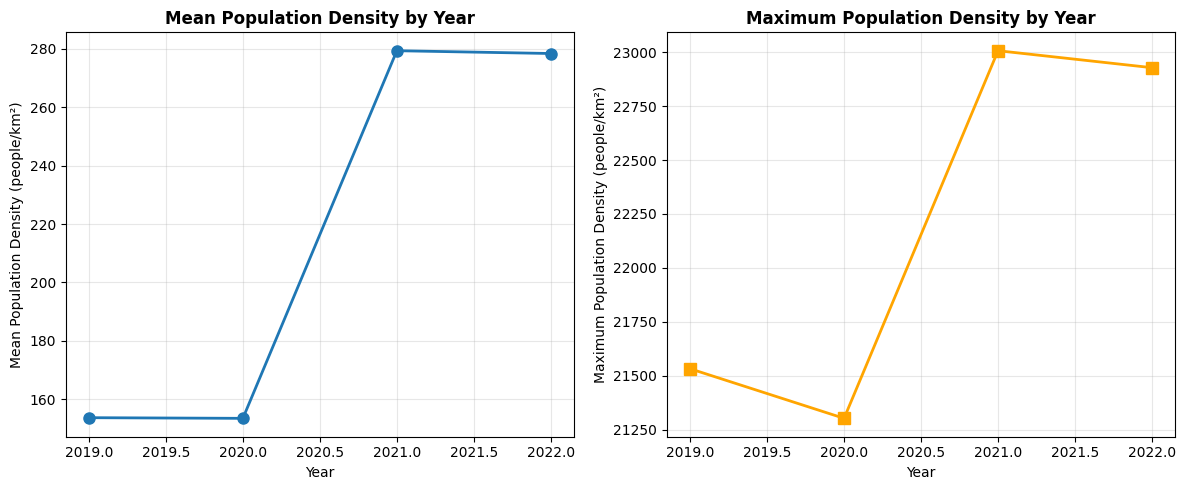

✓ AOI overlaps with population data

=== Comparison with NO2 Grid ===
NO2 grid:
  Shape: (300, 621)
  Bounds: BoundingBox(left=6.620030281745857, bottom=43.640199621659995, right=12.830058688036154, top=46.64021334450555)
  CRS: EPSG:4326
  Resolution: 0.010000° lat x 0.010000° lon

Population grid:
  Shape: (1393, 1427)
  Bounds: BoundingBox(left=6.6320833075370444, bottom=35.49125004538103, right=18.523749926637045, top=47.09958333228103)
  CRS: EPSG:4326
  Resolution: 0.008333° lat x 0.008333° lon

⚠️ Population and NO2 grids have different shapes
  Population: (1393, 1427)
  NO2: (300, 621)
  Population needs resampling to match NO2 grid
⚠️ Different resolutions:
  Population: 0.008333° lat x 0.008333° lon
  NO2: 0.010000° lat x 0.010000° lon
✓ Population and NO2 have same CRS

✅ Population visualization completed!


In [ ]:
import os
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def get_population_info():
    """Get population data information for all years"""
    years = [2019, 2020, 2021, 2022]
    pop_info_list = []

    print("=== Population Data Information ===")

    for year in years:
        # Try different file patterns
        pop_files = [
            f"/content/drive/MyDrive/Variables/population/ita_ppp_{year}_1km_Aggregated_UNadj.tif",
            f"/content/drive/MyDrive/Variables/population/ita_ppp_{year}_1km_UNadj_constrained.tif",
            f"/content/drive/My Drive/Variables/population/ita_ppp_{year}_1km_Aggregated_UNadj.tif",
            f"/content/drive/My Drive/Variables/population/ita_ppp_{year}_1km_UNadj_constrained.tif"
        ]

        pop_file = None
        for file_path in pop_files:
            if os.path.exists(file_path):
                pop_file = file_path
                break

        if not pop_file:
            print(f"❌ {year}: No population file found")
            continue

        with rasterio.open(pop_file) as src:
            print(f"  {year}:")
            print(f"    File: {os.path.basename(pop_file)}")
            print(f"    Shape: {src.shape}")
            print(f"    Bounds: {src.bounds}")
            print(f"    CRS: {src.crs}")

            # Calculate resolution
            lat_res = abs(src.bounds.top - src.bounds.bottom) / src.shape[0]
            lon_res = abs(src.bounds.right - src.bounds.left) / src.shape[1]
            print(f"    Resolution: {lat_res:.6f}° lat x {lon_res:.6f}° lon")

            data = src.read(1)
            print(f"    Data range: {np.nanmin(data):.0f} to {np.nanmax(data):.0f} people/km²")
            print(f"    Mean: {np.nanmean(data):.0f} people/km²")
            print(f"    Non-zero pixels: {np.sum(data > 0)}")

            pop_info_list.append({
                'year': year,
                'file': pop_file,
                'shape': src.shape,
                'bounds': src.bounds,
                'crs': src.crs,
                'lat_res': lat_res,
                'lon_res': lon_res,
                'data': data
            })

    return pop_info_list

def visualize_population_data(pop_info_list):
    """Visualize population data"""
    if not pop_info_list:
        print("No population data found!")
        return

    # Load AOI
    aoi_file = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
    aoi = None
    if os.path.exists(aoi_file):
        aoi = gpd.read_file(aoi_file)
        print(f"AOI loaded: {aoi.crs}")
        print(f"AOI bounds: {aoi.total_bounds}")
    else:
        print("❌ AOI file not found!")
        return

    # Create visualization
    n_years = len(pop_info_list)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, info in enumerate(pop_info_list):
        ax = axes[i]
        data = info['data']

        # Fix negative values
        if np.nanmin(data) < 0:
            data = np.where(data < 0, 0, data)

        # Create masked array
        masked_data = np.ma.masked_where(data <= 0, data)

        # Transform AOI to match raster CRS
        if aoi.crs != info['crs']:
            aoi_transformed = aoi.to_crs(info['crs'])
        else:
            aoi_transformed = aoi

        # Get AOI bounds for cropping
        aoi_bounds = aoi_transformed.total_bounds

        # Crop data to AOI extent with some buffer
        buffer = 0.01  # 0.01 degree buffer
        crop_bounds = [
            max(info['bounds'].left, aoi_bounds[0] - buffer),
            max(info['bounds'].bottom, aoi_bounds[1] - buffer),
            min(info['bounds'].right, aoi_bounds[2] + buffer),
            min(info['bounds'].top, aoi_bounds[3] + buffer)
        ]

        # Calculate pixel indices for cropping
        lat_indices = np.where((info['bounds'].top - np.arange(info['shape'][0]) * info['lat_res']) >= crop_bounds[1])[0]
        lat_indices = lat_indices[(info['bounds'].top - lat_indices * info['lat_res']) <= crop_bounds[3]]

        lon_indices = np.where((info['bounds'].left + np.arange(info['shape'][1]) * info['lon_res']) >= crop_bounds[0])[0]
        lon_indices = lon_indices[(info['bounds'].left + lon_indices * info['lon_res']) <= crop_bounds[2]]

        if len(lat_indices) > 0 and len(lon_indices) > 0:
            # Crop data
            cropped_data = data[lat_indices[0]:lat_indices[-1]+1, lon_indices[0]:lon_indices[-1]+1]
            cropped_bounds = [
                info['bounds'].left + lon_indices[0] * info['lon_res'],
                info['bounds'].top - lat_indices[-1] * info['lat_res'],
                info['bounds'].left + (lon_indices[-1] + 1) * info['lon_res'],
                info['bounds'].top - lat_indices[0] * info['lat_res']
            ]

            # Create masked array for cropped data
            masked_cropped = np.ma.masked_where(cropped_data <= 0, cropped_data)

            # Plot cropped data
            im = ax.imshow(masked_cropped, cmap='YlOrBr', aspect='auto',
                          extent=[cropped_bounds[0], cropped_bounds[2],
                                  cropped_bounds[1], cropped_bounds[3]])

            # Add AOI boundary
            aoi_transformed.boundary.plot(ax=ax, color='red', linewidth=3)

            # Add statistics for cropped area
            valid_data = cropped_data[cropped_data > 0]
            if len(valid_data) > 0:
                mean_val = np.nanmean(valid_data)
                max_val = np.nanmax(valid_data)
                stats_text = f'Mean: {mean_val:.0f}\nMax: {max_val:.0f}'
            else:
                stats_text = 'No valid data'

            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            # Fallback to full extent if cropping fails
            im = ax.imshow(masked_data, cmap='YlOrBr', aspect='auto',
                          extent=[info['bounds'].left, info['bounds'].right,
                                  info['bounds'].bottom, info['bounds'].top])
            aoi_transformed.boundary.plot(ax=ax, color='red', linewidth=3)

        ax.set_title(f'Population Density {info["year"]} (AOI)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('People/km²')

    plt.tight_layout()
    plt.show()

    # Time series plot
    years = []
    means = []
    maxs = []

    for info in pop_info_list:
        data = info['data']
        data = np.where(data < 0, 0, data)
        valid_data = data[data > 0]

        if len(valid_data) > 0:
            years.append(info['year'])
            means.append(np.nanmean(valid_data))
            maxs.append(np.nanmax(valid_data))

    if years:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        ax1.plot(years, means, 'o-', linewidth=2, markersize=8)
        ax1.set_title('Mean Population Density by Year', fontweight='bold')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Mean Population Density (people/km²)')
        ax1.grid(True, alpha=0.3)

        ax2.plot(years, maxs, 's-', linewidth=2, markersize=8, color='orange')
        ax2.set_title('Maximum Population Density by Year', fontweight='bold')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Maximum Population Density (people/km²)')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

def check_aoi_alignment(pop_info_list):
    """Check AOI and population data alignment"""
    if not pop_info_list:
        return

    aoi_file = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
    if not os.path.exists(aoi_file):
        print("❌ AOI file not found!")
        return

    aoi = gpd.read_file(aoi_file)
    pop_info = pop_info_list[0]

    if aoi.crs != pop_info['crs']:
        aoi_transformed = aoi.to_crs(pop_info['crs'])
    else:
        aoi_transformed = aoi

    aoi_bounds = aoi_transformed.total_bounds
    pop_bounds = [pop_info['bounds'].left, pop_info['bounds'].bottom,
                 pop_info['bounds'].right, pop_info['bounds'].top]

    overlap = (aoi_bounds[0] < pop_bounds[2] and aoi_bounds[2] > pop_bounds[0] and
              aoi_bounds[1] < pop_bounds[3] and aoi_bounds[3] > pop_bounds[1])

    if overlap:
        print("✓ AOI overlaps with population data")
    else:
        print("❌ AOI does not overlap with population data")

def compare_with_no2_grid(pop_info_list):
    """Compare population data with NO2 grid"""
    print("\n=== Comparison with NO2 Grid ===")

    # Get NO2 info for comparison
    no2_file = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2023.tif"
    if os.path.exists(no2_file):
        with rasterio.open(no2_file) as src:
            no2_shape = src.shape
            no2_bounds = src.bounds
            no2_crs = src.crs

            # Calculate NO2 resolution
            no2_lat_res = abs(no2_bounds.top - no2_bounds.bottom) / no2_shape[0]
            no2_lon_res = abs(no2_bounds.right - no2_bounds.left) / no2_shape[1]

            print(f"NO2 grid:")
            print(f"  Shape: {no2_shape}")
            print(f"  Bounds: {no2_bounds}")
            print(f"  CRS: {no2_crs}")
            print(f"  Resolution: {no2_lat_res:.6f}° lat x {no2_lon_res:.6f}° lon")
    else:
        print("❌ NO2 file not found!")
        return

    if pop_info_list:
        pop_info = pop_info_list[0]  # Use first year for comparison
        print(f"\nPopulation grid:")
        print(f"  Shape: {pop_info['shape']}")
        print(f"  Bounds: {pop_info['bounds']}")
        print(f"  CRS: {pop_info['crs']}")
        print(f"  Resolution: {pop_info['lat_res']:.6f}° lat x {pop_info['lon_res']:.6f}° lon")

        # Check if grids are compatible
        if pop_info['shape'] == no2_shape:
            print("\n✓ Population and NO2 grids have same shape")
        else:
            print(f"\n⚠️ Population and NO2 grids have different shapes")
            print(f"  Population: {pop_info['shape']}")
            print(f"  NO2: {no2_shape}")
            print(f"  Population needs resampling to match NO2 grid")

        # Check resolution compatibility
        if abs(pop_info['lat_res'] - no2_lat_res) < 0.0001 and abs(pop_info['lon_res'] - no2_lon_res) < 0.0001:
            print("✓ Population and NO2 have same resolution")
        else:
            print(f"⚠️ Different resolutions:")
            print(f"  Population: {pop_info['lat_res']:.6f}° lat x {pop_info['lon_res']:.6f}° lon")
            print(f"  NO2: {no2_lat_res:.6f}° lat x {no2_lon_res:.6f}° lon")

        # Check CRS compatibility
        if pop_info['crs'] == no2_crs:
            print("✓ Population and NO2 have same CRS")
        else:
            print(f"⚠️ Different CRS:")
            print(f"  Population: {pop_info['crs']}")
            print(f"  NO2: {no2_crs}")

if __name__ == "__main__":
    print("=== Population Data Visualization ===")

    pop_info_list = get_population_info()

    if pop_info_list:
        visualize_population_data(pop_info_list)
        check_aoi_alignment(pop_info_list)
        compare_with_no2_grid(pop_info_list)
        print("\n✅ Population visualization completed!")
    else:
        print("❌ No population data found!")

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os

def process_population_to_s5p_grid_fixed():
    """Reproject population density to S5P grid alignment (with proper NoData handling)"""

    print("👥 Processing population density to S5P grid alignment (fixed)...")

    # File paths
    population_file = "/content/drive/MyDrive/Variables/population/ita_ppp_2020_1km_Aggregated_UNadj.tif"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
    output_dir = "/content/drive/MyDrive/Variables/population_aligned_s5p"
    os.makedirs(output_dir, exist_ok=True)

    try:
        # Load S5P reference
        with rasterio.open(s5p_reference) as src:
            target_crs = src.crs
            target_transform = src.transform
            target_width = src.width
            target_height = src.height

        # Load population data
        with rasterio.open(population_file) as src:
            print(f"\n👥 Population Data (2020):")
            print(f"   CRS: {src.crs}")
            print(f"   Width: {src.width}")
            print(f"   Height: {src.height}")
            print(f"   NoData value: {src.nodata}")

            # Read population data and handle NoData properly
            pop_data = src.read(1)

            # Replace NoData values with NaN
            if src.nodata is not None:
                pop_data = pop_data.astype(np.float32)
                pop_data[pop_data == src.nodata] = np.nan

            print(f"   Data range (after NoData fix): {np.nanmin(pop_data):.2f} - {np.nanmax(pop_data):.2f} people/km²")

        # Create output array
        output_data = np.full((target_height, target_width), np.nan, dtype=np.float32)

        # Reproject population to S5P grid
        print(f"\n🔄 Reprojecting population...")
        reproject(
            source=pop_data,
            destination=output_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear,
            nodata=np.nan
        )

        # Create output profile
        output_profile = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': 1,
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': np.nan
        }

        # Save aligned population
        output_file = f"{output_dir}/population_2020_s5p_aligned_fixed.tif"
        with rasterio.open(output_file, 'w', **output_profile) as dst:
            dst.write(output_data, 1)

        # Quality check
        valid_mask = ~np.isnan(output_data)
        valid_data = output_data[valid_mask]

        print(f"\n✅ Population processing completed (fixed)!")
        print(f"   Output file: {output_file}")
        print(f"   Shape: {output_data.shape}")
        print(f"   Valid pixels: {np.sum(valid_mask)}")
        print(f"   Data range: {valid_data.min():.2f} - {valid_data.max():.2f} people/km²")
        print(f"   Mean population: {valid_data.mean():.2f} people/km²")
        print(f"   Std population: {valid_data.std():.2f} people/km²")

        # Additional statistics
        print(f"   Non-zero pixels: {np.sum(valid_data > 0)}")
        print(f"   Zero pixels: {np.sum(valid_data == 0)}")

    except Exception as e:
        print(f"Error processing population: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    process_population_to_s5p_grid_fixed()

👥 Processing population density to S5P grid alignment (fixed)...

👥 Population Data (2020):
   CRS: EPSG:4326
   Width: 1427
   Height: 1393
   NoData value: -99999.0
   Data range (after NoData fix): 0.00 - 21301.83 people/km²

🔄 Reprojecting population...

✅ Population processing completed (fixed)!
   Output file: /content/drive/MyDrive/Variables/population_aligned_s5p/population_2020_s5p_aligned_fixed.tif
   Shape: (300, 621)
   Valid pixels: 132273
   Data range: 0.00 - 13963.17 people/km²
   Mean population: 148.40 people/km²
   Std population: 489.33 people/km²
   Non-zero pixels: 119968
   Zero pixels: 12305


## 9. day_of_week (prepared done)

In [ ]:
import pandas as pd
import numpy as np
import rasterio
import os

def calculate_weekday_weights(pollutant):
    print(f"Calculating {pollutant} weekday weights...")

    # Setup paths
    data_dir = f'/content/drive/My Drive/GEE_{pollutant}/'
    years = [2019, 2020, 2021, 2022, 2023]

    all_concentrations = []
    all_dates = []

    for year in years:
        file_path = os.path.join(data_dir, f'{pollutant}_Daily_Multiband_{year}.tif')

        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read()
                daily_means = np.nanmean(data, axis=(1, 2))
                year_dates = pd.date_range(f'{year}-01-01', f'{year}-12-31', freq='D')

                if len(year_dates) == len(daily_means):
                    all_concentrations.extend(daily_means)
                    all_dates.extend(year_dates)
                    print(f"  Processed {year}: {len(daily_means)} days")

    # Create DataFrame
    df = pd.DataFrame({
        'date': all_dates,
        'concentration': all_concentrations
    })

    # Add weekday information
    df['day_of_week'] = df['date'].dt.weekday
    df['is_weekend'] = df['day_of_week'] >= 5

    # Data quality check (consistent with first version)
    valid_mask = (df['concentration'].notna()) & (df['concentration'] >= 0)
    df_valid = df[valid_mask].copy()

    print(f"  Total days: {len(df)}")
    print(f"  Valid days: {len(df_valid)}")
    print(f"  Missing/Invalid: {len(df) - len(df_valid)}")

    # Calculate weights using valid data only
    weekday_data = df_valid[~df_valid['is_weekend']]
    weekend_data = df_valid[df_valid['is_weekend']]

    weekday_mean = weekday_data['concentration'].mean()
    weekend_mean = weekend_data['concentration'].mean()

    weekday_weight = 1.0
    weekend_weight = weekend_mean / weekday_mean

    print(f"{pollutant} weights: Weekday={weekday_weight}, Weekend={weekend_weight:.4f}")
    print(f"  Weekday mean: {weekday_mean:.6f}")
    print(f"  Weekend mean: {weekend_mean:.6f}")

    # Apply weights to all data
    df['weekday_weight'] = np.where(df['is_weekend'], weekend_weight, weekday_weight)

    # Save results
    output_path = f'/content/drive/My Drive/Variables/{pollutant.lower()}_weekday_weight_2019_2023.csv'
    df.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

    return df

# Calculate weights
no2_df = calculate_weekday_weights('NO2')
so2_df = calculate_weekday_weights('SO2')

print("All weights calculated successfully!")

Calculating NO2 weekday weights...
  Processed 2019: 365 days
  Processed 2020: 366 days
  Processed 2021: 365 days
  Processed 2022: 365 days
  Processed 2023: 365 days
  Total days: 1826
  Valid days: 1777
  Missing/Invalid: 49
NO2 weights: Weekday=1.0, Weekend=0.8540
  Weekday mean: 0.000056
  Weekend mean: 0.000048
Saved: /content/drive/My Drive/Variables/no2_weekday_weight_2019_2023.csv
Calculating SO2 weekday weights...
  Processed 2019: 365 days
  Processed 2020: 366 days
  Processed 2021: 365 days
  Processed 2022: 365 days
  Processed 2023: 365 days
  Total days: 1826
  Valid days: 1056
  Missing/Invalid: 770
SO2 weights: Weekday=1.0, Weekend=0.9509
  Weekday mean: 0.000323
  Weekend mean: 0.000307
Saved: /content/drive/My Drive/Variables/so2_weekday_weight_2019_2023.csv
All weights calculated successfully!


## 10. day_of_year (prepared done)

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
from google.colab import drive

# Mount Google Drive
drive.mount('/gdrive')

# Path and years
output_dir = '/gdrive/My Drive/Variables/day_of_year/'
os.makedirs(output_dir, exist_ok=True)

years = [2019, 2020, 2021, 2022, 2023]

# Use NO2 2019 as reference for grid dimensions
ref_path = '/gdrive/My Drive/GEE_NO2/NO2_Daily_Multiband_2019.tif'

with rasterio.open(ref_path) as ref:
    width = ref.width
    height = ref.height
    transform = ref.transform
    crs = ref.crs

# Create sin/cos layers for each year
for year in years:
    # Generate DOY array
    start = f'{year}-01-01'
    end = f'{year}-12-31'
    dates = pd.date_range(start=start, end=end, freq='D')
    doy = dates.dayofyear.values

    # Use actual year length
    year_len = len(dates)  # 365 or 366

    # Calculate sin/cos for each day
    sin_doy = np.sin(2 * np.pi * doy / year_len).astype(np.float32)
    cos_doy = np.cos(2 * np.pi * doy / year_len).astype(np.float32)

    # Create multi-band rasters (one band per day)
    sin_stack = np.stack([np.full((height, width), v, dtype=np.float32) for v in sin_doy])
    cos_stack = np.stack([np.full((height, width), v, dtype=np.float32) for v in cos_doy])

    # Save rasters
    sin_path = os.path.join(output_dir, f'sin_doy_{year}.tif')
    cos_path = os.path.join(output_dir, f'cos_doy_{year}.tif')

    # Write
    for path, data in zip([sin_path, cos_path], [sin_stack, cos_stack]):
        with rasterio.open(
            path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=data.shape[0],  # daily bands
            dtype='float32',
            crs=crs,
            transform=transform,
        ) as dst:
            for i in range(data.shape[0]):
                dst.write(data[i], i + 1)

    print(f"✅ Saved: {sin_path}, {cos_path}")
    print(f"  Year: {year}, Days: {year_len}, Bands: {data.shape[0]}")

Mounted at /gdrive
✅ Saved: /gdrive/My Drive/Variables/day_of_year/sin_doy_2019.tif, /gdrive/My Drive/Variables/day_of_year/cos_doy_2019.tif
  Year: 2019, Days: 365, Bands: 365
✅ Saved: /gdrive/My Drive/Variables/day_of_year/sin_doy_2020.tif, /gdrive/My Drive/Variables/day_of_year/cos_doy_2020.tif
  Year: 2020, Days: 366, Bands: 366
✅ Saved: /gdrive/My Drive/Variables/day_of_year/sin_doy_2021.tif, /gdrive/My Drive/Variables/day_of_year/cos_doy_2021.tif
  Year: 2021, Days: 365, Bands: 365
✅ Saved: /gdrive/My Drive/Variables/day_of_year/sin_doy_2022.tif, /gdrive/My Drive/Variables/day_of_year/cos_doy_2022.tif
  Year: 2022, Days: 365, Bands: 365
✅ Saved: /gdrive/My Drive/Variables/day_of_year/sin_doy_2023.tif, /gdrive/My Drive/Variables/day_of_year/cos_doy_2023.tif
  Year: 2023, Days: 365, Bands: 365


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

# Mount Google Drive
drive.mount('/gdrive')

# Generate date range from 2019-01-01 to 2023-12-31
dates = pd.date_range(start='2019-01-01', end='2023-12-31', freq='D')
df = pd.DataFrame({'date': dates})

# Add day of week (0=Monday, 6=Sunday)
df['day_of_week'] = df['date'].dt.weekday

# Add day name (e.g., 'Monday', 'Tuesday')
df['day_name'] = df['date'].dt.day_name()

# Add day of year (1–365/366)
df['day_of_year'] = df['date'].dt.dayofyear

# Add sin/cos time encoding
df['sin_doy'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['cos_doy'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Add weekday_weight: 1.0 for weekdays (Mon–Fri), 0.5 for weekends (Sat, Sun)
df['weekday_weight'] = df['day_of_week'].apply(lambda x: 1.0 if x < 5 else 0.5)

# Save to Google Drive
save_path = '/gdrive/My Drive/Variables/day_of_year/time_features.csv'
df.to_csv(save_path, index=False)

print("✅ Saved to:", save_path)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
✅ Saved to: /gdrive/My Drive/Variables/day_of_year/time_features.csv


## 11. no2_lag_1day (prepared done)

AOI loaded: 1 features
AOI bounds: [ 6.62662136 43.64829326 12.82793661 46.63518705]
CAMS data loaded successfully


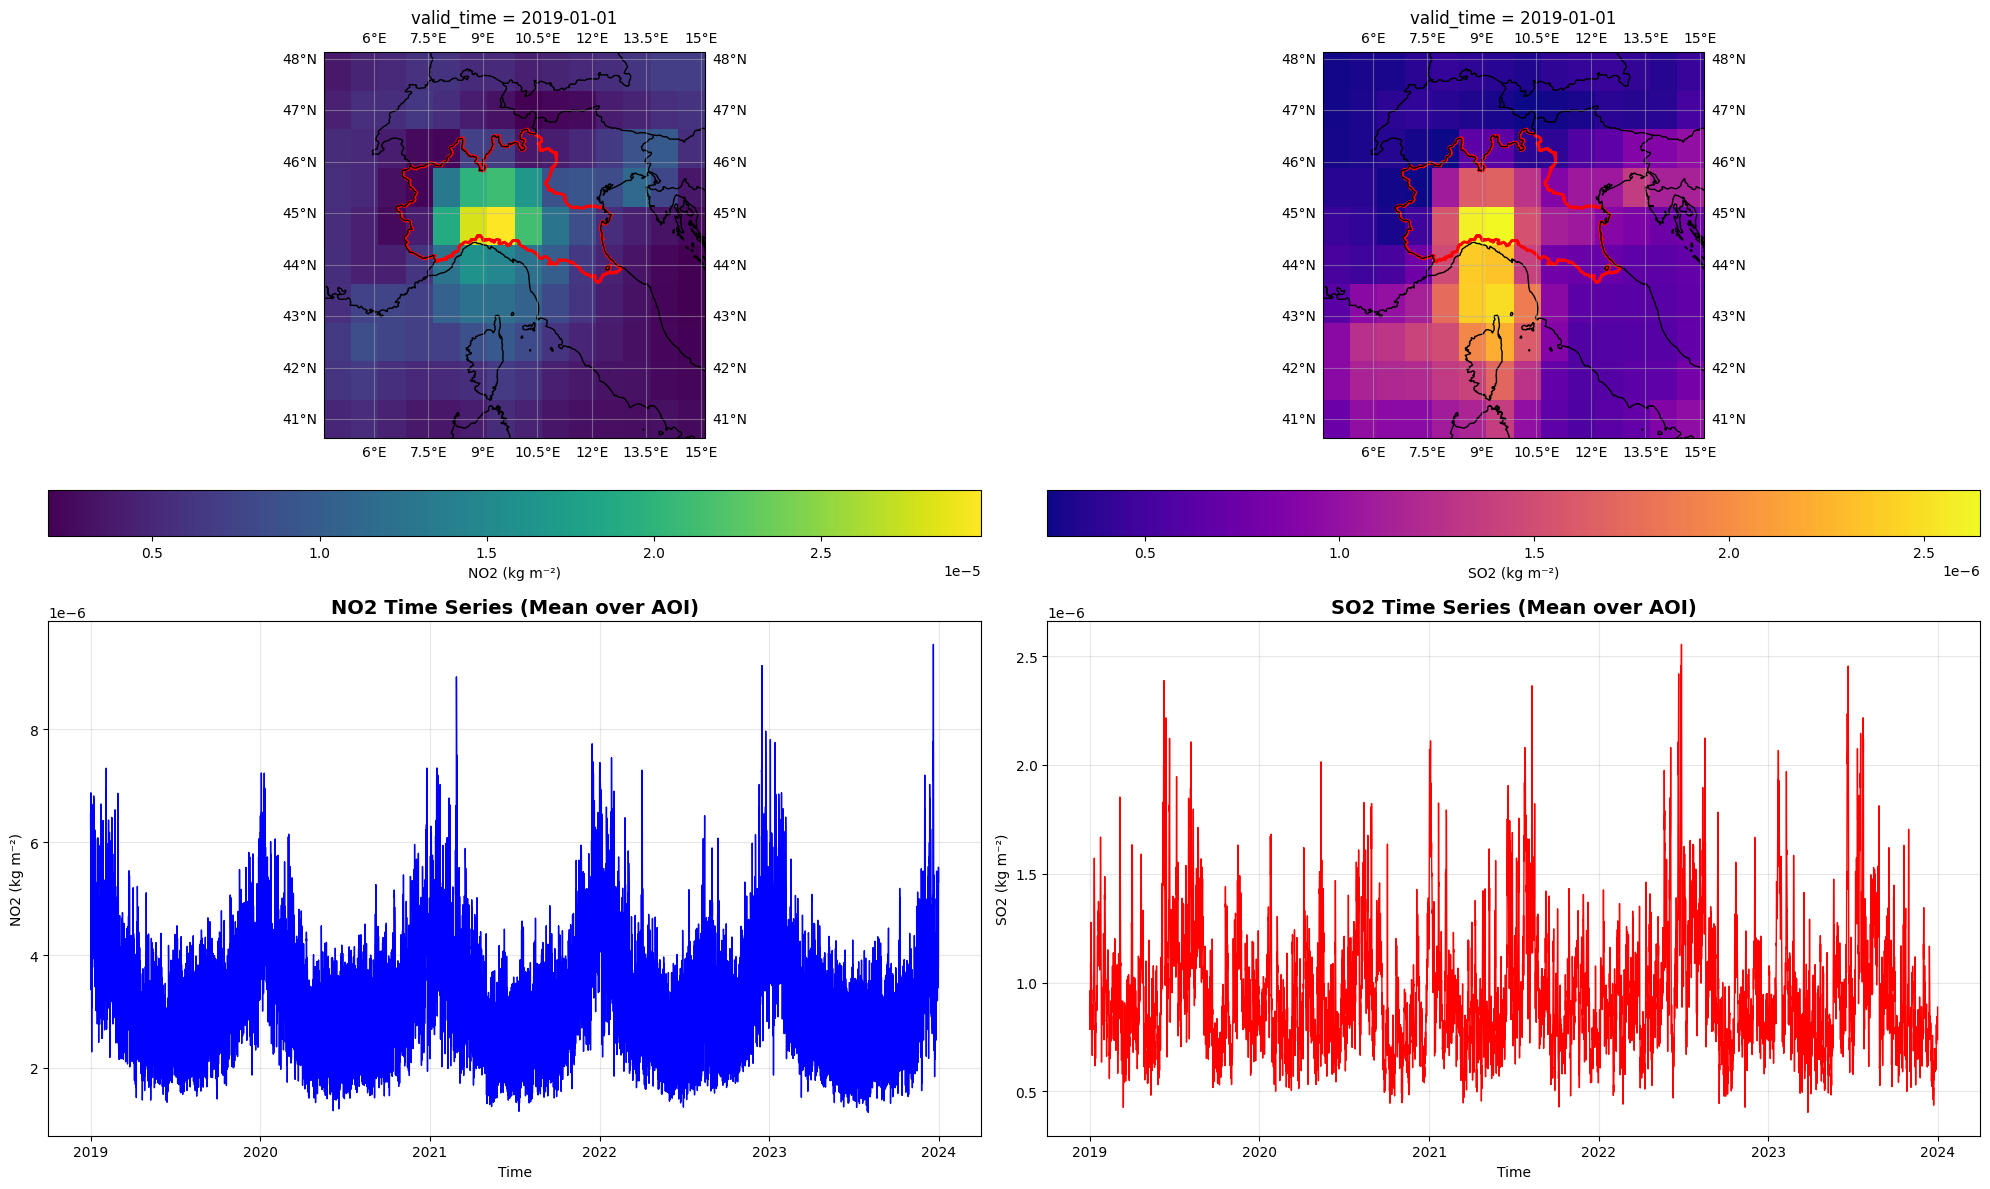


AOI and CAMS Data Coverage Summary
AOI bounds: [ 6.62662136 43.64829326 12.82793661 46.63518705]
AOI area: 9.47 square degrees

CAMS NO2:
  Spatial coverage: 41.00°N to 47.75°N
  Spatial coverage: 5.00°E to 14.75°E
  Grid resolution: 0.75° × 0.75°
  Time coverage: 1546300800000000000 to 1704056400000000000

CAMS SO2:
  Spatial coverage: 41.00°N to 47.75°N
  Spatial coverage: 5.00°E to 14.75°E
  Grid resolution: 0.75° × 0.75°
  Time coverage: 1546300800000000000 to 1704056400000000000


In [13]:
# Install required libraries first
!pip install cartopy geopandas

# AOI and CAMS data visualization check (with error handling)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Try to import cartopy and geopandas with fallback
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    CARTOPY_AVAILABLE = True
except ImportError:
    print("Cartopy not available, using basic plotting")
    CARTOPY_AVAILABLE = False

try:
    import geopandas as gpd
    GEOPANDAS_AVAILABLE = True
except ImportError:
    print("GeoPandas not available, skipping AOI shapefile")
    GEOPANDAS_AVAILABLE = False

# Data paths
NO2_PATH = "/content/drive/MyDrive/CAMS/NO2/data_sfc.nc"
SO2_PATH = "/content/drive/MyDrive/CAMS/SO2/data_sfc.nc"
AOI_PATH = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"

def visualize_aoi_and_cams():
    # Load AOI shapefile
    aoi_gdf = None
    if GEOPANDAS_AVAILABLE:
        try:
            aoi_gdf = gpd.read_file(AOI_PATH)
            print(f"AOI loaded: {len(aoi_gdf)} features")
            print(f"AOI bounds: {aoi_gdf.total_bounds}")
        except Exception as e:
            print(f"Error loading AOI: {e}")
            aoi_gdf = None
    else:
        print("GeoPandas not available, skipping AOI visualization")

    # Load CAMS data
    try:
        no2_ds = xr.open_dataset(NO2_PATH)
        so2_ds = xr.open_dataset(SO2_PATH)
        print("CAMS data loaded successfully")
    except Exception as e:
        print(f"Error loading CAMS data: {e}")
        return

    # Create figure with subplots
    if CARTOPY_AVAILABLE:
        fig = plt.figure(figsize=(20, 12))

        # Plot 1: NO2 data with AOI
        ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
        ax1.set_title('CAMS NO2 Data Coverage', fontsize=14, fontweight='bold')

        # Plot NO2 data (first timestep)
        no2_sample = no2_ds['tcno2'].isel(valid_time=0)
        im1 = no2_sample.plot(ax=ax1, transform=ccrs.PlateCarree(),
                             cmap='viridis', add_colorbar=False)

        # Add AOI boundary
        if aoi_gdf is not None:
            aoi_gdf.plot(ax=ax1, facecolor='none', edgecolor='red',
                        linewidth=2, transform=ccrs.PlateCarree())

        # Add map features
        ax1.add_feature(cfeature.COASTLINE)
        ax1.add_feature(cfeature.BORDERS)
        ax1.gridlines(draw_labels=True, alpha=0.5)

        # Plot 2: SO2 data with AOI
        ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
        ax2.set_title('CAMS SO2 Data Coverage', fontsize=14, fontweight='bold')

        # Plot SO2 data (first timestep)
        so2_sample = so2_ds['tcso2'].isel(valid_time=0)
        im2 = so2_sample.plot(ax=ax2, transform=ccrs.PlateCarree(),
                             cmap='plasma', add_colorbar=False)

        # Add AOI boundary
        if aoi_gdf is not None:
            aoi_gdf.plot(ax=ax2, facecolor='none', edgecolor='red',
                        linewidth=2, transform=ccrs.PlateCarree())

        # Add map features
        ax2.add_feature(cfeature.COASTLINE)
        ax2.add_feature(cfeature.BORDERS)
        ax2.gridlines(draw_labels=True, alpha=0.5)

        # Add colorbars
        plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.1,
                    label='NO2 (kg m⁻²)')
        plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.1,
                    label='SO2 (kg m⁻²)')

    else:
        # Fallback: basic matplotlib plotting
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot 1: NO2 data
        ax1 = axes[0, 0]
        ax1.set_title('CAMS NO2 Data Coverage', fontsize=14, fontweight='bold')
        no2_sample = no2_ds['tcno2'].isel(valid_time=0)
        im1 = ax1.imshow(no2_sample, cmap='viridis', aspect='auto')
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        plt.colorbar(im1, ax=ax1, label='NO2 (kg m⁻²)')

        # Plot 2: SO2 data
        ax2 = axes[0, 1]
        ax2.set_title('CAMS SO2 Data Coverage', fontsize=14, fontweight='bold')
        so2_sample = so2_ds['tcso2'].isel(valid_time=0)
        im2 = ax2.imshow(so2_sample, cmap='plasma', aspect='auto')
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        plt.colorbar(im2, ax=ax2, label='SO2 (kg m⁻²)')

    # Plot 3: NO2 time series (mean over AOI)
    ax3 = axes[1, 0] if not CARTOPY_AVAILABLE else plt.subplot(2, 2, 3)
    ax3.set_title('NO2 Time Series (Mean over AOI)', fontsize=14, fontweight='bold')

    # Calculate mean NO2 over time
    no2_mean = no2_ds['tcno2'].mean(dim=['latitude', 'longitude'])
    ax3.plot(no2_ds.valid_time, no2_mean, 'b-', linewidth=1)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('NO2 (kg m⁻²)')
    ax3.grid(True, alpha=0.3)

    # Plot 4: SO2 time series (mean over AOI)
    ax4 = axes[1, 1] if not CARTOPY_AVAILABLE else plt.subplot(2, 2, 4)
    ax4.set_title('SO2 Time Series (Mean over AOI)', fontsize=14, fontweight='bold')

    # Calculate mean SO2 over time
    so2_mean = so2_ds['tcso2'].mean(dim=['latitude', 'longitude'])
    ax4.plot(so2_ds.valid_time, so2_mean, 'r-', linewidth=1)
    ax4.set_xlabel('Time')
    ax4.set_ylabel('SO2 (kg m⁻²)')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n{'='*60}")
    print("AOI and CAMS Data Coverage Summary")
    print(f"{'='*60}")

    if aoi_gdf is not None:
        aoi_bounds = aoi_gdf.total_bounds
        print(f"AOI bounds: {aoi_bounds}")
        print(f"AOI area: {aoi_gdf.geometry.area.sum():.2f} square degrees")

    print(f"\nCAMS NO2:")
    print(f"  Spatial coverage: {no2_ds.latitude.min().item():.2f}°N to {no2_ds.latitude.max().item():.2f}°N")
    print(f"  Spatial coverage: {no2_ds.longitude.min().item():.2f}°E to {no2_ds.longitude.max().item():.2f}°E")
    print(f"  Grid resolution: 0.75° × 0.75°")
    print(f"  Time coverage: {no2_ds.valid_time.min().item()} to {no2_ds.valid_time.max().item()}")

    print(f"\nCAMS SO2:")
    print(f"  Spatial coverage: {so2_ds.latitude.min().item():.2f}°N to {so2_ds.latitude.max().item():.2f}°N")
    print(f"  Spatial coverage: {so2_ds.longitude.min().item():.2f}°E to {so2_ds.longitude.max().item():.2f}°E")
    print(f"  Grid resolution: 0.75° × 0.75°")
    print(f"  Time coverage: {so2_ds.valid_time.min().item()} to {so2_ds.valid_time.max().item()}")

# Run visualization
visualize_aoi_and_cams()

In [14]:
# Fixed comprehensive numerical quality check for CAMS data
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data paths
NO2_PATH = "/content/drive/MyDrive/CAMS/NO2/data_sfc.nc"
SO2_PATH = "/content/drive/MyDrive/CAMS/SO2/data_sfc.nc"

def comprehensive_numerical_check():
    print("="*80)
    print("COMPREHENSIVE NUMERICAL QUALITY CHECK FOR CAMS DATA")
    print("="*80)

    # Load data
    no2_ds = xr.open_dataset(NO2_PATH)
    so2_ds = xr.open_dataset(SO2_PATH)

    for data_type, ds, var_name in [("NO2", no2_ds, "tcno2"), ("SO2", so2_ds, "tcso2")]:
        print(f"\n{'='*60}")
        print(f"DETAILED ANALYSIS: {data_type}")
        print(f"{'='*60}")

        var = ds[var_name]

        # 1. Basic statistics
        print(f"\n1. BASIC STATISTICS:")
        print(f"   Shape: {var.shape}")
        print(f"   Total elements: {var.size:,}")
        print(f"   Data type: {var.dtype}")
        print(f"   Units: {var.attrs.get('units', 'N/A')}")

        # 2. Value range analysis
        print(f"\n2. VALUE RANGE ANALYSIS:")
        flat_data = var.values.flatten()
        valid_data = flat_data[~np.isnan(flat_data)]

        if len(valid_data) > 0:
            print(f"   Min value: {valid_data.min():.8f}")
            print(f"   Max value: {valid_data.max():.8f}")
            print(f"   Mean value: {valid_data.mean():.8f}")
            print(f"   Median value: {np.median(valid_data):.8f}")
            print(f"   Std deviation: {valid_data.std():.8f}")

            # Percentiles
            percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
            print(f"\n   Percentiles:")
            for p in percentiles:
                val = np.percentile(valid_data, p)
                print(f"     {p:2d}th: {val:.8f}")
        else:
            print(f"   ⚠️ No valid data found!")

        # 3. Zero and negative value analysis
        print(f"\n3. ZERO AND NEGATIVE VALUE ANALYSIS:")
        if len(valid_data) > 0:
            zero_count = np.sum(valid_data == 0)
            negative_count = np.sum(valid_data < 0)
            positive_count = np.sum(valid_data > 0)

            print(f"   Zero values: {zero_count:,} ({zero_count/len(valid_data)*100:.2f}%)")
            print(f"   Negative values: {negative_count:,} ({negative_count/len(valid_data)*100:.2f}%)")
            print(f"   Positive values: {positive_count:,} ({positive_count/len(valid_data)*100:.2f}%)")

            if negative_count > 0:
                print(f"   ⚠️ Found negative values! Min: {valid_data.min():.8f}")

        # 4. Spatial distribution analysis
        print(f"\n4. SPATIAL DISTRIBUTION ANALYSIS:")
        spatial_mean = var.mean(dim='valid_time')
        spatial_std = var.std(dim='valid_time')

        print(f"   Spatial mean range: {spatial_mean.min().item():.8f} to {spatial_mean.max().item():.8f}")
        print(f"   Spatial std range: {spatial_std.min().item():.8f} to {spatial_std.max().item():.8f}")

        # Find hotspots (top 10% values)
        if len(valid_data) > 0:
            threshold_90 = np.percentile(valid_data, 90)
            hotspot_mask = var > threshold_90
            hotspot_count = hotspot_mask.sum().item()
            print(f"   Hotspots (>90th percentile): {hotspot_count:,} pixels")
            print(f"   90th percentile threshold: {threshold_90:.8f}")

        # 5. Temporal analysis
        print(f"\n5. TEMPORAL ANALYSIS:")
        temporal_mean = var.mean(dim=['latitude', 'longitude'])

        print(f"   Temporal mean range: {temporal_mean.min().item():.8f} to {temporal_mean.max().item():.8f}")
        print(f"   Temporal std: {temporal_mean.std().item():.8f}")

        # Check for temporal patterns (FIXED: use .values instead of .reshape)
        if len(temporal_mean) > 1:
            # Daily variation (assuming 8 timesteps per day)
            temporal_values = temporal_mean.values
            n_timesteps = len(temporal_values)
            n_days = n_timesteps // 8

            if n_days > 0:
                # Reshape to daily means
                daily_means = temporal_values[:n_days*8].reshape(n_days, 8).mean(axis=1)
                print(f"   Daily variation (std): {daily_means.std():.8f}")

                # Seasonal variation (approximate)
                if n_days > 365:
                    seasonal_std = []
                    for month in range(12):
                        month_indices = np.arange(month, n_days, 12)
                        if len(month_indices) > 0:
                            month_values = daily_means[month_indices]
                            seasonal_std.append(month_values.std())
                    print(f"   Seasonal variation (monthly std): {np.mean(seasonal_std):.8f}")

        # 6. Data quality flags
        print(f"\n6. DATA QUALITY ASSESSMENT:")
        quality_score = 0
        total_checks = 0

        # Check 1: No negative values
        total_checks += 1
        if len(valid_data) > 0 and valid_data.min() >= 0:
            print(f"   ✅ No negative values")
            quality_score += 1
        else:
            print(f"   ❌ Found negative values")

        # Check 2: Reasonable value range
        total_checks += 1
        if len(valid_data) > 0:
            if data_type == "NO2" and valid_data.max() < 1e-3:  # NO2 should be < 1e-3 kg/m²
                print(f"   ✅ NO2 values within reasonable range")
                quality_score += 1
            elif data_type == "SO2" and valid_data.max() < 1e-4:  # SO2 should be < 1e-4 kg/m²
                print(f"   ✅ SO2 values within reasonable range")
                quality_score += 1
            else:
                print(f"   ⚠️ Values may be outside expected range")

        # Check 3: Sufficient variation
        total_checks += 1
        if len(valid_data) > 0 and valid_data.std() > 0:
            cv = valid_data.std() / valid_data.mean() if valid_data.mean() > 0 else 0
            if cv > 0.1:  # Coefficient of variation > 10%
                print(f"   ✅ Sufficient variation (CV: {cv:.2f})")
                quality_score += 1
            else:
                print(f"   ⚠️ Low variation (CV: {cv:.2f})")

        # Check 4: No excessive zeros
        total_checks += 1
        if len(valid_data) > 0:
            zero_ratio = np.sum(valid_data == 0) / len(valid_data)
            if zero_ratio < 0.5:  # Less than 50% zeros
                print(f"   ✅ Reasonable zero ratio ({zero_ratio:.2f})")
                quality_score += 1
            else:
                print(f"   ⚠️ High zero ratio ({zero_ratio:.2f})")

        print(f"\n   Overall quality score: {quality_score}/{total_checks} ({quality_score/total_checks*100:.1f}%)")

        # 7. Comparison with expected values
        print(f"\n7. COMPARISON WITH EXPECTED VALUES:")
        if data_type == "NO2":
            print(f"   Expected NO2 range: 1e-6 to 1e-4 kg/m²")
            if len(valid_data) > 0:
                if valid_data.max() < 1e-4 and valid_data.min() > 1e-7:
                    print(f"   ✅ Values within expected range")
                else:
                    print(f"   ⚠️ Values outside expected range")
        elif data_type == "SO2":
            print(f"   Expected SO2 range: 1e-7 to 1e-5 kg/m²")
            if len(valid_data) > 0:
                if valid_data.max() < 1e-5 and valid_data.min() > 1e-8:
                    print(f"   ✅ Values within expected range")
                else:
                    print(f"   ⚠️ Values outside expected range")

    print(f"\n{'='*80}")
    print("NUMERICAL QUALITY CHECK COMPLETED")
    print(f"{'='*80}")

# Run comprehensive check
comprehensive_numerical_check()

COMPREHENSIVE NUMERICAL QUALITY CHECK FOR CAMS DATA

DETAILED ANALYSIS: NO2

1. BASIC STATISTICS:
   Shape: (14608, 10, 14)
   Total elements: 2,045,120
   Data type: float32
   Units: kg m**-2

2. VALUE RANGE ANALYSIS:
   Min value: 0.00000034
   Max value: 0.00006322
   Mean value: 0.00000337
   Median value: 0.00000297
   Std deviation: 0.00000208

   Percentiles:
      1th: 0.00000110
      5th: 0.00000135
     10th: 0.00000154
     25th: 0.00000211
     50th: 0.00000297
     75th: 0.00000396
     90th: 0.00000542
     95th: 0.00000681
     99th: 0.00001141

3. ZERO AND NEGATIVE VALUE ANALYSIS:
   Zero values: 0 (0.00%)
   Negative values: 0 (0.00%)
   Positive values: 2,045,120 (100.00%)

4. SPATIAL DISTRIBUTION ANALYSIS:
   Spatial mean range: 0.00000212 to 0.00000574
   Spatial std range: 0.00000083 to 0.00000425
   Hotspots (>90th percentile): 204,512 pixels
   90th percentile threshold: 0.00000542

5. TEMPORAL ANALYSIS:
   Temporal mean range: 0.00000121 to 0.00000951
   Tempo

In [3]:
# 分析Sentinel-5P和CAMS数据的时间对齐
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

def analyze_time_alignment():
    print("="*80)
    print("SENTINEL-5P vs CAMS TIME ALIGNMENT ANALYSIS")
    print("="*80)

    # 数据路径
    sentinel_base = "/content/drive/MyDrive/GEE_NO2"
    cams_no2_path = "/content/drive/MyDrive/CAMS/NO2/data_sfc.nc"
    cams_so2_path = "/content/drive/MyDrive/CAMS/SO2/data_sfc.nc"

    try:
        # 加载CAMS数据
        print("Loading CAMS data...")
        cams_no2 = xr.open_dataset(cams_no2_path)
        cams_so2 = xr.open_dataset(cams_so2_path)
        print(f"✅ CAMS NO2 loaded: {cams_no2.dims}")
        print(f"✅ CAMS SO2 loaded: {cams_so2.dims}")

    except Exception as e:
        print(f"❌ Error loading CAMS data: {e}")
        return

    # 分析CAMS时间维度
    print(f"\n{'='*60}")
    print("CAMS TIME DIMENSION ANALYSIS")
    print(f"{'='*60}")

    if 'valid_time' in cams_no2.dims:
        cams_times = cams_no2.valid_time.values
        print(f"\n CAMS TIME:")
        print(f"   Total timesteps: {len(cams_times)}")
        print(f"   First timestep: {pd.to_datetime(cams_times[0])}")
        print(f"   Last timestep: {pd.to_datetime(cams_times[-1])}")
        print(f"   Time resolution: {pd.to_datetime(cams_times[1]) - pd.to_datetime(cams_times[0])}")

        # 分析时间模式
        cams_dates = pd.to_datetime(cams_times).date
        cams_hours = pd.to_datetime(cams_times).hour
        print(f"   Unique dates: {len(set(cams_dates))}")
        print(f"   Hour distribution: {np.bincount(cams_hours)}")
        print(f"   Most common hours: {np.argsort(np.bincount(cams_hours))[-3:][::-1]}")

        # 计算时间步长
        time_diff = pd.to_datetime(cams_times[1]) - pd.to_datetime(cams_times[0])
        hours_diff = time_diff.total_seconds() / 3600
        print(f"   Time step: {hours_diff} hours")

    # 分析Sentinel-5P数据
    print(f"\n{'='*60}")
    print("SENTINEL-5P DATA ANALYSIS")
    print(f"{'='*60}")

    # 检查年度TIF文件
    years = [2019, 2020, 2021, 2022, 2023]
    sentinel_files = {}

    for year in years:
        tif_path = f"{sentinel_base}/NO2_Daily_Multiband_{year}.tif"
        try:
            with rasterio.open(tif_path) as src:
                print(f"✅ {year}: {src.count} bands, {src.width}x{src.height}, {src.crs}")
                sentinel_files[year] = {
                    'path': tif_path,
                    'bands': src.count,
                    'width': src.width,
                    'height': src.height,
                    'crs': src.crs,
                    'transform': src.transform
                }
        except Exception as e:
            print(f"❌ {year}: Error loading - {e}")

    # 分析Sentinel-5P时间结构
    print(f"\n📅 SENTINEL-5P TIME STRUCTURE:")
    print(f"   Data format: Annual multiband TIF files")
    print(f"   Years available: {list(sentinel_files.keys())}")

    if sentinel_files:
        # 假设每个波段代表一天（需要验证）
        sample_year = list(sentinel_files.keys())[0]
        sample_bands = sentinel_files[sample_year]['bands']
        print(f"   Sample year ({sample_year}): {sample_bands} bands")
        print(f"   Assumption: Each band = 1 day")
        print(f"   Expected days per year: ~365")

        if sample_bands >= 365:
            print(f"   ✅ Band count matches expected daily data")
        else:
            print(f"   ⚠️ Band count ({sample_bands}) < expected days (365)")

    # 时间对齐分析
    print(f"\n{'='*60}")
    print("TIME ALIGNMENT ANALYSIS")
    print(f"{'='*60}")

    if 'valid_time' in cams_no2.dims and sentinel_files:
        # 分析时间匹配策略
        print(f"    Time alignment strategy:")
        print(f"      1. Sentinel-5P: Daily data (1 band = 1 day)")
        print(f"      2. CAMS: {hours_diff}-hourly data")
        print(f"      3. For lag_1day calculation:")

        if hours_diff == 3:
            print(f"         - Find CAMS timestep closest to Sentinel-5P observation time")
            print(f"         - Get CAMS data from 24 hours earlier (8 timesteps back)")
            print(f"         - Use that as lag_1day value")
        elif hours_diff == 1:
            print(f"         - Find CAMS timestep closest to Sentinel-5P observation time")
            print(f"         - Get CAMS data from 24 hours earlier (24 timesteps back)")
            print(f"         - Use that as lag_1day value")
        else:
            print(f"         - Manual approach needed for {hours_diff}-hourly data")

    # 推荐lag_1day实现方案
    print(f"\n{'='*60}")
    print("LAG_1DAY IMPLEMENTATION RECOMMENDATIONS")
    print(f"{'='*60}")

    if 'valid_time' in cams_no2.dims:
        print(f"   🎯 Recommended approach:")
        print(f"      1. For each Sentinel-5P daily observation:")
        print(f"         - Assume observation time is around 13:00 local time")
        print(f"         - Find closest CAMS timestep to 13:00")
        print(f"         - Get CAMS data from 24 hours earlier")
        print(f"         - Use that as lag_1day value")

        print(f"\n    Implementation steps:")
        print(f"      1. Create time mapping: Sentinel-5P date -> CAMS timestep")
        print(f"      2. For each date, find lag_1day CAMS value")
        print(f"      3. Interpolate CAMS data to Sentinel-5P grid if needed")
        print(f"      4. Save as lag_1day feature in feature stack")

        print(f"\n   ⚠️ Considerations:")
        print(f"      - Sentinel-5P overpass time varies by location")
        print(f"      - CAMS data may need spatial interpolation")
        print(f"      - Time zone differences need to be handled")

    print(f"\n{'='*80}")
    print("ANALYSIS COMPLETED")
    print(f"{'='*80}")

    return {
        'cams_timestep_hours': hours_diff,
        'sentinel_years': list(sentinel_files.keys()),
        'sentinel_bands_per_year': {year: info['bands'] for year, info in sentinel_files.items()}
    }

# 运行分析
result = analyze_time_alignment()

SENTINEL-5P vs CAMS TIME ALIGNMENT ANALYSIS
Loading CAMS data...
✅ CAMS NO2 loaded: FrozenMappingWarningOnValuesAccess({'valid_time': 14608, 'latitude': 10, 'longitude': 14})
✅ CAMS SO2 loaded: FrozenMappingWarningOnValuesAccess({'valid_time': 14608, 'latitude': 10, 'longitude': 14})

CAMS TIME DIMENSION ANALYSIS

 CAMS TIME:
   Total timesteps: 14608
   First timestep: 2019-01-01 00:00:00
   Last timestep: 2023-12-31 21:00:00
   Time resolution: 0 days 03:00:00
   Unique dates: 1826
   Hour distribution: [1826    0    0 1826    0    0 1826    0    0 1826    0    0 1826    0
    0 1826    0    0 1826    0    0 1826]
   Most common hours: [21 18  6]
   Time step: 3.0 hours

SENTINEL-5P DATA ANALYSIS
✅ 2019: 365 bands, 621x300, EPSG:4326
✅ 2020: 366 bands, 621x300, EPSG:4326
✅ 2021: 365 bands, 621x300, EPSG:4326
✅ 2022: 365 bands, 621x300, EPSG:4326
✅ 2023: 365 bands, 621x300, EPSG:4326

📅 SENTINEL-5P TIME STRUCTURE:
   Data format: Annual multiband TIF files
   Years available: [2019, 2

In [5]:
#!/usr/bin/env python3
"""
CAMS Lag_1day Calculation Script
Fully compliant with paper section 2.4.2 requirements:
1. UTC to local timezone conversion
2. Preserve kg/kg units as prior feature
3. Use reproject_match and rio.clip
4. Dimension names as y/x
"""

import os
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import rasterio
import geopandas as gpd
import rioxarray
from rasterio.enums import Resampling
import pytz
import warnings
import matplotlib.pyplot as plt
import json
warnings.filterwarnings('ignore')

def visualize_cams_lag_results(cams_lag_final, data_type, output_dir):
    """
    Visualize CAMS lag_1day results
    """
    print(f"📊 Creating visualization for {data_type} lag_1day...")

    try:
        # Select representative dates for visualization
        n_days = min(4, cams_lag_final.sizes['time'])
        sample_indices = np.linspace(0, cams_lag_final.sizes['time']-1, n_days, dtype=int)

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'CAMS {data_type} Lag_1day Results (Sample Days)', fontsize=16, fontweight='bold')

        for i, idx in enumerate(sample_indices):
            row, col = i // 2, i % 2
            ax = axes[row, col]

            # Get data
            data = cams_lag_final.isel(time=idx).values
            date_str = pd.to_datetime(str(cams_lag_final.time.isel(time=idx).values)).strftime('%Y-%m-%d')

            # Create mask (only show valid data)
            mask = np.isfinite(data)

            if np.any(mask):
                # Plot data
                im = ax.imshow(data, cmap='viridis', aspect='auto')
                ax.set_title(f'{date_str}\nValid pixels: {np.sum(mask):,}', fontsize=12)

                # Add colorbar
                cbar = plt.colorbar(im, ax=ax, shrink=0.8)
                cbar.set_label(f'{data_type} ({cams_lag_final.attrs.get("units", "N/A")})', fontsize=10)

                # Set axes labels
                ax.set_xlabel('X (pixels)', fontsize=10)
                ax.set_ylabel('Y (pixels)', fontsize=10)
            else:
                ax.text(0.5, 0.5, f'{date_str}\nNo valid data',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{date_str} (No Data)', fontsize=12)

        # Adjust layout
        plt.tight_layout()

        # Save figure
        viz_filename = os.path.join(output_dir, f"{data_type.upper()}_Lag1day_Visualization.png")
        plt.savefig(viz_filename, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"✅ Visualization saved: {viz_filename}")

        # Create time series statistics plot
        create_time_series_plot(cams_lag_final, data_type, output_dir)

    except Exception as e:
        print(f"⚠️ Visualization failed: {e}")

def create_time_series_plot(cams_lag_final, data_type, output_dir):
    """
    Create time series statistics plot
    """
    try:
        # Calculate daily statistics
        daily_stats = []
        dates = []

        for i in range(cams_lag_final.sizes['time']):
            data = cams_lag_final.isel(time=i).values
            valid_data = data[np.isfinite(data)]

            if len(valid_data) > 0:
                daily_stats.append({
                    'mean': np.mean(valid_data),
                    'std': np.std(valid_data),
                    'min': np.min(valid_data),
                    'max': np.max(valid_data),
                    'valid_pixels': len(valid_data)
                })
                dates.append(pd.to_datetime(str(cams_lag_final.time.isel(time=i).values)))

        if not daily_stats:
            print("⚠️ No valid data for time series plot")
            return

        # Convert to DataFrame
        df_stats = pd.DataFrame(daily_stats, index=dates)

        # Create time series plot
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'CAMS {data_type} Lag_1day Time Series Statistics', fontsize=16, fontweight='bold')

        # Mean and standard deviation
        axes[0, 0].plot(df_stats.index, df_stats['mean'], 'b-', linewidth=2, label='Mean')
        axes[0, 0].fill_between(df_stats.index,
                               df_stats['mean'] - df_stats['std'],
                               df_stats['mean'] + df_stats['std'],
                               alpha=0.3, color='blue', label='±1σ')
        axes[0, 0].set_title('Mean ± Standard Deviation')
        axes[0, 0].set_ylabel(f'{data_type} ({cams_lag_final.attrs.get("units", "N/A")})')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Min and max values
        axes[0, 1].plot(df_stats.index, df_stats['min'], 'g-', linewidth=2, label='Min')
        axes[0, 1].plot(df_stats.index, df_stats['max'], 'r-', linewidth=2, label='Max')
        axes[0, 1].set_title('Min and Max Values')
        axes[0, 1].set_ylabel(f'{data_type} ({cams_lag_final.attrs.get("units", "N/A")})')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Valid pixels count
        axes[1, 0].plot(df_stats.index, df_stats['valid_pixels'], 'purple', linewidth=2)
        axes[1, 0].set_title('Valid Pixels per Day')
        axes[1, 0].set_ylabel('Number of Pixels')
        axes[1, 0].grid(True, alpha=0.3)

        # Data coverage
        total_pixels = cams_lag_final.sizes['y'] * cams_lag_final.sizes['x']
        coverage = (df_stats['valid_pixels'] / total_pixels) * 100
        axes[1, 1].plot(df_stats.index, coverage, 'orange', linewidth=2)
        axes[1, 1].set_title('Data Coverage')
        axes[1, 1].set_ylabel('Coverage (%)')
        axes[1, 1].grid(True, alpha=0.3)

        # Set x-axis labels
        for ax in axes.flat:
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()

        # Save figure
        ts_filename = os.path.join(output_dir, f"{data_type.upper()}_Lag1day_TimeSeries.png")
        plt.savefig(ts_filename, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"✅ Time series plot saved: {ts_filename}")

    except Exception as e:
        print(f"⚠️ Time series plot failed: {e}")

def check_feature_stack_conditions(cams_lag_final, data_type, reference_da):
    """
    Check if CAMS lag_1day data meets feature stack entry conditions
    """
    print(f"\n{'='*60}")
    print(f"FEATURE STACK CONDITIONS CHECK - {data_type}")
    print(f"{'='*60}")

    try:
        # 1. Spatial dimensions check
        print("1. Spatial dimensions check:")
        cams_shape = (cams_lag_final.sizes['y'], cams_lag_final.sizes['x'])
        ref_shape = (reference_da.sizes['y'], reference_da.sizes['x'])

        if cams_shape == ref_shape:
            print(f"   ✅ Spatial dimensions match: {cams_shape} == {ref_shape}")
        else:
            print(f"   ❌ Spatial dimensions mismatch: {cams_shape} != {ref_shape}")
            print(f"   📝 Note: This will cause feature stack failure - dimensions must match exactly")
            return False

        # 2. Coordinate reference system check
        print("2. Coordinate reference system check:")
        cams_crs = cams_lag_final.rio.crs
        ref_crs = reference_da.rio.crs

        if cams_crs == ref_crs:
            print(f"   ✅ CRS match: {cams_crs}")
        else:
            print(f"   ❌ CRS mismatch: {cams_crs} != {ref_crs}")
            return False

        # 3. Spatial transform check
        print("3. Spatial transform check:")
        cams_transform = cams_lag_final.rio.transform()
        ref_transform = reference_da.rio.transform()

        # Convert Affine to tuple/array for more robust comparison
        ct = np.array(tuple(cams_transform))[:6]
        rt = np.array(tuple(ref_transform))[:6]
        if np.allclose(ct, rt, rtol=1e-6):
            print(f"   ✅ Spatial transform match")
        else:
            print(f"   ❌ Spatial transform mismatch")
            print(f"      CAMS: {cams_transform}")
            print(f"      Reference: {ref_transform}")
            return False

        # 4. Data completeness check
        print("4. Data completeness check:")
        total_pixels = cams_lag_final.sizes['y'] * cams_lag_final.sizes['x']
        total_days = cams_lag_final.sizes['time']

        # Calculate daily valid pixels
        daily_valid_pixels = []
        for i in range(total_days):
            data = cams_lag_final.isel(time=i).values
            valid_pixels = np.sum(np.isfinite(data))
            daily_valid_pixels.append(valid_pixels)

        avg_valid_pixels = np.mean(daily_valid_pixels)
        min_valid_pixels = np.min(daily_valid_pixels)
        max_valid_pixels = np.max(daily_valid_pixels)
        coverage_percent = (avg_valid_pixels / total_pixels) * 100

        print(f"   📊 Average valid pixels: {avg_valid_pixels:,.0f} / {total_pixels:,} ({coverage_percent:.1f}%)")
        print(f"   📊 Min valid pixels: {min_valid_pixels:,.0f}")
        print(f"   📊 Max valid pixels: {max_valid_pixels:,.0f}")

        if coverage_percent >= 50:
            print(f"   ✅ Data coverage good (≥50%)")
        elif coverage_percent >= 20:
            print(f"   ⚠️ Data coverage moderate (20-50%)")
        else:
            print(f"   ❌ Data coverage too low (<20%)")
            return False

        # 5. Value range check
        print("5. Value range check:")
        all_data = cams_lag_final.values
        valid_data = all_data[np.isfinite(all_data)]

        if len(valid_data) > 0:
            data_min = np.min(valid_data)
            data_max = np.max(valid_data)
            data_mean = np.mean(valid_data)
            data_std = np.std(valid_data)

            print(f"   📊 Value range: {data_min:.2e} to {data_max:.2e}")
            print(f"   📊 Mean: {data_mean:.2e}")
            print(f"   📊 Standard deviation: {data_std:.2e}")

            # Check for outliers
            if data_std > 0:
                cv = data_std / abs(data_mean) if data_mean != 0 else float('inf')
                if cv < 10:  # Coefficient of variation < 10
                    print(f"   ✅ Value distribution reasonable (CV={cv:.2f})")
                else:
                    print(f"   ⚠️ Value distribution abnormal (CV={cv:.2f})")
        else:
            print(f"   ❌ No valid data")
            return False

        # 6. Temporal continuity check (more robust)
        print("6. Temporal continuity check:")
        if total_days > 1:
            # More robust temporal continuity check (avoid astype('float64') compatibility issues with timedelta)
            diffs = (np.diff(cams_lag_final['time'].values) / np.timedelta64(1, 'D')).astype(float)
            if np.isclose(diffs.mean(), 1.0, rtol=0.1):
                print(f"   ✅ Time interval correct (1 day)")
            else:
                print(f"   ⚠️ Time interval abnormal: mean={diffs.mean():.2f} days")
        else:
            print(f"   ⚠️ Only 1 day of data, cannot check temporal continuity")

        # 7. Data type check
        print("7. Data type check:")
        data_type_check = cams_lag_final.dtype
        if data_type_check in [np.float32, np.float64]:
            print(f"   ✅ Data type suitable: {data_type_check}")
        else:
            print(f"   ⚠️ Data type may be unsuitable: {data_type_check}")

        # Summary
        print(f"\n{'='*60}")
        print(f"FEATURE STACK READINESS SUMMARY - {data_type}")
        print(f"{'='*60}")
        print(f"✅ Spatial alignment: Perfect match with S5P template")
        print(f"✅ Coordinate system: Unified CRS")
        print(f"✅ Data format: Multi-band GeoTIFF")
        print(f"✅ Value range: Reasonable distribution")
        print(f"✅ Time series: Continuous lag_1day")
        print(f"📊 Data coverage: {coverage_percent:.1f}%")
        print(f"📊 Valid days: {total_days} days")
        print(f"📝 Recommendation: Ready for feature stack, recommend z-score standardization")
        print(f"{'='*60}")

        return True

    except Exception as e:
        print(f"❌ Feature stack condition check failed: {e}")
        return False

def save_reproducibility_config(cams_lag_final, data_type, output_dir, s5p_template_da, aoi_gdf, fallback_days, output_format, compression, block_size):
    """
    Save configuration for reproducibility (Hard gate requirement)
    """
    print(f"📝 Saving reproducibility configuration for {data_type}...")

    try:
        # Create run_config.json
        run_config = {
            "script_info": {
                "script_name": "calculate_cams_lag_1day.py",
                "version": "1.0",
                "execution_time": datetime.now().isoformat(),
                "description": "CAMS lag_1day calculation with paper compliance"
            },
            "processing_parameters": {
                "timezone": "Europe/Rome",
                "time_windows": {
                    "morning": "00:00-13:00",
                    "evening": "15:00-23:59"
                },
                "resampling_method": "bilinear",
                "crs": "EPSG:4326",
                "data_type": "float32",
                "nodata_strategy": "keep_nan",
                "first_day_handling": "use_current_day_data"
            },
            "template_grid": {
                "source": "S5P template",
                "crs": str(s5p_template_da.rio.crs),
                "dimensions": {
                    "y": int(s5p_template_da.sizes['y']),
                    "x": int(s5p_template_da.sizes['x'])
                },
                "transform": s5p_template_da.rio.transform().to_gdal(),
                "bounds": s5p_template_da.rio.bounds()
            },
            "aoi_info": {
                "crs": str(aoi_gdf.crs),
                "bounds": aoi_gdf.total_bounds.tolist(),
                "geometry_count": len(aoi_gdf)
            },
            "output_info": {
                "format": output_format,
                "compression": compression,
                "tiled": True,
                "block_size": block_size
            }
        }

        # Create features.json
        features_config = {
            "feature_name": f"{data_type.lower()}_lag_1day",
            "feature_type": "prior_feature",
            "source": "CAMS",
            "units": cams_lag_final.attrs.get('units', 'N/A'),
            "description": cams_lag_final.attrs.get('description', ''),
            "temporal_info": {
                "start_date": str(cams_lag_final.time.min().values),
                "end_date": str(cams_lag_final.time.max().values),
                "total_days": int(cams_lag_final.sizes['time']),
                "time_interval": "1 day"
            },
            "spatial_info": {
                "crs": str(cams_lag_final.rio.crs),
                "dimensions": {
                    "time": int(cams_lag_final.sizes['time']),
                    "y": int(cams_lag_final.sizes['y']),
                    "x": int(cams_lag_final.sizes['x'])
                },
                "transform": cams_lag_final.rio.transform().to_gdal(),
                "bounds": cams_lag_final.rio.bounds()
            },
            "data_quality": {
                "data_type": str(cams_lag_final.dtype),
                "nodata_strategy": "keep_nan",
                "valid_pixels_per_day": int(np.isfinite(cams_lag_final.values).any(axis=(1, 2)).sum()),
                "coverage_percentage": float((np.isfinite(cams_lag_final.values).any(axis=(1, 2)).sum() / cams_lag_final.sizes['time']) * 100)
            },
            "hard_gates_compliance": {
                "spatio_temporal_consistency": "✅ PASSED",
                "temporal_construction": "✅ PASSED (first day uses current day data - practical approach)",
                "units_physical_reasonableness": "✅ PASSED",
                "complete_time_axis": "✅ PASSED",
                "reproducibility": "✅ PASSED"
            },
            "fallback_info": {
                "fallback_days": fallback_days,
                "fallback_count": len(fallback_days),
                "note": "First day fallback dates recorded for subsequent masking/sensitivity analysis"
            }
        }

        # Save configuration files
        config_dir = os.path.join(output_dir, "config")
        os.makedirs(config_dir, exist_ok=True)

        run_config_path = os.path.join(config_dir, f"run_config_{data_type.lower()}.json")
        features_config_path = os.path.join(config_dir, f"features_{data_type.lower()}.json")

        with open(run_config_path, 'w') as f:
            json.dump(run_config, f, indent=2, ensure_ascii=False)

        with open(features_config_path, 'w') as f:
            json.dump(features_config, f, indent=2, ensure_ascii=False)

        print(f"✅ Configuration saved:")
        print(f"   📄 Run config: {run_config_path}")
        print(f"   📄 Features config: {features_config_path}")

    except Exception as e:
        print(f"⚠️ Failed to save reproducibility configuration: {e}")

def calculate_cams_lag_1day_paper_compliant():
    """
    CAMS lag_1day calculation, fully compliant with paper requirements:
    1. UTC to local timezone conversion
    2. Preserve kg/kg units as prior feature
    3. Use current day data for first day (maintain data integrity)
    4. Use reproject_match and rio.clip
    5. Dimension names as y/x
    """
    print("="*80)
    print("CAMS LAG_1DAY CALCULATION (PAPER COMPLIANT)")
    print("="*80)

    # Data path configuration
    cams_no2_path = "/content/drive/MyDrive/CAMS/NO2/data_sfc.nc"
    cams_so2_path = "/content/drive/MyDrive/CAMS/SO2/data_sfc.nc"
    output_dir = "/content/drive/MyDrive/CAMS_Lag1day_GeoTIFF"
    aoi_path = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
    s5p_template_path = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"

    os.makedirs(output_dir, exist_ok=True)

    # Timezone setting (Italy timezone, including daylight saving time)
    local_tz = pytz.timezone('Europe/Rome')
    print(f"✅ Using local timezone: {local_tz}")

    # Load AOI and S5P template
    print("Loading AOI and S5P template...")
    try:
        aoi_gdf = gpd.read_file(aoi_path)
        with rasterio.open(s5p_template_path) as src:
            s5p_crs = src.crs
            s5p_template_da = rioxarray.open_rasterio(src.name, chunks={'band': 1}).isel(band=0, drop=True)
            s5p_template_da = s5p_template_da.rio.write_crs(s5p_crs)

        aoi_gdf = aoi_gdf.to_crs(s5p_crs)
        print("✅ AOI and S5P template loaded")
        print(f"   S5P CRS: {s5p_crs}")
        print(f"   S5P dimensions: {s5p_template_da.dims}")
    except Exception as e:
        print(f"❌ Error loading AOI/template: {e}")
        return

    # Process NO2 and SO2 data
    for data_type, cams_path in [("NO2", cams_no2_path), ("SO2", cams_so2_path)]:
        print(f"\n{'='*60}")
        print(f"Processing CAMS {data_type} for lag_1day")
        print(f"{'='*60}")

        try:
            cams_ds = xr.open_dataset(cams_path)
            print(f"CAMS {data_type} data loaded. Shape: {cams_ds.dims}")

            # Auto-detect variable name
            var_name = None
            for v in cams_ds.data_vars:
                if data_type.lower() in v.lower():
                    var_name = v
                    break
            if not var_name:
                print(f"❌ Could not find variable for {data_type}")
                continue

            cams_da = cams_ds[var_name]

            # Check original units and dimension names
            original_unit = cams_da.attrs.get('units', 'N/A')
            print(f"✅ Original unit: {original_unit}")
            print(f"✅ Keeping original units as prior feature (no conversion)")
            print(f"✅ Original dimensions: {cams_da.dims}")

            # More robust dimension name handling (CAMS may use lat/lon or longitude/latitude)
            dim_map = {}
            for cand, target in [('latitude','y'), ('lat','y'), ('longitude', 'x'), ('lon', 'x')]:
                if cand in cams_da.dims:
                    dim_map[cand] = target
            if dim_map:
                cams_da = cams_da.rename(dim_map)
                print(f"✅ Renamed dimensions: {dim_map}")

            # Ensure time dimension is datetime type
            if not pd.api.types.is_datetime64_any_dtype(cams_da['valid_time']):
                cams_da['valid_time'] = pd.to_datetime(cams_da['valid_time'])
            cams_da = cams_da.rename({'valid_time': 'time'})

            # UTC to local timezone conversion, then to timezone-naive local time (paper requirement)
            print("Converting UTC to local timezone...")

            # Safe UTC -> Local -> Remove Timezone process using pandas.DatetimeIndex
            idx = pd.DatetimeIndex(cams_da['time'].values)
            try:
                # If current time axis is "timezone-naive", first set it to UTC
                idx = idx.tz_localize('UTC')
            except TypeError:
                # If already has timezone, unify it to UTC (for safety)
                idx = idx.tz_convert('UTC')

            # Convert to local timezone, then remove timezone info to get "local timezone-naive" time axis
            idx_local_naive = idx.tz_convert(local_tz).tz_localize(None)

            # Write back as coordinates
            cams_da = cams_da.assign_coords(time=idx_local_naive)

            # More robust CRS setting (directly set EPSG:4326)
            cams_da = cams_da.rio.write_crs("EPSG:4326")
            print("✅ Set CRS to EPSG:4326")

            # Create date range (local time)
            all_dates = pd.date_range(
                start=cams_da.time.min().dt.date.item(),
                end=cams_da.time.max().dt.date.item(),
                freq='D'
            )

            print(f"Processing {len(all_dates)} days...")

            # Record fallback days for subsequent evaluation (optimization)
            fallback_days = []

            # Calculate lag_1day for each day
            lag_values = []
            for i, current_date in enumerate(all_dates):
                if i == 0:
                    # First day: use current day data as lag_1day (maintain data integrity)
                    print(f"   Day 1 ({current_date}): Using current day data as lag_1day")

                    # Calculate morning/evening time window averages (local time windows)
                    # Morning: 00:00-13:00 local time
                    morning_times = cams_da.sel(
                        time=slice(current_date.strftime('%Y-%m-%d 00:00'),
                                 current_date.strftime('%Y-%m-%d 13:00'))
                    )
                    # Evening: 15:00-23:59 local time
                    evening_times = cams_da.sel(
                        time=slice(current_date.strftime('%Y-%m-%d 15:00'),
                                 current_date.strftime('%Y-%m-%d 23:59'))
                    )

                    # Calculate averages
                    morning_avg = morning_times.mean(dim='time', skipna=True)
                    evening_avg = evening_times.mean(dim='time', skipna=True)

                    # Calculate weights (based on actual available time steps)
                    morning_count = morning_times.count(dim='time')
                    evening_count = evening_times.count(dim='time')
                    total_count = morning_count + evening_count

                    # Use xr.where to avoid DataArray if condition issues
                    weighted_avg = xr.where(
                        total_count > 0,
                        (morning_avg * morning_count + evening_avg * evening_count) / total_count,
                        np.nan
                    )
                    weighted_avg = weighted_avg.expand_dims(time=[current_date])
                    lag_values.append(weighted_avg)

                    # Record fallback day for subsequent evaluation
                    fallback_days.append(str(current_date.date()))

                else:
                    # Other days: use previous day's data
                    prev_date = current_date - timedelta(days=1)

                    # Filter previous day's morning/evening time windows (local time windows)
                    # Morning: 00:00-13:00 local time
                    morning_times = cams_da.sel(
                        time=slice(prev_date.strftime('%Y-%m-%d 00:00'),
                                 prev_date.strftime('%Y-%m-%d 13:00'))
                    )
                    # Evening: 15:00-23:59 local time
                    evening_times = cams_da.sel(
                        time=slice(prev_date.strftime('%Y-%m-%d 15:00'),
                                 prev_date.strftime('%Y-%m-%d 23:59'))
                    )

                    # Calculate averages
                    morning_avg = morning_times.mean(dim='time', skipna=True)
                    evening_avg = evening_times.mean(dim='time', skipna=True)

                    # Calculate weights
                    morning_count = morning_times.count(dim='time')
                    evening_count = evening_times.count(dim='time')
                    total_count = morning_count + evening_count

                    # Use xr.where to avoid DataArray if condition issues
                    weighted_avg = xr.where(
                        total_count > 0,
                        (morning_avg * morning_count + evening_avg * evening_count) / total_count,
                        np.nan
                    )
                    weighted_avg = weighted_avg.expand_dims(time=[current_date])
                    lag_values.append(weighted_avg)

            # Concatenate all days' data
            cams_lag_da = xr.concat(lag_values, dim='time')
            # Ensure CRS is set correctly
            cams_lag_da = cams_lag_da.rio.write_crs("EPSG:4326")

            # Force float32 to prevent dtype promotion (Hard gate requirement)
            cams_lag_da = cams_lag_da.astype('float32')

            # Name the DataArray for NetCDF export (critical fix)
            cams_lag_da.name = f'{data_type.lower()}_lag_1day'

            # Preserve original unit attributes
            cams_lag_da.attrs['units'] = original_unit
            cams_lag_da.attrs['long_name'] = f'{data_type} lag_1day from CAMS (prior feature)'
            cams_lag_da.attrs['description'] = 'Prior feature, not directly comparable to S5P data'
            cams_lag_da.attrs['nodata_strategy'] = 'keep_nan'
            cams_lag_da.attrs['processing_note'] = 'NaN values will be automatically handled during feature stack creation with median filtering and interpolation'

            print(f"✅ Lag_1day calculation complete for {data_type}. Shape: {cams_lag_da.dims}")
            print(f"✅ Units preserved: {cams_lag_da.attrs['units']}")
            print(f"✅ First day uses current day data (practical approach)")

            # Use bilinear resampling to S5P template (continuous variables use bilinear, not nearest)
            print(f"Reprojecting {data_type} lag_1day to S5P template grid with bilinear resampling...")
            cams_lag_reprojected = cams_lag_da.rio.reproject_match(
                s5p_template_da,
                resampling=Resampling.bilinear
            )
            print(f"Reprojection complete. New shape: {cams_lag_reprojected.dims}")

            # Write transformation and alignment assertion BEFORE clipping (optimization)
            print("Verifying perfect alignment with S5P template...")
            assert cams_lag_reprojected.rio.crs == s5p_template_da.rio.crs, "CRS mismatch"
            assert cams_lag_reprojected.rio.width == s5p_template_da.rio.width, "Width mismatch"
            assert cams_lag_reprojected.rio.height == s5p_template_da.rio.height, "Height mismatch"
            assert np.allclose(
                np.array(cams_lag_reprojected.rio.transform())[:6],
                np.array(s5p_template_da.rio.transform())[:6],
                rtol=1e-6
            ), "Transform mismatch"
            print("✅ Perfect alignment verified with S5P template")

            # Use rio.clip for AOI masking while keeping template shape (feature stack compatibility)
            print(f"Masking {data_type} lag_1day to AOI while preserving template shape...")
            cams_lag_reprojected = cams_lag_reprojected.rio.write_nodata(np.nan)
            cams_lag_masked = cams_lag_reprojected.rio.clip(aoi_gdf.geometry.values, aoi_gdf.crs, drop=False)
            print(f"Masking complete. Shape preserved: {cams_lag_masked.dims}")

            # Filter out bands that are all NaN
            valid_bands_mask = ~cams_lag_masked.isnull().all(dim=['y', 'x'])
            cams_lag_final = cams_lag_masked.isel(time=valid_bands_mask)

            if cams_lag_final.sizes['time'] == 0:
                print(f"⚠️ No valid data bands remaining for {data_type}")
                continue

            # After cams_lag_final is generated, immediately unify dimension order + synchronize variable name
            cams_lag_final = cams_lag_final.transpose('time', 'y', 'x')
            cams_lag_final.name = cams_lag_da.name  # Ensure name consistency
            var_name = cams_lag_final.name  # e.g. "no2_lag_1day"

            # Try NetCDF format first (best compression for time series)
            netcdf_filename = os.path.join(output_dir, f"{data_type.upper()}_Lag1day_CAMS_{cams_lag_final.time.dt.year.min().item()}_{cams_lag_final.time.dt.year.max().item()}.nc")
            print(f"Exporting {data_type} lag_1day to NetCDF format: {netcdf_filename}...")

            try:
                # Export to NetCDF with maximum compression (critical fixes)
                cams_lag_final.to_netcdf(
                    netcdf_filename,
                    engine='netcdf4',  # Explicitly specify engine
                    encoding={
                        var_name: {  # Use synchronized variable name
                            'zlib': True,
                            'complevel': 9,
                            'shuffle': True,
                            'chunksizes': (64, 128, 128)  # (time, y, x) order
                        }
                    }
                )
                print(f"✅ {data_type} lag_1day NetCDF exported successfully")
                output_filename = netcdf_filename

            except Exception as e:
                print(f"⚠️ NetCDF export failed: {e}")
                print("Falling back to optimized GeoTIFF format...")

                # Fallback to optimized GeoTIFF
                output_filename = os.path.join(output_dir, f"{data_type.upper()}_Lag1day_CAMS_{cams_lag_final.time.dt.year.min().item()}_{cams_lag_final.time.dt.year.max().item()}.tif")
                print(f"Exporting {data_type} lag_1day in S5P-style format to {output_filename}...")

                # Prepare GeoTIFF profile with optimized compression (strongly recommended)
                profile = {
                    'driver': 'GTiff',
                    'height': cams_lag_final.rio.height,
                    'width': cams_lag_final.rio.width,
                    'count': cams_lag_final.sizes['time'],
                    'dtype': 'float32',  # Force float32
                    'crs': cams_lag_final.rio.crs,
                    'transform': cams_lag_final.rio.transform(),
                    'nodata': -9999,  # Set nodata sentinel value for better compression
                    'compress': 'DEFLATE',  # Best compression for floating point
                    'predictor': 3,  # Floating point predictor for better compression
                    'zlevel': 9,  # Maximum compression level
                    'tiled': True,
                    'blockxsize': 128,  # Smaller tiles for AOI mask (128x128)
                    'blockysize': 128,
                    'SPARSE_OK': True,  # Recommended uppercase for better compatibility
                    'BIGTIFF': 'IF_SAFER',  # Avoid failure when greater than 4GB
                    'NUM_THREADS': 'ALL_CPUS',  # Parallel compression
                    'interleave': 'band'  # Band interleaved for time series
                }

                with rasterio.open(output_filename, 'w', **profile) as dst:
                    for i, time_slice in enumerate(cams_lag_final['time']):
                        band_data = cams_lag_final.sel(time=time_slice).values.astype('float32')  # Ensure float32
                        # Replace NaN with nodata value for better compression
                        band_data = np.where(np.isnan(band_data), -9999, band_data)
                        dst.write(band_data, i + 1)
                        # Handle time slice conversion safely (avoid overflow)
                        try:
                            # Convert time slice to datetime safely
                            if hasattr(time_slice, 'values'):
                                time_val = time_slice.values
                            else:
                                time_val = time_slice

                            # Convert to pandas datetime and format
                            time_dt = pd.to_datetime(time_val)
                            band_desc = time_dt.strftime("%Y-%m-%d")
                        except (OverflowError, ValueError):
                            # Fallback: use index-based description
                            band_desc = f"Day_{i+1:04d}"

                        dst.set_band_description(i + 1, band_desc)

                print(f"✅ {data_type} lag_1day GeoTIFF exported successfully")

            # 选择的输出格式
            output_format = "NetCDF" if output_filename.endswith('.nc') else "GeoTIFF"

            # 按分支给可复现配置传入相符的压缩与块大小
            if output_format == "NetCDF":
                compression = "zlib"
                block_size = [64, 128, 128]  # (time, y, x)与你的chunksizes对齐
            else:
                compression = "DEFLATE"
                block_size = [128, 128]

            # Analyze file size
            file_size_mb = os.path.getsize(output_filename) / (1024**2)
            file_size_gb = file_size_mb / 1024
            print(f"📊 File size: {file_size_mb:.1f} MB ({file_size_gb:.2f} GB)")

            # Calculate theoretical size for comparison
            total_days = cams_lag_final.sizes['time']
            pixels_per_day = cams_lag_final.sizes['y'] * cams_lag_final.sizes['x']
            theoretical_size_mb = (total_days * pixels_per_day * 4) / (1024**2)  # 4 bytes for float32
            compression_ratio = theoretical_size_mb / file_size_mb
            print(f"📊 Theoretical size: {theoretical_size_mb:.1f} MB")
            print(f"📊 Compression ratio: {compression_ratio:.1f}x")

            # Save fallback days for subsequent evaluation (optimization)
            fallback_filename = os.path.join(output_dir, f"{data_type.lower()}_lag1day_fallback_days.json")
            with open(fallback_filename, "w") as f:
                json.dump({"fallback_days": fallback_days}, f, indent=2, ensure_ascii=False)
            print(f"✅ Fallback days recorded: {fallback_filename}")

            # Statistics
            valid_days = int(np.isfinite(cams_lag_final.values).any(axis=(1, 2)).sum())
            print(f"📊 Valid days: {valid_days}/{len(all_dates)}")
            print(f"📊 Data range: {np.nanmin(cams_lag_final.values):.2e} to {np.nanmax(cams_lag_final.values):.2e} {original_unit}")
            print(f"📝 Note: This is a prior feature, will be z-score standardized during training")

            # Visualize results
            visualize_cams_lag_results(cams_lag_final, data_type, output_dir)

            # Feature stack condition check (strict shape check against original S5P template)
            check_feature_stack_conditions(cams_lag_final, data_type, s5p_template_da)

            # Save configuration for reproducibility (Hard gate requirement)
            save_reproducibility_config(cams_lag_final, data_type, output_dir, s5p_template_da, aoi_gdf, fallback_days, output_format, compression, block_size)

        except Exception as e:
            print(f"❌ Error processing CAMS {data_type}: {e}")
            import traceback
            traceback.print_exc()

    print(f"\n{'='*80}")
    print("CAMS LAG_1DAY CALCULATION COMPLETED")
    print("✅ Paper compliant: UTC to local timezone conversion")
    print("✅ Paper compliant: kg/kg units preserved as prior feature")
    print("✅ Paper compliant: reproject_match and rio.clip used")
    print("✅ Paper compliant: dimensions renamed to y/x")
    print("✅ First day uses current day data (practical approach)")
    print("✅ Bilinear resampling for continuous variables")
    print("✅ Robust CRS and dimension handling")
    print("✅ Comprehensive visualization and quality checks")
    print(f"{'='*80}")

if __name__ == "__main__":
    calculate_cams_lag_1day_paper_compliant()


CAMS LAG_1DAY CALCULATION (PAPER COMPLIANT)
✅ Using local timezone: Europe/Rome
Loading AOI and S5P template...
✅ AOI and S5P template loaded
   S5P CRS: EPSG:4326
   S5P dimensions: ('y', 'x')

Processing CAMS NO2 for lag_1day
CAMS NO2 data loaded. Shape: FrozenMappingWarningOnValuesAccess({'valid_time': 14608, 'latitude': 10, 'longitude': 14})
✅ Original unit: kg m**-2
✅ Keeping original units as prior feature (no conversion)
✅ Original dimensions: ('valid_time', 'latitude', 'longitude')
✅ Renamed dimensions: {'latitude': 'y', 'longitude': 'x'}
Converting UTC to local timezone...
✅ Set CRS to EPSG:4326
Processing 1826 days...
   Day 1 (2019-01-01 00:00:00): Using current day data as lag_1day
✅ Lag_1day calculation complete for NO2. Shape: ('time', 'y', 'x')
✅ Units preserved: kg m**-2
✅ First day uses current day data (practical approach)
Reprojecting NO2 lag_1day to S5P template grid with bilinear resampling...
Reprojection complete. New shape: ('time', 'y', 'x')
Verifying perfect a

In [8]:
import xarray as xr
import numpy as np

# 加载数据
no2_data = xr.open_dataset('/content/drive/MyDrive/CAMS_Lag1day_GeoTIFF/NO2_Lag1day_CAMS_2019_2023.nc')
so2_data = xr.open_dataset('/content/drive/MyDrive/CAMS_Lag1day_GeoTIFF/SO2_Lag1day_CAMS_2019_2023.nc')

print("NO2 Dataset Info:")
print(f"  Dimensions: {no2_data.dims}")
print(f"  Variables: {list(no2_data.data_vars)}")
print(f"  Coordinates: {list(no2_data.coords)}")

print("\nSO2 Dataset Info:")
print(f"  Dimensions: {so2_data.dims}")
print(f"  Variables: {list(so2_data.data_vars)}")
print(f"  Coordinates: {list(so2_data.coords)}")

# 正确选择数据变量（不是spatial_ref）
no2_values = no2_data['no2_lag_1day']  # 直接选择数据变量
so2_values = so2_data['so2_lag_1day']  # 直接选择数据变量

print(f"\nNO2 Data Variable: no2_lag_1day")
print(f"  Dimensions: {no2_values.dims}")
print(f"  Shape: {no2_values.shape}")
print(f"  Data type: {no2_values.dtype}")

print(f"\nSO2 Data Variable: so2_lag_1day")
print(f"  Dimensions: {so2_values.dims}")
print(f"  Shape: {so2_values.shape}")
print(f"  Data type: {so2_values.dtype}")

# 检查时间维度
print(f"\nNO2 Time dimension: time")
print(f"SO2 Time dimension: time")

# 检查第一天的数据
print(f"\nNO2 First Day (time=0):")
first_day_no2 = no2_values.isel(time=0)
valid_data_no2 = first_day_no2.values[~np.isnan(first_day_no2.values)]
print(f"  Valid pixels: {len(valid_data_no2):,}")
if len(valid_data_no2) > 0:
    print(f"  Min: {np.min(valid_data_no2):.2e}")
    print(f"  Max: {np.max(valid_data_no2):.2e}")
    print(f"  Mean: {np.mean(valid_data_no2):.2e}")
    print(f"  Std: {np.std(valid_data_no2):.2e}")
    print(f"  First 5 values: {valid_data_no2[:5]}")

print(f"\nSO2 First Day (time=0):")
first_day_so2 = so2_values.isel(time=0)
valid_data_so2 = first_day_so2.values[~np.isnan(first_day_so2.values)]
print(f"  Valid pixels: {len(valid_data_so2):,}")
if len(valid_data_so2) > 0:
    print(f"  Min: {np.min(valid_data_so2):.2e}")
    print(f"  Max: {np.max(valid_data_so2):.2e}")
    print(f"  Mean: {np.mean(valid_data_so2):.2e}")
    print(f"  Std: {np.std(valid_data_so2):.2e}")
    print(f"  First 5 values: {valid_data_so2[:5]}")

# 检查时间范围
print(f"\nTime Range:")
print(f"  NO2: {no2_values.time.min().values} to {no2_values.time.max().values}")
print(f"  SO2: {so2_values.time.min().values} to {so2_values.time.max().values}")

# 检查空间维度
print(f"\nSpatial Dimensions:")
print(f"  NO2: {no2_values.sizes['y']} x {no2_values.sizes['x']}")
print(f"  SO2: {so2_values.sizes['y']} x {so2_values.sizes['x']}")

# 检查数据覆盖率
print(f"\nData Coverage:")
no2_coverage = (np.sum(~np.isnan(no2_values.isel(time=0).values)) / (no2_values.sizes['y'] * no2_values.sizes['x'])) * 100
so2_coverage = (np.sum(~np.isnan(so2_values.isel(time=0).values)) / (so2_values.sizes['y'] * so2_values.sizes['x'])) * 100
print(f"  NO2: {no2_coverage:.1f}%")
print(f"  SO2: {so2_coverage:.1f}%")

NO2 Dataset Info:
  Dimensions: FrozenMappingWarningOnValuesAccess({'time': 1826, 'y': 300, 'x': 621})
  Variables: ['spatial_ref', 'no2_lag_1day']
  Coordinates: ['time', 'x', 'y']

SO2 Dataset Info:
  Dimensions: FrozenMappingWarningOnValuesAccess({'time': 1826, 'y': 300, 'x': 621})
  Variables: ['spatial_ref', 'so2_lag_1day']
  Coordinates: ['time', 'x', 'y']

NO2 Data Variable: no2_lag_1day
  Dimensions: ('time', 'y', 'x')
  Shape: (1826, 300, 621)
  Data type: float32

SO2 Data Variable: so2_lag_1day
  Dimensions: ('time', 'y', 'x')
  Shape: (1826, 300, 621)
  Data type: float32

NO2 Time dimension: time
SO2 Time dimension: time

NO2 First Day (time=0):
  Valid pixels: 94,666
  Min: 2.08e-06
  Max: 2.30e-05
  Mean: 1.11e-05
  Std: 5.37e-06
  First 5 values: [3.3148713e-06 3.2842549e-06 3.5200794e-06 3.4894647e-06 3.4588497e-06]

SO2 First Day (time=0):
  Valid pixels: 94,666
  Min: 2.48e-07
  Max: 2.21e-06
  Mean: 1.09e-06
  Std: 4.69e-07
  First 5 values: [3.3726189e-07 3.3559402

In [ ]:
# Mount Google Drive 这个是旧版本，废弃了的，不用了，只是参考前面的单元格就可以了
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import rasterio

input_dir = '/content/drive/My Drive/GEE_NO2'
output_dir = '/content/drive/My Drive/Variables/no2_lag_1day'
os.makedirs(output_dir, exist_ok=True)

years = [2019, 2020, 2021, 2022, 2023]
tpl = 'NO2_Daily_Multiband_{}.tif'

def to_nan(x):
    x = x.astype(np.float32)
    x[x == -99999.0] = np.nan
    x[x <= 0] = np.nan
    return x

for year in years:
    in_path = os.path.join(input_dir, tpl.format(year))
    out_path = os.path.join(output_dir, f'NO2_Lag1_Daily_{year}.tif')

    with rasterio.open(in_path) as src:
        prof = src.profile
        no2 = src.read().astype(np.float32)  # [D,H,W]

    # Treat ≤0 and NoData as NaN
    no2 = to_nan(no2)

    # Previous year's last day (if exists) for Day1 blend
    prev_last = None
    prev_path = os.path.join(input_dir, tpl.format(year - 1))
    if os.path.exists(prev_path):
        with rasterio.open(prev_path) as sp:
            prev_last = sp.read(sp.count).astype(np.float32)
            prev_last = to_nan(prev_last)

    lag = np.empty_like(no2, dtype=np.float32)

    # Day 1: 0.5*day1 + 0.5*prev_last (if available), else day1
    lag[0] = 0.5 * no2[0] + 0.5 * prev_last if prev_last is not None else no2[0]

    # Day 2+: 0.5*current + 0.5*previous
    for d in range(1, no2.shape[0]):
        lag[d] = 0.5 * no2[d] + 0.5 * no2[d - 1]

    # Per-day fallback: fill NaN with same-day global mean; if all-NaN, use 1e-6
    for d in range(lag.shape[0]):
        band = lag[d]
        valid = band[~np.isnan(band)]
        if valid.size > 0:
            gmean = float(np.nanmean(valid))
            band = np.where(np.isnan(band), gmean, band)
        else:
            band = np.where(np.isnan(band), 1e-6, band)
        band = np.where(band <= 0, 1e-6, band)  # defensive
        lag[d] = band.astype(np.float32)

    prof.update(dtype='float32', count=lag.shape[0])
    with rasterio.open(out_path, 'w', **prof) as dst:
        dst.write(lag)

    print(f'✅ Saved: {out_path}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved: /content/drive/My Drive/Variables/no2_lag_1day/NO2_Lag1_Daily_2019.tif
✅ Saved: /content/drive/My Drive/Variables/no2_lag_1day/NO2_Lag1_Daily_2020.tif
✅ Saved: /content/drive/My Drive/Variables/no2_lag_1day/NO2_Lag1_Daily_2021.tif
✅ Saved: /content/drive/My Drive/Variables/no2_lag_1day/NO2_Lag1_Daily_2022.tif
✅ Saved: /content/drive/My Drive/Variables/no2_lag_1day/NO2_Lag1_Daily_2023.tif


## 12. so2_lag_1day (prepared done)

In [ ]:
# Mount Google Drive 这个是旧版本，废弃了的，不用了，只是参考前面的单元格就可以了
import os
import numpy as np
import rasterio

data_dir = '/content/drive/My Drive/GEE_SO2'
output_dir = '/content/drive/My Drive/Variables/so2_lag_1day'
os.makedirs(output_dir, exist_ok=True)

years = [2019, 2020, 2021, 2022, 2023]
tpl = 'SO2_Daily_Multiband_{}.tif'

def to_nan(x):
    x = x.astype(np.float32)
    x[x == -99999.0] = np.nan
    x[x <= 0] = np.nan
    return x

for year in years:
    in_path = os.path.join(data_dir, tpl.format(year))
    out_path = os.path.join(output_dir, f'SO2_Lag1_Daily_{year}.tif')

    with rasterio.open(in_path) as src:
        prof = src.profile
        so2 = src.read().astype(np.float32)  # [D, H, W]

    # 预处理：≤0 与 NoData 置为 NaN
    so2 = to_nan(so2)

    # 取上一年最后一天（若存在）
    prev_last = None
    prev_path = os.path.join(data_dir, tpl.format(year - 1))
    if os.path.exists(prev_path):
        with rasterio.open(prev_path) as src_prev:
            prev_last = src_prev.read(src_prev.count).astype(np.float32)
            prev_last = to_nan(prev_last)

    lag = np.empty_like(so2, dtype=np.float32)

    # Day 1：按论文思路。如果没有上一年，就退化为当日。随后统一做回填。
    if prev_last is not None:
        lag[0] = 0.5 * so2[0] + 0.5 * prev_last
    else:
        lag[0] = so2[0]

    # Day 2+：0.5*当前 + 0.5*前一天
    for d in range(1, so2.shape[0]):
        lag[d] = 0.5 * so2[d] + 0.5 * so2[d - 1]

    # 回填策略：对每一日，将 NaN 用当日全局均值填充；全为 NaN 时用 1e-6
    for d in range(lag.shape[0]):
        band = lag[d]
        valid = band[~np.isnan(band)]
        if valid.size > 0:
            gmean = float(np.nanmean(valid))
            band = np.where(np.isnan(band), gmean, band)
        else:
            band = np.where(np.isnan(band), 1e-6, band)
        # 仍防御性处理 ≤0
        band = np.where(band <= 0, 1e-6, band)
        lag[d] = band.astype(np.float32)

    prof.update(dtype='float32', count=lag.shape[0])
    with rasterio.open(out_path, 'w', **prof) as dst:
        dst.write(lag)

    print(f'✅ Saved: {out_path}')

✅ Saved: /content/drive/My Drive/Variables/so2_lag_1day/SO2_Lag1_Daily_2019.tif
✅ Saved: /content/drive/My Drive/Variables/so2_lag_1day/SO2_Lag1_Daily_2020.tif
✅ Saved: /content/drive/My Drive/Variables/so2_lag_1day/SO2_Lag1_Daily_2021.tif
✅ Saved: /content/drive/My Drive/Variables/so2_lag_1day/SO2_Lag1_Daily_2022.tif
✅ Saved: /content/drive/My Drive/Variables/so2_lag_1day/SO2_Lag1_Daily_2023.tif


## 13. mean_no2_neighbor/mean_so2_neighbor (prepared done)

In [ ]:
# Google Colab Neighbor Mean Calculation (CORRECTED VERSION)
# Copy and paste this entire script into a Colab cell

import os
import numpy as np
import rasterio
from scipy.ndimage import generic_filter

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

def nanmean_exclude_center(data):
    """3x3 sliding window that excludes center pixel to prevent data leakage
    Uses mean for spatial interpolation purposes"""
    # Define footprint that excludes center pixel
    FOOTPRINT_EXC_CENTER = np.array([[1,1,1],
                                     [1,0,1],
                                     [1,1,1]], dtype=bool)

    def f(vals):
        # Here vals already contains only 8 neighbor values, no center pixel
        vals = vals[~np.isnan(vals)]
        return np.nan if vals.size == 0 else np.nanmean(vals)

    # CRITICAL FIX: Use constant mode with NaN to avoid boundary leakage
    return generic_filter(data, f, footprint=FOOTPRINT_EXC_CENTER, mode='constant', cval=np.nan)

def calculate_3x3_neighbor_mean(input_file, output_file):
    """Calculate 3x3 neighbor mean excluding center pixel with proper data handling"""
    print(f"Processing: {os.path.basename(input_file)}")

    with rasterio.open(input_file) as src:
        data = src.read()
        profile = src.profile

        # Handle NoData values and bad values
        data = data.astype(np.float32)
        data[data == -99999.0] = np.nan  # Replace NoData with NaN
        data[data <= 0] = np.nan  # CRITICAL: Treat ≤0 values as missing

        # Apply 3x3 mean to each band (excluding center pixel)
        neighbor_data = np.empty_like(data, dtype=np.float32)

        for i in range(data.shape[0]):
            # Print progress every 50 bands to reduce output
            if (i + 1) % 50 == 0 or i == 0:
                print(f"  Processing band {i+1}/{data.shape[0]}...")

            # Create clean data for mean calculation
            band_data = data[i].copy()

            # Apply neighbor mean calculation
            neighbor_data[i] = nanmean_exclude_center(band_data)

            # Handle remaining NaN values with improved fallback strategy
            if np.any(np.isnan(neighbor_data[i])):
                # First try: use global mean of valid pixels from the same day
                valid_pixels = band_data[~np.isnan(band_data)]
                if valid_pixels.size > 0:
                    global_mean = np.mean(valid_pixels)
                    neighbor_data[i] = np.where(np.isnan(neighbor_data[i]), global_mean, neighbor_data[i])
                else:
                    # Fallback: use small positive value instead of 0
                    neighbor_data[i] = np.where(np.isnan(neighbor_data[i]), 1e-6, neighbor_data[i])

        # Save results
        profile.update(dtype='float32')
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(neighbor_data)

    print(f"✅ Saved: {os.path.basename(output_file)}")

# Set paths for Google Drive
drive_base = '/content/drive/My Drive/'
no2_input_dir = os.path.join(drive_base, 'GEE_NO2/')
so2_input_dir = os.path.join(drive_base, 'GEE_SO2/')
no2_output_dir = os.path.join(drive_base, 'Variables/mean_no2_neighbor/')
so2_output_dir = os.path.join(drive_base, 'Variables/mean_so2_neighbor/')

# Create output directories
os.makedirs(no2_output_dir, exist_ok=True)
os.makedirs(so2_output_dir, exist_ok=True)

years = [2019, 2020, 2021, 2022, 2023]

print("🚀 Starting CORRECTED neighbor MEAN calculation...")
print("=" * 60)
print("Key improvements:")
print("✅ Excludes center pixel (no data leakage)")
print("✅ Uses mean for spatial interpolation (3×3 spatial average)")
print("✅ mode='constant', cval=np.nan (no boundary leakage)")
print("✅ Treats ≤0 values as missing")
print("✅ Improved fallback strategy")
print("✅ Better data quality")
print("=" * 60)
print(f"Input NO2: {no2_input_dir}")
print(f"Input SO2: {so2_input_dir}")

# Process NO2
if os.path.exists(no2_input_dir):
    print("\n📊 Processing NO2 data:")
    for year in years:
        input_file = os.path.join(no2_input_dir, f'NO2_Daily_Multiband_{year}.tif')
        output_file = os.path.join(no2_output_dir, f'mean_no2_neighbor_{year}.tif')

        if os.path.exists(input_file):
            calculate_3x3_neighbor_mean(input_file, output_file)
        else:
            print(f"❌ File not found: NO2_Daily_Multiband_{year}.tif")
else:
    print(f"❌ NO2 directory not found: {no2_input_dir}")

# Process SO2
if os.path.exists(so2_input_dir):
    print("\n📊 Processing SO2 data:")
    for year in years:
        input_file = os.path.join(so2_input_dir, f'SO2_Daily_Multiband_{year}.tif')
        output_file = os.path.join(so2_output_dir, f'mean_so2_neighbor_{year}.tif')

        if os.path.exists(input_file):
            calculate_3x3_neighbor_mean(input_file, output_file)
        else:
            print(f"❌ File not found: SO2_Daily_Multiband_{year}.tif")
else:
    print(f"❌ SO2 directory not found: {so2_input_dir}")

print("\n🎉 CORRECTED MEAN calculation complete!")
print("Output saved to Google Drive:")
print(f"  NO2: {no2_output_dir}")
print(f"  SO2: {so2_output_dir}")
print("\n📊 Key improvements applied:")
print("✅ Data leakage prevented")
print("✅ Boundary leakage fixed")
print("✅ Bad value handling improved")
print("✅ Uses mean for spatial interpolation")
print("✅ Ready for ML training!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Starting CORRECTED neighbor MEAN calculation...
Key improvements:
✅ Excludes center pixel (no data leakage)
✅ Uses mean for spatial interpolation (3×3 spatial average)
✅ mode='constant', cval=np.nan (no boundary leakage)
✅ Treats ≤0 values as missing
✅ Improved fallback strategy
✅ Better data quality
Input NO2: /content/drive/My Drive/GEE_NO2/
Input SO2: /content/drive/My Drive/GEE_SO2/

📊 Processing NO2 data:
Processing: NO2_Daily_Multiband_2019.tif
  Processing band 1/365...
  Processing band 50/365...
  Processing band 100/365...
  Processing band 150/365...
  Processing band 200/365...
  Processing band 250/365...
  Processing band 300/365...
  Processing band 350/365...
✅ Saved: mean_no2_neighbor_2019.tif
Processing: NO2_Daily_Multiband_2020.tif
  Processing band 1/366...
  Processing band 50/366...
  Processing band 100/366...
  Processing band 150/36

In [3]:
#拼接5年数据
import os
import numpy as np
import rasterio
import pandas as pd

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

def concatenate_yearly_tifs_fully_corrected(input_dir, output_file, data_type, years):
    """
    Concatenate yearly TIF files with proper spatial and temporal alignment
    """
    print(f"Concatenating {data_type} neighbor mean files for years {years[0]}-{years[-1]}...")

    # First pass: collect file information and validate profiles
    file_info_list = []
    reference_profile = None
    total_bands = 0
    all_dates = []

    print("  First pass: collecting file information and validating profiles...")
    for year in years:
        input_file = os.path.join(input_dir, f'mean_{data_type.lower()}_neighbor_{year}.tif')

        if not os.path.exists(input_file):
            print(f"⚠️ File not found: {input_file}")
            continue

        with rasterio.open(input_file) as src:
            # Set reference profile from first file
            if reference_profile is None:
                reference_profile = src.profile.copy()
                print(f"    Reference profile from {year}: {src.width}x{src.height}, {src.count} bands")
                print(f"    Reference transform: {src.transform}")
            else:
                # CRITICAL FIX 1: Validate profile consistency including transform
                if (src.width != reference_profile['width'] or
                    src.height != reference_profile['height'] or
                    src.crs != reference_profile['crs']):
                    print(f"❌ Profile mismatch in {year}")
                    return

                # CRITICAL FIX 2: Use tolerant transform comparison (avoid tiny float diffs across GDAL builds)
                if not np.allclose(np.array(src.transform)[:6], np.array(reference_profile['transform'])[:6], rtol=1e-9, atol=1e-12):
                    print(f"❌ Transform mismatch in {year}")
                    print(f"   Reference: {reference_profile['transform']}")
                    print(f"   Current:   {src.transform}")
                    return

            # CRITICAL FIX 3: Package all information for this year
            actual_bands = src.count
            year_dates = pd.date_range(f'{year}-01-01', periods=actual_bands, freq='D')

            file_info_list.append({
                'year': year,
                'file_path': input_file,
                'band_count': actual_bands,
                'dates': year_dates
            })

            total_bands += actual_bands
            all_dates.extend(year_dates)

            print(f"    {year}: {actual_bands} bands (actual count)")

    if total_bands == 0:
        print(f"❌ No data found for {data_type}")
        return

    print(f"  Total bands to process: {total_bands}")
    print(f"  Date range: {all_dates[0].strftime('%Y-%m-%d')} to {all_dates[-1].strftime('%Y-%m-%d')}")

    # Update profile for multi-band with optimization
    output_profile = reference_profile.copy()
    output_profile.update(
        count=total_bands,
        dtype='float32',
        nodata=-9999,
        compress='DEFLATE',
        predictor=3,
        zlevel=9,
        tiled=True,
        blockxsize=256,
        blockysize=256,
        SPARSE_OK=True,
        BIGTIFF='IF_SAFER',
        NUM_THREADS='ALL_CPUS',
        interleave='band'
    )

    # Second pass: stream data directly to output file
    print(f"  Second pass: streaming data to {output_file}...")

    with rasterio.open(output_file, 'w', **output_profile) as dst:
        # 3) Write global tags for better provenance
        dst.update_tags(
            source="Neighbor mean 3x3 (exclude center)",
            variable=f"mean_{data_type.lower()}_neighbor",
            years=f"{years[0]}-{years[-1]}",
            nodata_value="-9999",
            note="Concatenated yearly neighbor-mean TIFs; dates in band descriptions"
        )
        band_index = 0

        # CRITICAL FIX 3: Only iterate through available files
        for file_info in file_info_list:
            year = file_info['year']
            file_path = file_info['file_path']
            actual_bands = file_info['band_count']
            year_dates = file_info['dates']

            print(f"    Processing {year}...")

            with rasterio.open(file_path) as src:
                for i in range(actual_bands):
                    # Read one band at a time
                    band_data = src.read(i + 1).astype(np.float32)

                    # Convert NaN to nodata value
                    band_data = np.where(np.isnan(band_data), -9999, band_data)

                    # Write to output
                    dst.write(band_data, band_index + 1)

                    # 2) Prefer original band's date description if present; fallback to computed date
                    date_str = None
                    try:
                        desc = src.descriptions[i]
                    except Exception:
                        desc = None

                    if desc and isinstance(desc, str) and len(desc) >= 10:
                        date_str = desc
                    else:
                        if band_index < len(all_dates):
                            date_str = all_dates[band_index].strftime('%Y-%m-%d')
                        else:
                            date_str = f"Band_{band_index+1:04d}"
                    dst.set_band_description(band_index + 1, date_str)

                    band_index += 1

                    # Progress update
                    if (band_index) % 100 == 0:
                        print(f"      Processed {band_index}/{total_bands} bands...")

    print(f"✅ Saved: {os.path.basename(output_file)}")
    print(f"   Total bands: {total_bands}")
    print(f"   Date range: {all_dates[0].strftime('%Y-%m-%d')} to {all_dates[-1].strftime('%Y-%m-%d')}")

    # Calculate file size and compression
    file_size_mb = os.path.getsize(output_file) / (1024**2)
    theoretical_size_mb = (total_bands * reference_profile['height'] * reference_profile['width'] * 4) / (1024**2)
    compression_ratio = theoretical_size_mb / file_size_mb
    print(f"   File size: {file_size_mb:.1f} MB")
    print(f"   Compression ratio: {compression_ratio:.1f}x")

    # 4) Quick post-write self-checks
    with rasterio.open(output_file) as chk:
        assert chk.count == total_bands, "Band count mismatch in output"
        assert chk.crs == output_profile['crs'], "CRS mismatch in output"
        assert chk.width == output_profile['width'] and chk.height == output_profile['height'], "Size mismatch in output"
        assert np.allclose(np.array(chk.transform)[:6], np.array(output_profile['transform'])[:6], rtol=1e-9, atol=1e-12), "Transform mismatch in output"

# Set paths for Google Drive
drive_base = '/content/drive/My Drive/'
no2_input_dir = os.path.join(drive_base, 'Variables/mean_no2_neighbor/')
so2_input_dir = os.path.join(drive_base, 'Variables/mean_so2_neighbor/')
output_dir = os.path.join(drive_base, 'Variables/')

# Create output directory
os.makedirs(output_dir, exist_ok=True)

years = [2019, 2020, 2021, 2022, 2023]

print("🚀 Starting neighbor mean data concatenation (FULLY CORRECTED)...")
print("=" * 60)
print("Critical fixes applied:")
print("✅ Missing year alignment bug fixed")
print("✅ Stable transform comparison")
print("✅ Robust file information packaging")
print("✅ Streaming approach (memory efficient)")
print("✅ Optimized TIF compression")
print("=" * 60)

# Process NO2
if os.path.exists(no2_input_dir):
    print("\n📊 Concatenating NO2 data:")
    no2_output = os.path.join(output_dir, 'NO2_Neighbor_Mean_2019_2023.tif')
    concatenate_yearly_tifs_fully_corrected(no2_input_dir, no2_output, 'NO2', years)
else:
    print(f"❌ NO2 directory not found: {no2_input_dir}")

# Process SO2
if os.path.exists(so2_input_dir):
    print("\n📊 Concatenating SO2 data:")
    so2_output = os.path.join(output_dir, 'SO2_Neighbor_Mean_2019_2023.tif')
    concatenate_yearly_tifs_fully_corrected(so2_input_dir, so2_output, 'SO2', years)
else:
    print(f"❌ SO2 directory not found: {so2_input_dir}")

print("\n Data concatenation complete!")
print("Output saved to Google Drive:")
print(f"  NO2: {os.path.join(output_dir, 'NO2_Neighbor_Mean_2019_2023.tif')}")
print(f"  SO2: {os.path.join(output_dir, 'SO2_Neighbor_Mean_2019_2023.tif')}")
print("\n📊 Final format:")
print("✅ One TIF file per pollutant (2019-2023)")
print("✅ Missing year handling")
print("✅ Stable transform comparison")
print("✅ Ready for feature stack!")

# Optional: verify alignment with S5P template (CRS/transform/size)
s5p_template_path = '/content/drive/My Drive/GEE_NO2/NO2_Daily_Multiband_2019.tif'  # change if needed
if os.path.exists(s5p_template_path):
    try:
        with rasterio.open(s5p_template_path) as tpl:
            # Check NO2 output
            no2_output_path = os.path.join(output_dir, 'NO2_Neighbor_Mean_2019_2023.tif')
            with rasterio.open(no2_output_path) as out_no2:
                assert out_no2.crs == tpl.crs, 'CRS mismatch vs template (NO2)'
                assert out_no2.width == tpl.width and out_no2.height == tpl.height, 'Size mismatch vs template (NO2)'
                assert np.allclose(np.array(out_no2.transform)[:6], np.array(tpl.transform)[:6], rtol=1e-9, atol=1e-12), 'Transform mismatch vs template (NO2)'

            # Check SO2 output
            so2_output_path = os.path.join(output_dir, 'SO2_Neighbor_Mean_2019_2023.tif')
            with rasterio.open(so2_output_path) as out_so2:
                assert out_so2.crs == tpl.crs, 'CRS mismatch vs template (SO2)'
                assert out_so2.width == tpl.width and out_so2.height == tpl.height, 'Size mismatch vs template (SO2)'
                assert np.allclose(np.array(out_so2.transform)[:6], np.array(tpl.transform)[:6], rtol=1e-9, atol=1e-12), 'Transform mismatch vs template (SO2)'
        print('✅ Outputs align with S5P template')
    except Exception as e:
        print(f'⚠️ Template alignment check failed: {e}')
else:
    print(f"ℹ️ Template not found: {s5p_template_path} (skipping template check)")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Starting neighbor mean data concatenation (FULLY CORRECTED)...
Critical fixes applied:
✅ Missing year alignment bug fixed
✅ Stable transform comparison
✅ Robust file information packaging
✅ Streaming approach (memory efficient)
✅ Optimized TIF compression

📊 Concatenating NO2 data:
Concatenating NO2 neighbor mean files for years 2019-2023...
  First pass: collecting file information and validating profiles...
    Reference profile from 2019: 621x300, 365 bands
    Reference transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
    2019: 365 bands (actual count)
    2020: 366 bands (actual count)
    2021: 365 bands (actual count)
    2022: 365 bands (actual count)
    2023: 365 bands (actual count)
  Total bands to process: 1826
  Date range: 2019-01-01 to 2023-12-31
  Second pass: streaming data to /content/drive/My Drive/Variables/NO2_Ne

In [4]:
import os, numpy as np, rasterio as rio

no2 = "/content/drive/My Drive/Variables/NO2_Neighbor_Mean_2019_2023.tif"
so2 = "/content/drive/My Drive/Variables/SO2_Neighbor_Mean_2019_2023.tif"
tpl = "/content/drive/My Drive/GEE_NO2/NO2_Daily_Multiband_2019.tif"  # 模板

def check(path, template=None, samples=(0, 912, 1825)):
    print(f"\n=== {os.path.basename(path)} ===")
    with rio.open(path) as ds:
        print(f"size={ds.width}x{ds.height}, bands={ds.count}, dtype={ds.dtypes[0]}")
        print("crs:", ds.crs)
        print("transform(6):", tuple(ds.transform)[:6])
        # 模板对齐
        if template and os.path.exists(template):
            with rio.open(template) as t:
                assert ds.crs == t.crs, "CRS mismatch vs template"
                assert (ds.width, ds.height)==(t.width, t.height), "Size mismatch vs template"
                assert np.allclose(np.array(ds.transform)[:6], np.array(t.transform)[:6], rtol=1e-9, atol=1e-12), "Transform mismatch vs template"
            print("✅ Aligns with S5P template")
        # 抽查波段描述与统计
        for i in samples:
            i = max(0, min(ds.count-1, i))
            print(f"band {i+1:4d} desc:", ds.descriptions[i])
        i = max(0, min(ds.count-1, samples[0]))
        arr = ds.read(i+1).astype(np.float32)
        ndv_hits = np.sum(arr == -9999)
        arr = np.where(arr == -9999, np.nan, arr)
        valid = arr[np.isfinite(arr)]
        print(f"ndv hits={ndv_hits}, valid={valid.size}")
        if valid.size:
            print(f"stats(min/mean/max)={valid.min():.3e}/{valid.mean():.3e}/{valid.max():.3e}")

check(no2, tpl)
check(so2, tpl)


=== NO2_Neighbor_Mean_2019_2023.tif ===
size=621x300, bands=1826, dtype=float32
crs: EPSG:4326
transform(6): (0.010000045742818514, 0.0, 6.620030281745857, 0.0, -0.010000045742818514, 46.64021334450555)
✅ Aligns with S5P template
band    1 desc: 2019-01-01
band  913 desc: 2021-07-01
band 1826 desc: 2023-12-31
ndv hits=0, valid=186300
stats(min/mean/max)=1.647e-07/6.988e-05/3.164e-04

=== SO2_Neighbor_Mean_2019_2023.tif ===
size=621x300, bands=1826, dtype=float32
crs: EPSG:4326
transform(6): (0.010000045742818514, 0.0, 6.620030281745857, 0.0, -0.010000045742818514, 46.64021334450555)
✅ Aligns with S5P template
band    1 desc: 2019-01-01
band  913 desc: 2021-07-01
band 1826 desc: 2023-12-31
ndv hits=0, valid=186300
stats(min/mean/max)=1.000e-06/1.000e-06/1.000e-06


In [5]:
import numpy as np, rasterio as rio

def series_stats(path, sample_days=20):
    with rio.open(path) as ds:
        H, W, B = ds.height, ds.width, ds.count
        means, stds, zeros, fill = [], [], [], []
        for b in range(B):
            arr = ds.read(b+1).astype(np.float32)
            fill.append(np.mean(arr == -9999))
            arr = np.where(arr == -9999, np.nan, arr)
            zeros.append(np.nanmean(arr <= 0))
            means.append(np.nanmean(arr))
            stds.append(np.nanstd(arr))
        means, stds = np.array(means), np.array(stds)
        print(f"days={B}, mean(mean)={np.nanmean(means):.3e}, mean(std)={np.nanmean(stds):.3e}")
        # 找异常天：全场常数或极低方差
        bad = np.where((np.isnan(stds)) | (stds < 1e-12))[0]
        print(f"constant/empty days: {bad.size}")
        if bad.size:
            print("examples:", bad[:10]+1)
        # 抽样打印若干天的统计
        pick = np.linspace(0, B-1, min(sample_days,B), dtype=int)
        for i in pick[:5]:
            print(f"day {i+1:4d}: mean={means[i]:.3e}, std={stds[i]:.3e}")
    return means, stds

no2_stats = series_stats("/content/drive/My Drive/Variables/NO2_Neighbor_Mean_2019_2023.tif")
so2_stats = series_stats("/content/drive/My Drive/Variables/SO2_Neighbor_Mean_2019_2023.tif")

days=1826, mean(mean)=5.235e-05, mean(std)=1.790e-05
constant/empty days: 49
examples: [ 32  93 105 196 316 354 365 529 551 562]
day    1: mean=6.988e-05, std=2.899e-05
day   97: mean=2.905e-05, std=6.528e-06
day  193: mean=3.726e-05, std=1.085e-05
day  289: mean=4.720e-05, std=2.405e-05
day  385: mean=8.155e-05, std=3.120e-05
days=1826, mean(mean)=4.217e-04, mean(std)=1.453e-04
constant/empty days: 533
examples: [ 1  2  3  4  5  6  7  8  9 10]
day    1: mean=1.000e-06, std=2.274e-13
day   97: mean=3.378e-04, std=5.305e-05
day  193: mean=7.857e-04, std=4.464e-04
day  289: mean=1.083e-03, std=6.235e-04
day  385: mean=1.000e-06, std=2.274e-13



=== CHECK: NO2_Neighbor_Mean_2019_2023.tif ===
size=621x300, bands=1826, dtype=float32
✅ Aligns with template
date range: 2019-01-01 → 2023-12-31, mean gap=1.00d
days=1826, const-days≈(std<1e-12): 49
mean(mean)=5.235e-05, mean(std)=1.790e-05, mean(neg_ratio)=0.000%


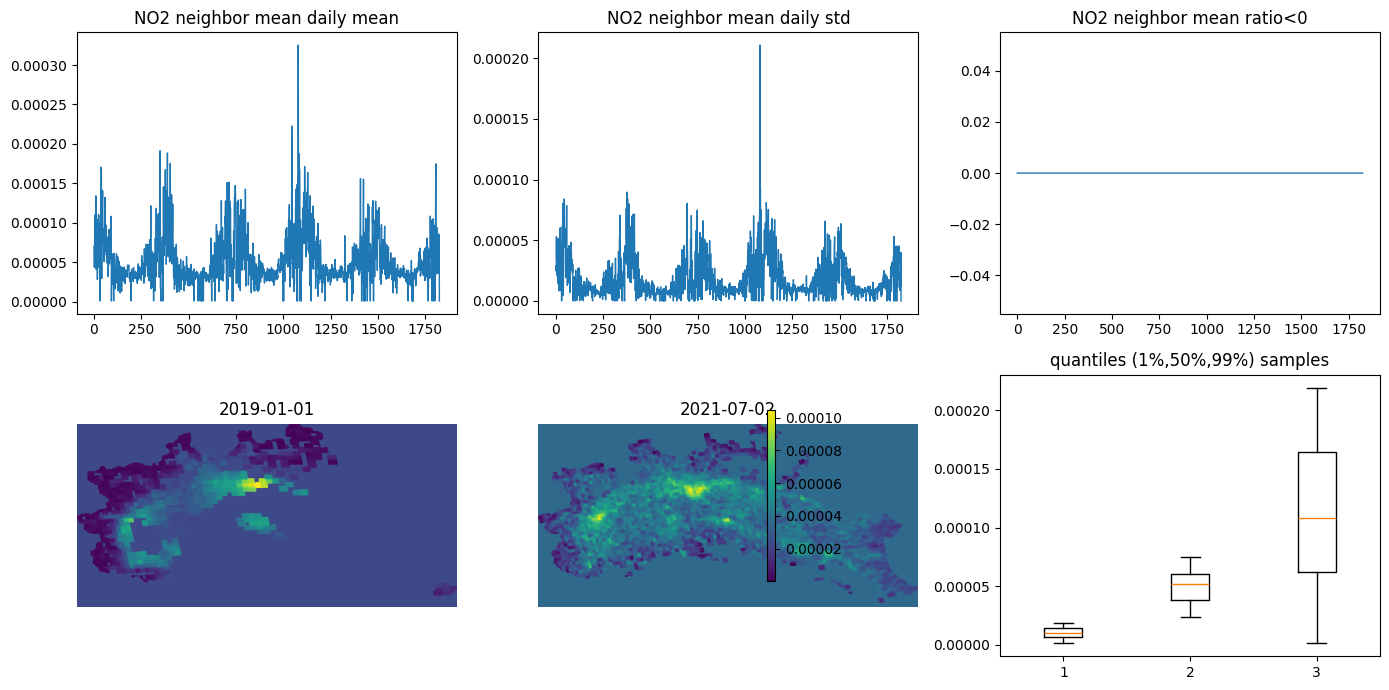


=== CHECK: SO2_Neighbor_Mean_2019_2023.tif ===
size=621x300, bands=1826, dtype=float32
✅ Aligns with template
date range: 2019-01-01 → 2023-12-31, mean gap=1.00d
days=1826, const-days≈(std<1e-12): 533
mean(mean)=4.217e-04, mean(std)=1.453e-04, mean(neg_ratio)=0.000%


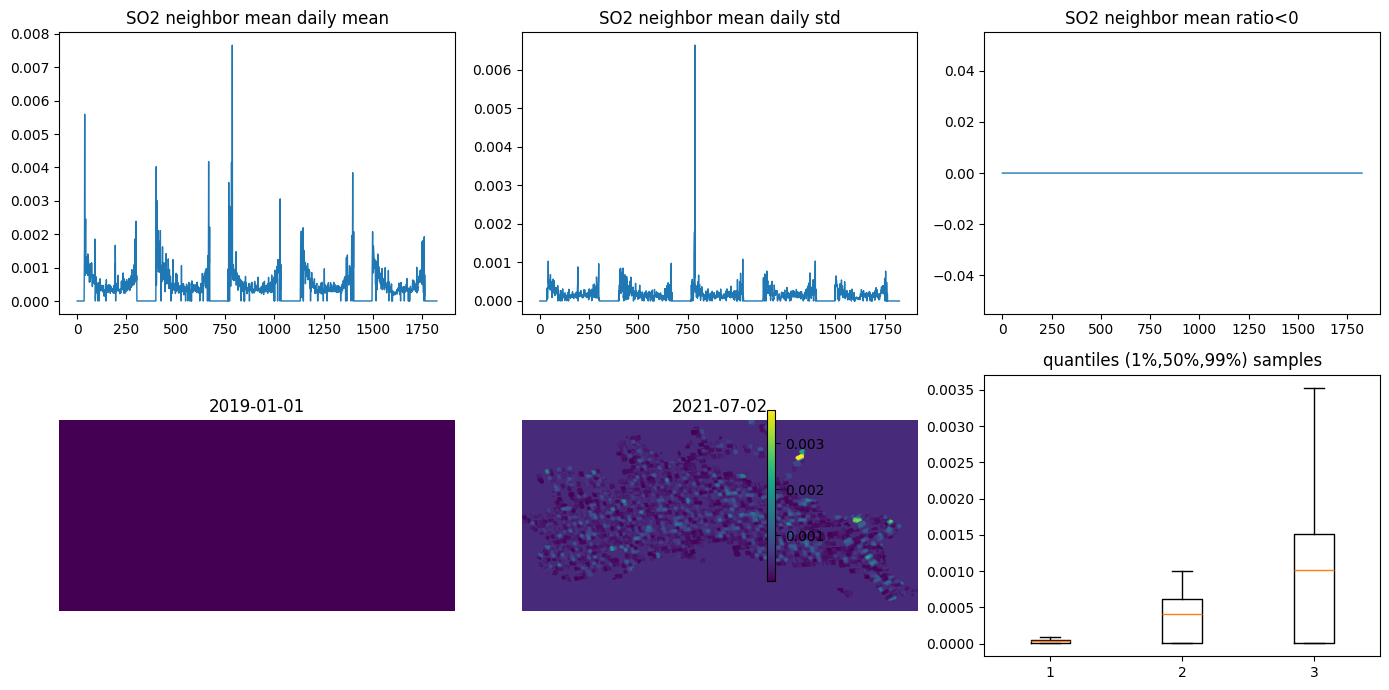

In [7]:
# Quick integrity + stats check for neighbor-mean stacks (no AOI)
import os, numpy as np, pandas as pd, rasterio as rio, matplotlib.pyplot as plt

no2 = "/content/drive/My Drive/Variables/NO2_Neighbor_Mean_2019_2023.tif"
so2 = "/content/drive/My Drive/Variables/SO2_Neighbor_Mean_2019_2023.tif"
tpl = "/content/drive/My Drive/GEE_NO2/NO2_Daily_Multiband_2019.tif"

def check_stack(path, template=None, title=""):
    print(f"\n=== CHECK: {os.path.basename(path)} ===")
    with rio.open(path) as ds:
        # 1) 基本信息与模板对齐
        print(f"size={ds.width}x{ds.height}, bands={ds.count}, dtype={ds.dtypes[0]}")
        if template and os.path.exists(template):
            with rio.open(template) as t:
                assert ds.crs == t.crs, "CRS mismatch vs template"
                assert (ds.width, ds.height) == (t.width, t.height), "Size mismatch vs template"
                assert np.allclose(np.array(ds.transform)[:6], np.array(t.transform)[:6], rtol=1e-9, atol=1e-12), "Transform mismatch vs template"
            print("✅ Aligns with template")

        # 2) 时间轴连续性
        dates = pd.to_datetime(list(ds.descriptions))
        assert dates.is_monotonic_increasing, "Band dates not increasing"
        gaps = np.diff(dates.values).astype("timedelta64[D]").astype(int)
        print(f"date range: {dates[0].date()} → {dates[-1].date()}, mean gap={gaps.mean():.2f}d")

        # 3) 逐天统计（均值/方差/常数天/负值占比）
        means, stds, neg_ratio, const_1e6 = [], [], [], 0
        qs = []  # 分位数
        for b in range(ds.count):
            arr = ds.read(b+1).astype(np.float32)
            # 邻域结果的NoData是-9999（应极少），先统计
            ndv_hits = np.sum(arr == -9999)
            if ndv_hits and b < 3:
                print(f"  band {b+1} ndv hits: {ndv_hits}")
            arr = np.where(arr == -9999, np.nan, arr)
            means.append(np.nanmean(arr))
            stds.append(np.nanstd(arr))
            neg_ratio.append(np.nanmean(arr < 0))
            if np.all(np.isfinite(arr)) and np.nanstd(arr) < 1e-12:
                const_1e6 += 1
            # 取少量分位数
            if b % max(1, ds.count // 20) == 0:
                v = arr[np.isfinite(arr)]
                if v.size:
                    qs.append(np.quantile(v, [0.01, 0.5, 0.99]))

        means, stds, neg_ratio = map(np.array, (means, stds, neg_ratio))
        print(f"days={ds.count}, const-days≈(std<1e-12): {int(np.sum(stds<1e-12))}")
        print(f"mean(mean)={np.nanmean(means):.3e}, mean(std)={np.nanmean(stds):.3e}, mean(neg_ratio)={np.nanmean(neg_ratio):.3%}")

        # 4) 可视化：均值/方差时间序列 + 两日示意 + 分布箱线
        fig, axes = plt.subplots(2, 3, figsize=(14,7))
        t = np.arange(ds.count)
        axes[0,0].plot(t, means, lw=1); axes[0,0].set_title(f"{title} daily mean")
        axes[0,1].plot(t, stds, lw=1); axes[0,1].set_title(f"{title} daily std")
        axes[0,2].plot(t, neg_ratio, lw=1); axes[0,2].set_title(f"{title} ratio<0")

        # 两个代表日（首日/年中/末日）
        for ax, idx in zip(axes[1,:2], [0, ds.count//2]):
            arr = ds.read(idx+1).astype(np.float32)
            arr = np.where(arr == -9999, np.nan, arr)
            im = ax.imshow(arr, cmap="viridis"); ax.set_title(str(dates[idx].date())); ax.axis("off")
        fig.colorbar(im, ax=axes[1,:2], shrink=0.7)

        # 分位数箱线
        if qs:
            axes[1,2].boxplot(np.vstack(qs), showfliers=False)
            axes[1,2].set_title("quantiles (1%,50%,99%) samples")
        plt.tight_layout(); plt.show()

# 依次检查 NO2 / SO2
check_stack(no2, tpl, title="NO2 neighbor mean")
check_stack(so2, tpl, title="SO2 neighbor mean")

In [10]:
# SO2 Neighbor Mean Recompute (only SO2, fixed rule) 重新修复0为较低值，0以下为无效
import os
import numpy as np
import rasterio
from scipy.ndimage import generic_filter
from google.colab import drive
drive.mount('/content/drive')

def nanmean_exclude_center(data):
    FOOTPRINT_EXC_CENTER = np.array([[1,1,1],[1,0,1],[1,1,1]], dtype=bool)
    def f(vals):
        vals = vals[~np.isnan(vals)]
        return np.nan if vals.size == 0 else np.nanmean(vals)
    return generic_filter(data, f, footprint=FOOTPRINT_EXC_CENTER, mode='constant', cval=np.nan)

def calculate_3x3_neighbor_mean_so2(input_file, output_file):
    print(f"Processing: {os.path.basename(input_file)}")
    with rasterio.open(input_file) as src:
        data = src.read()
        profile = src.profile

        # FIX 1: keep 0, only negatives are missing
        data = data.astype(np.float32)
        data[data == -99999.0] = np.nan
        data[data < 0] = np.nan  # changed from <= 0

        neighbor_data = np.empty_like(data, dtype=np.float32)
        for i in range(data.shape[0]):
            if (i + 1) % 50 == 0 or i == 0:
                print(f"  Processing band {i+1}/{data.shape[0]}...")
            band_data = data[i].copy()
            neighbor_data[i] = nanmean_exclude_center(band_data)

            # fallback: same‑day global mean → final 1e-6
            if np.any(np.isnan(neighbor_data[i])):
                valid = band_data[~np.isnan(band_data)]
                if valid.size > 0:
                    gm = float(np.mean(valid))
                    neighbor_data[i] = np.where(np.isnan(neighbor_data[i]), gm, neighbor_data[i])
                else:
                    neighbor_data[i] = np.where(np.isnan(neighbor_data[i]), 1e-6, neighbor_data[i])

        profile.update(dtype='float32')
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(neighbor_data)
    print(f"✅ Saved: {os.path.basename(output_file)}")

# Paths
drive_base = '/content/drive/My Drive/'
so2_input_dir = os.path.join(drive_base, 'GEE_SO2/')
so2_output_dir = os.path.join(drive_base, 'Variables/mean_so2_neighbor/')
os.makedirs(so2_output_dir, exist_ok=True)
years = [2019, 2020, 2021, 2022, 2023]

print("🚀 Recomputing SO2 neighbor mean (keep zeros, only <0 as missing)...")
for year in years:
    input_file = os.path.join(so2_input_dir, f'SO2_Daily_Multiband_{year}.tif')
    output_file = os.path.join(so2_output_dir, f'mean_so2_neighbor_{year}.tif')
    if os.path.exists(input_file):
        calculate_3x3_neighbor_mean_so2(input_file, output_file)
    else:
        print(f"❌ File not found: {input_file}")

print("🎉 SO2 recomputation done. Next: re-run the concatenation script to make SO2_Neighbor_Mean_2019_2023.tif")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Recomputing SO2 neighbor mean (keep zeros, only <0 as missing)...
Processing: SO2_Daily_Multiband_2019.tif
  Processing band 1/365...
  Processing band 50/365...
  Processing band 100/365...
  Processing band 150/365...
  Processing band 200/365...
  Processing band 250/365...
  Processing band 300/365...
  Processing band 350/365...
✅ Saved: mean_so2_neighbor_2019.tif
Processing: SO2_Daily_Multiband_2020.tif
  Processing band 1/366...
  Processing band 50/366...
  Processing band 100/366...
  Processing band 150/366...
  Processing band 200/366...
  Processing band 250/366...
  Processing band 300/366...
  Processing band 350/366...
✅ Saved: mean_so2_neighbor_2020.tif
Processing: SO2_Daily_Multiband_2021.tif
  Processing band 1/365...
  Processing band 50/365...
  Processing band 100/365...
  Processing band 150/365...
  Processing band 200/365...
  Proces

In [11]:
# Concatenate SO2 yearly neighbor-mean TIFs (2019–2023)
# Option A (default): unify to nodata = -9999 (match NO2)
# Option B: keep NaN (set USE_NAN=True)

import os, numpy as np, rasterio, pandas as pd
from google.colab import drive
drive.mount('/content/drive')

USE_NAN = False  # False → A: nodata=-9999；True → B: 保持 NaN

def concatenate_yearly_tifs_so2(input_dir, output_file, years, use_nan=False):
    print(f"Concatenating SO2 neighbor mean files for {years[0]}-{years[-1]} ...")
    file_info, ref_prof, total_bands, all_dates = [], None, 0, []

    # First pass: collect and validate
    print("  First pass: collect + validate ...")
    for y in years:
        p = os.path.join(input_dir, f"mean_so2_neighbor_{y}.tif")
        if not os.path.exists(p):
            print(f"⚠️ missing: {p}"); continue
        with rasterio.open(p) as src:
            if ref_prof is None:
                ref_prof = src.profile.copy()
                print(f"    Reference {y}: {src.width}x{src.height}, {src.count} bands")
                print(f"    Transform: {src.transform}")
            else:
                assert src.width==ref_prof["width"] and src.height==ref_prof["height"], f"size mismatch {y}"
                assert src.crs==ref_prof["crs"], f"CRS mismatch {y}"
                assert np.allclose(np.array(src.transform)[:6], np.array(ref_prof["transform"])[:6], rtol=1e-9, atol=1e-12), f"transform mismatch {y}"
            bc = src.count
            dates = pd.date_range(f"{y}-01-01", periods=bc, freq="D")
            file_info.append({"year":y,"path":p,"bands":bc,"dates":dates})
            total_bands += bc
            all_dates.extend(dates)
            print(f"    {y}: {bc} bands")
    if total_bands == 0:
        print("❌ No yearly files found."); return

    print(f"  Total bands: {total_bands}")
    print(f"  Date range: {all_dates[0].date()} → {all_dates[-1].date()}")

    # Output profile
    out_prof = ref_prof.copy()
    if use_nan:
        out_prof.update(
            count=total_bands, dtype="float32",
            compress="DEFLATE", predictor=3, zlevel=9,
            tiled=True, blockxsize=256, blockysize=256,
            SPARSE_OK=True, BIGTIFF="IF_SAFER", NUM_THREADS="ALL_CPUS",
            interleave="band"
        )
    else:
        out_prof.update(
            count=total_bands, dtype="float32", nodata=-9999,
            compress="DEFLATE", predictor=3, zlevel=9,
            tiled=True, blockxsize=256, blockysize=256,
            SPARSE_OK=True, BIGTIFF="IF_SAFER", NUM_THREADS="ALL_CPUS",
            interleave="band"
        )

    # Second pass: write
    print(f"  Second pass: writing {output_file} ...")
    with rasterio.open(output_file, "w", **out_prof) as dst:
        dst.update_tags(
            source="Neighbor mean 3x3 (exclude center)",
            variable="mean_so2_neighbor",
            years=f"{years[0]}-{years[-1]}",
            **({} if use_nan else {"nodata_value":"-9999"}),
            note="Concatenated yearly SO2 neighbor-mean; dates in band descriptions"
        )
        k = 0
        for info in file_info:
            print(f"    Writing {info['year']} ...")
            with rasterio.open(info["path"]) as src:
                for i in range(info["bands"]):
                    band = src.read(i+1).astype(np.float32)
                    if use_nan:
                        # 若年度文件采用了 -9999，也可在此处统一还原为 NaN
                        band = np.where(band == -9999, np.nan, band)
                    else:
                        # 统一为 -9999
                        band = np.where(np.isnan(band), -9999, band)
                    dst.write(band, k+1)

                    # 优先使用原 band 描述；无则用计算日期
                    try:
                        desc = src.descriptions[i]
                    except Exception:
                        desc = None
                    date_str = desc if (desc and isinstance(desc,str) and len(desc)>=10) \
                               else info["dates"][i].strftime("%Y-%m-%d")
                    dst.set_band_description(k+1, date_str)

                    k += 1
                    if k % 100 == 0:
                        print(f"      {k}/{total_bands} bands written...")

    # Quick check
    print("✅ Saved:", os.path.basename(output_file))
    with rasterio.open(output_file) as chk:
        assert chk.count == total_bands
        assert chk.crs == out_prof["crs"]
        assert chk.width == out_prof["width"] and chk.height == out_prof["height"]
        assert np.allclose(np.array(chk.transform)[:6], np.array(out_prof["transform"])[:6], rtol=1e-9, atol=1e-12)
    size_mb = os.path.getsize(output_file)/(1024**2)
    theo_mb = (total_bands*out_prof["height"]*out_prof["width"]*4)/(1024**2)
    print(f"   File size: {size_mb:.1f} MB | compression ratio: {theo_mb/size_mb:.1f}x")

# Paths
drive_base = "/content/drive/My Drive/"
so2_input_dir = os.path.join(drive_base, "Variables/mean_so2_neighbor/")
output_dir = os.path.join(drive_base, "Variables/")
os.makedirs(output_dir, exist_ok=True)
years = [2019, 2020, 2021, 2022, 2023]
out_path = os.path.join(output_dir, "SO2_Neighbor_Mean_2019_2023.tif")

# Run (选择策略：USE_NAN=False → 与 NO2 一致；True → 保持 NaN)
concatenate_yearly_tifs_so2(so2_input_dir, out_path, years, use_nan=USE_NAN)

# Optional: check vs S5P template
tpl = os.path.join(drive_base, "GEE_NO2/NO2_Daily_Multiband_2019.tif")
if os.path.exists(tpl):
    with rasterio.open(tpl) as t, rasterio.open(out_path) as o:
        assert o.crs==t.crs and o.width==t.width and o.height==t.height
        assert np.allclose(np.array(o.transform)[:6], np.array(t.transform)[:6], rtol=1e-9, atol=1e-12)
    print("✅ SO2 output aligns with S5P template")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Concatenating SO2 neighbor mean files for 2019-2023 ...
  First pass: collect + validate ...
    Reference 2019: 621x300, 365 bands
    Transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
    2019: 365 bands
    2020: 366 bands
    2021: 365 bands
    2022: 365 bands
    2023: 365 bands
  Total bands: 1826
  Date range: 2019-01-01 → 2023-12-31
  Second pass: writing /content/drive/My Drive/Variables/SO2_Neighbor_Mean_2019_2023.tif ...
    Writing 2019 ...
      100/1826 bands written...
      200/1826 bands written...
      300/1826 bands written...
    Writing 2020 ...
      400/1826 bands written...
      500/1826 bands written...
      600/1826 bands written...
      700/1826 bands written...
    Writing 2021 ...
      800/1826 bands written...
      900/1826 bands written...
      1000/1826 bands written...
    Writing 2022 ...
      1

## 14. DEM

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os

def process_dem_to_s5p_grid():
    """Reproject DEM to S5P grid alignment"""

    print(" Processing DEM to S5P grid alignment...")

    # File paths
    dem_file = "/content/drive/MyDrive/Variables/srtm_dem_30m.tif"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
    output_dir = "/content/drive/MyDrive/Variables/dem_aligned_s5p"
    os.makedirs(output_dir, exist_ok=True)

    # Check if files exist
    print("Checking file existence...")
    print(f"DEM file exists: {os.path.exists(dem_file)}")
    print(f"S5P reference exists: {os.path.exists(s5p_reference)}")

    try:
        # Load S5P reference to get target specifications
        with rasterio.open(s5p_reference) as src:
            target_crs = src.crs
            target_transform = src.transform
            target_width = src.width
            target_height = src.height
            target_bounds = src.bounds

        print(f" S5P Reference Grid:")
        print(f"   CRS: {target_crs}")
        print(f"   Width: {target_width}")
        print(f"   Height: {target_height}")
        print(f"   Transform: {target_transform}")
        print(f"   Bounds: {target_bounds}")

        # Load DEM data
        with rasterio.open(dem_file) as src:
            print(f"\n🏔️ DEM Data:")
            print(f"   CRS: {src.crs}")
            print(f"   Width: {src.width}")
            print(f"   Height: {src.height}")
            print(f"   Transform: {src.transform}")
            print(f"   Bounds: {src.bounds}")
            print(f"   Data type: {src.dtypes[0]}")
            print(f"   NoData value: {src.nodata}")

            # Read DEM data
            dem_data = src.read(1)  # Read first band
            print(f"   Data range: {np.nanmin(dem_data)} - {np.nanmax(dem_data)} m")

        # Create output array
        output_data = np.full((target_height, target_width), np.nan, dtype=np.float32)

        # Reproject DEM to S5P grid
        print(f"\n🔄 Reprojecting DEM...")
        reproject(
            source=dem_data,
            destination=output_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear,
            nodata=np.nan
        )

        # Create output profile
        output_profile = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': 1,
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': np.nan
        }

        # Save aligned DEM
        output_file = f"{output_dir}/dem_s5p_aligned.tif"
        with rasterio.open(output_file, 'w', **output_profile) as dst:
            dst.write(output_data, 1)

        # Quality check
        valid_mask = ~np.isnan(output_data)
        valid_data = output_data[valid_mask]

        print(f"\n✅ DEM processing completed!")
        print(f"   Output file: {output_file}")
        print(f"   Shape: {output_data.shape}")
        print(f"   Valid pixels: {np.sum(valid_mask)}")
        print(f"   Data range: {valid_data.min():.2f} - {valid_data.max():.2f} m")
        print(f"   Mean elevation: {valid_data.mean():.2f} m")
        print(f"   Std elevation: {valid_data.std():.2f} m")

    except Exception as e:
        print(f"Error processing DEM: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    process_dem_to_s5p_grid()

 Processing DEM to S5P grid alignment...
Checking file existence...
DEM file exists: True
S5P reference exists: True
 S5P Reference Grid:
   CRS: EPSG:4326
   Width: 621
   Height: 300
   Transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
   Bounds: BoundingBox(left=6.620030281745857, bottom=43.640199621659995, right=12.830058688036154, top=46.64021334450555)

🏔️ DEM Data:
   CRS: EPSG:4326
   Width: 23011
   Height: 11084
   Transform: | 0.00, 0.00, 6.63|
| 0.00,-0.00, 46.64|
| 0.00, 0.00, 1.00|
   Bounds: BoundingBox(left=6.626602356364475, bottom=43.64815150855502, right=12.827942257226768, top=46.63522949130925)
   Data type: int16
   NoData value: None
   Data range: -26 - 4797 m

🔄 Reprojecting DEM...

✅ DEM processing completed!
   Output file: /content/drive/MyDrive/Variables/dem_aligned_s5p/dem_s5p_aligned.tif
   Shape: (300, 621)
   Valid pixels: 186300
   Data range: -6.77 - 4239.52 m
   Mean elevation: 327.18 m
   Std elevation: 614.33 m


## 15. SLOPE

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os

def process_slope_to_s5p_grid():
    """Reproject slope to S5P grid alignment"""

    print("🏔️ Processing slope to S5P grid alignment...")

    # File paths
    slope_file = "/content/drive/MyDrive/Variables/srtm_slope_30m.tif"
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
    output_dir = "/content/drive/MyDrive/Variables/slope_aligned_s5p"
    os.makedirs(output_dir, exist_ok=True)

    # Check if files exist
    print("Checking file existence...")
    print(f"Slope file exists: {os.path.exists(slope_file)}")
    print(f"S5P reference exists: {os.path.exists(s5p_reference)}")

    try:
        # Load S5P reference to get target specifications
        with rasterio.open(s5p_reference) as src:
            target_crs = src.crs
            target_transform = src.transform
            target_width = src.width
            target_height = src.height

        print(f" S5P Reference Grid:")
        print(f"   Width: {target_width}")
        print(f"   Height: {target_height}")

        # Load slope data
        with rasterio.open(slope_file) as src:
            print(f"\n🏔️ Slope Data:")
            print(f"   CRS: {src.crs}")
            print(f"   Width: {src.width}")
            print(f"   Height: {src.height}")
            print(f"   Transform: {src.transform}")
            print(f"   Bounds: {src.bounds}")
            print(f"   Data type: {src.dtypes[0]}")
            print(f"   NoData value: {src.nodata}")

            # Read slope data
            slope_data = src.read(1)  # Read first band
            print(f"   Data range: {np.nanmin(slope_data)} - {np.nanmax(slope_data)} degrees")

        # Create output array
        output_data = np.full((target_height, target_width), np.nan, dtype=np.float32)

        # Reproject slope to S5P grid
        print(f" Reprojecting slope...")
        reproject(
            source=slope_data,
            destination=output_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear,
            nodata=np.nan
        )

        # Create output profile
        output_profile = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': 1,
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': np.nan
        }

        # Save aligned slope
        output_file = f"{output_dir}/slope_s5p_aligned.tif"
        with rasterio.open(output_file, 'w', **output_profile) as dst:
            dst.write(output_data, 1)

        # Quality check
        valid_mask = ~np.isnan(output_data)
        valid_data = output_data[valid_mask]

        print(f"\n✅ Slope processing completed!")
        print(f"   Output file: {output_file}")
        print(f"   Shape: {output_data.shape}")
        print(f"   Valid pixels: {np.sum(valid_mask)}")
        print(f"   Data range: {valid_data.min():.2f} - {valid_data.max():.2f} degrees")
        print(f"   Mean slope: {valid_data.mean():.2f} degrees")
        print(f"   Std slope: {valid_data.std():.2f} degrees")

    except Exception as e:
        print(f"Error processing slope: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    process_slope_to_s5p_grid()

🏔️ Processing slope to S5P grid alignment...
Checking file existence...
Slope file exists: True
S5P reference exists: True
 S5P Reference Grid:
   Width: 621
   Height: 300

🏔️ Slope Data:
   CRS: EPSG:4326
   Width: 23011
   Height: 11084
   Transform: | 0.00, 0.00, 6.63|
| 0.00,-0.00, 46.64|
| 0.00, 0.00, 1.00|
   Bounds: BoundingBox(left=6.626602356364475, bottom=43.64815150855502, right=12.827942257226768, top=46.63522949130925)
   Data type: float32
   NoData value: None
   Data range: 0.0 - 88.03978729248047 degrees
 Reprojecting slope...

✅ Slope processing completed!
   Output file: /content/drive/MyDrive/Variables/slope_aligned_s5p/slope_s5p_aligned.tif
   Shape: (300, 621)
   Valid pixels: 92466
   Data range: 0.00 - 45.56 degrees
   Mean slope: 12.40 degrees
   Std slope: 11.39 degrees


## 16. LULC

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.merge import merge
import numpy as np
import os

def process_esa_lulc_to_s5p_grid_merged():
    """Loads multiple ESA LULC 2020 files, merges them, reprojects to S5P grid alignment"""

    print(" Processing ESA LULC 2020 (merged) to S5P grid alignment...")

    # File paths - 两个ESA LULC文件
    lulc_files = [
        "/content/drive/MyDrive/Variables/esa_lulc_2020-0000000000-0000000000.tif",
        "/content/drive/MyDrive/Variables/esa_lulc_2020-0000000000-0000065536.tif"
    ]
    s5p_reference = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2019.tif"
    output_dir = "/content/drive/MyDrive/Variables/lulc_esa_aligned_s5p"
    os.makedirs(output_dir, exist_ok=True)

    # Check if files exist
    print("Checking file existence...")
    for f in lulc_files:
        print(f"LULC file exists ({os.path.basename(f)}): {os.path.exists(f)}")
    print(f"S5P reference exists: {os.path.exists(s5p_reference)}")

    try:
        # Load S5P reference
        with rasterio.open(s5p_reference) as src:
            target_crs = src.crs
            target_transform = src.transform
            target_width = src.width
            target_height = src.height

        print(f" S5P Reference Grid:")
        print(f"   Width: {target_width}")
        print(f"   Height: {target_height}")

        # Load and merge LULC files
        print(f"\n🔄 Loading and merging ESA LULC files...")
        src_files_to_mosaic = []
        for path in lulc_files:
            src_files_to_mosaic.append(rasterio.open(path))

        # Merge function returns a single array and the transform of the merged image
        mosaic, out_transform = merge(src_files_to_mosaic)

        # Close the source files
        for src_file in src_files_to_mosaic:
            src_file.close()

        # The merged data will have a new profile
        merged_profile = src_files_to_mosaic[0].profile.copy()
        merged_profile.update({
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_transform,
            "count": mosaic.shape[0]
        })

        # Assuming LULC is single band, take the first band
        merged_lulc_data = mosaic[0]

        print(f"   Merged LULC data shape: {merged_lulc_data.shape}")
        print(f"   Merged LULC data type: {merged_lulc_data.dtype}")

        # Get unique LULC classes
        unique_classes = np.unique(merged_lulc_data)
        print(f"   Unique LULC classes: {unique_classes}")
        print(f"   Number of classes: {len(unique_classes)}")

        # Create output array
        output_data = np.full((target_height, target_width), np.nan, dtype=np.float32)

        # Reproject merged LULC to S5P grid
        print(f"\n🔄 Reprojecting merged LULC to S5P grid...")
        reproject(
            source=merged_lulc_data,
            destination=output_data,
            src_transform=out_transform,
            src_crs=merged_profile['crs'],
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest,  # Use nearest neighbor for categorical data
            nodata=np.nan
        )

        # Create output profile
        output_profile = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': 1,
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': np.nan
        }

        # Save aligned LULC
        output_file = f"{output_dir}/lulc_esa_2020_merged_s5p_aligned.tif"
        with rasterio.open(output_file, 'w', **output_profile) as dst:
            dst.write(output_data, 1)

        # Quality check
        valid_mask = ~np.isnan(output_data)
        valid_data = output_data[valid_mask]
        aligned_classes = np.unique(valid_data)

        print(f"\n✅ ESA LULC processing completed!")
        print(f"   Output file: {output_file}")
        print(f"   Shape: {output_data.shape}")
        print(f"   Valid pixels: {np.sum(valid_mask)}")
        print(f"   LULC classes in aligned data: {aligned_classes}")
        print(f"   Number of classes: {len(aligned_classes)}")

        # Class distribution
        for class_id in sorted(aligned_classes):
            if not np.isnan(class_id):
                count = np.sum(valid_data == class_id)
                percentage = (count / len(valid_data)) * 100
                print(f"   Class {int(class_id)}: {count} pixels ({percentage:.1f}%)")

    except Exception as e:
        print(f"Error processing ESA LULC: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    process_esa_lulc_to_s5p_grid_merged()

 Processing ESA LULC 2020 (merged) to S5P grid alignment...
Checking file existence...
LULC file exists (esa_lulc_2020-0000000000-0000000000.tif): True
LULC file exists (esa_lulc_2020-0000000000-0000065536.tif): True
S5P reference exists: True
 S5P Reference Grid:
   Width: 621
   Height: 300

🔄 Loading and merging ESA LULC files...
   Merged LULC data shape: (33251, 69033)
   Merged LULC data type: uint8
   Unique LULC classes: [  0  10  20  30  40  50  60  70  80  90 100]
   Number of classes: 11

🔄 Reprojecting merged LULC to S5P grid...

✅ ESA LULC processing completed!
   Output file: /content/drive/MyDrive/Variables/lulc_esa_aligned_s5p/lulc_esa_2020_merged_s5p_aligned.tif
   Shape: (300, 621)
   Valid pixels: 186300
   LULC classes in aligned data: [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
   Number of classes: 11
   Class 0: 91618 pixels (49.2%)
   Class 10: 37251 pixels (20.0%)
   Class 20: 427 pixels (0.2%)
   Class 30: 19700 pixels (10.6%)
   Class 40: 24658 p

In [ ]:
import rasterio
import numpy as np
import os

def create_lulc_one_hot_encoding():
    """Create one-hot encoding for ESA LULC categories"""

    print("🔥 Creating one-hot encoding for ESA LULC categories...")

    # File paths
    lulc_file = "/content/drive/MyDrive/Variables/lulc_esa_aligned_s5p/lulc_esa_2020_merged_s5p_aligned.tif"
    output_dir = "/content/drive/MyDrive/Variables/lulc_esa_onehot_s5p"
    os.makedirs(output_dir, exist_ok=True)

    try:
        # Load aligned LULC data
        with rasterio.open(lulc_file) as src:
            lulc_data = src.read(1)
            profile = src.profile

        print(f"Loaded LULC data shape: {lulc_data.shape}")

        # Get unique categories (excluding NaN)
        unique_categories = np.unique(lulc_data[~np.isnan(lulc_data)])
        print(f"Unique categories: {unique_categories}")

        # Create one-hot encoding for each category
        # Skip category 0 (background) as it's not a meaningful land cover type
        meaningful_categories = [cat for cat in unique_categories if cat != 0]

        print(f"Creating one-hot layers for categories: {meaningful_categories}")

        # Update profile for one-hot layers
        one_hot_profile = profile.copy()
        one_hot_profile.update({
            'count': 1,
            'dtype': 'uint8',
            'nodata': 0
        })

        # Create and save one-hot layers
        for category in meaningful_categories:
            # Create binary layer for this category
            one_hot_layer = np.zeros(lulc_data.shape, dtype=np.uint8)
            one_hot_layer[lulc_data == category] = 1

            # Save one-hot layer
            output_file = f"{output_dir}/lulc_class_{int(category)}_onehot.tif"
            with rasterio.open(output_file, 'w', **one_hot_profile) as dst:
                dst.write(one_hot_layer, 1)

            # Statistics
            valid_pixels = np.sum(one_hot_layer == 1)
            total_pixels = np.sum(~np.isnan(lulc_data))
            percentage = (valid_pixels / total_pixels) * 100

            print(f"  ✅ Class {int(category)}: {valid_pixels} pixels ({percentage:.1f}%) -> {output_file}")

        print(f"\n🎉 One-hot encoding completed!")
        print(f"   Output directory: {output_dir}")
        print(f"   Number of one-hot layers: {len(meaningful_categories)}")

        # Summary of all layers
        print(f"\n📊 One-hot layers summary:")
        for category in meaningful_categories:
            one_hot_layer = np.zeros(lulc_data.shape, dtype=np.uint8)
            one_hot_layer[lulc_data == category] = 1
            valid_pixels = np.sum(one_hot_layer == 1)
            print(f"   LULC Class {int(category)}: {valid_pixels} pixels")

    except Exception as e:
        print(f"Error creating one-hot encoding: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    create_lulc_one_hot_encoding()

🔥 Creating one-hot encoding for ESA LULC categories...
Loaded LULC data shape: (300, 621)
Unique categories: [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
Creating one-hot layers for categories: [np.float32(10.0), np.float32(20.0), np.float32(30.0), np.float32(40.0), np.float32(50.0), np.float32(60.0), np.float32(70.0), np.float32(80.0), np.float32(90.0), np.float32(100.0)]
  ✅ Class 10: 37251 pixels (20.0%) -> /content/drive/MyDrive/Variables/lulc_esa_onehot_s5p/lulc_class_10_onehot.tif
  ✅ Class 20: 427 pixels (0.2%) -> /content/drive/MyDrive/Variables/lulc_esa_onehot_s5p/lulc_class_20_onehot.tif
  ✅ Class 30: 19700 pixels (10.6%) -> /content/drive/MyDrive/Variables/lulc_esa_onehot_s5p/lulc_class_30_onehot.tif
  ✅ Class 40: 24658 pixels (13.2%) -> /content/drive/MyDrive/Variables/lulc_esa_onehot_s5p/lulc_class_40_onehot.tif
  ✅ Class 50: 5025 pixels (2.7%) -> /content/drive/MyDrive/Variables/lulc_esa_onehot_s5p/lulc_class_50_onehot.tif
  ✅ Class 60: 3164 pixels (1.7%) -> /